# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import os
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper, 
    MonetaryLiquidator, 
    MonetarySniper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.data_collection import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.plots import (
    DEFAULT_FIGURE_SIZE, 
    convert_time_in_seconds_to_index, 
    convert_time_interval_in_seconds_to_indices, 
    construct_full_time_axis, 
    construct_time_axis, 
    get_indices_and_time_axis_to_plot, 
    plot_multiple_variables_over_time, 
    plot_price_deviations, 
    plot_skews, 
    plot_single_variable_over_time, 
    plot_single_variable_over_time_from_numpy_array, 
    plot_supply, 
    plot_treasury, 
    plot_liquidity, 
    plot_spot_vs_futures_price, 
    plot_open_positions
)

from ovm.monetary.reporters import * 
from ovm.monetary.data_io import (
    construct_sims_map, 
    construct_ticker_to_series_of_prices_map_from_simulated_prices
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.simulation.bootstrap import plot_multivariate_simulation
from ovm.simulation.resampling import (
    load_log_returns,
    simulate_new_price_series_via_bootstrap,
    store_simulated_price_series_in_output_directory
)

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER,
    EOS_ETH_TICKER,
    MKR_ETH_TICKER,
    SNX_ETH_TICKER,
    TRX_ETH_TICKER,
    XRP_ETH_TICKER,
    ETH_TICKER,
    USD_TICKER,
    ovl_quote_ticker,
)

from ovm.time_resolution import (
    TimeResolution, 
    TimeScale
)

environment variable OVERLAY_MONETARY_BASE_PATH not set defaulting to /home/michael/PycharmProjects/overlay-monetary


In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
time_resolution = TimeResolution.ONE_MINUTE

# 200000 steps corresponds to about 1.14 months
# 200000 * 15 / 60 / 60 / 24 / 365.25 * 12 = 1.14077116131
# number_of_steps_to_simulate = 200000

# number_of_steps_to_simulate = 1000

# 700000 steps corresponds to about 4 months (i.e. 1/3 year with 15 seconds per step)
# 700000 * 15 / 60 / 60 / 24 / 365.25 = 0.33272492204
# number_of_steps_to_simulate = 700000

# number_of_steps_to_simulate = int(24 * 60 * 60 / time_resolution.in_seconds)

# run agent based simulations for 2 years
number_of_steps_to_simulate = int(2 * 365.25 * 24 * 60 * 60 / time_resolution.in_seconds)
print(f'number_of_steps_to_simulate={number_of_steps_to_simulate}')

directory_path = \
    construct_historical_data_directory(
        historical_data_source=HistoricalDataSource.KUCOIN, 
        time_resolution=time_resolution)

numpy_seed = 42

tickers = [EOS_ETH_TICKER,
           MKR_ETH_TICKER,
           SNX_ETH_TICKER,
           XRP_ETH_TICKER]

OVL_TICKER = SNX_ETH_TICKER  # for sim source, since OVL doesn't actually exist yet
QUOTE_TICKER = ETH_TICKER
OVL_QUOTE_TICKER = ovl_quote_ticker(QUOTE_TICKER)


tickers_with_ovl = [OVL_QUOTE_TICKER if ticker == OVL_TICKER else ticker for ticker in tickers]
tickers_with_ovl

number_of_steps_to_simulate=1051920


['EOS-ETH', 'MKR-ETH', 'OVL-ETH', 'XRP-ETH']

# Load Historical Price Data and Resample

In [8]:
log_return_df, closing_price_df, initial_prices = \
    load_log_returns(series_names=tickers,
                     period_length_in_seconds=time_resolution.in_seconds,
                     directory_path=directory_path)
log_return_df.shape

(1013821, 4)

In [9]:
simulated_sample_length_in_seconds = \
    5 * 365.25 * 24 * 60 * 60

# simulated_sample_length_in_seconds = log_return_df.shape[0] * time_resolution.in_seconds
np.random.seed(numpy_seed)

simulated_prices = \
    simulate_new_price_series_via_bootstrap(
        initial_prices=initial_prices,
        input_log_return_df=log_return_df,
        time_resolution=time_resolution,
        block_length_in_seconds=4 * 24 * 60 * 60,  # 4 day block length
        simulated_sample_length_in_steps_in_seconds=simulated_sample_length_in_seconds,
            number_of_paths=1)
simulated_prices.shape

(1, 2629800, 4)

In [10]:
simulated_cumulative_returns = simulated_prices / simulated_prices[0, 0, :] - 1.0

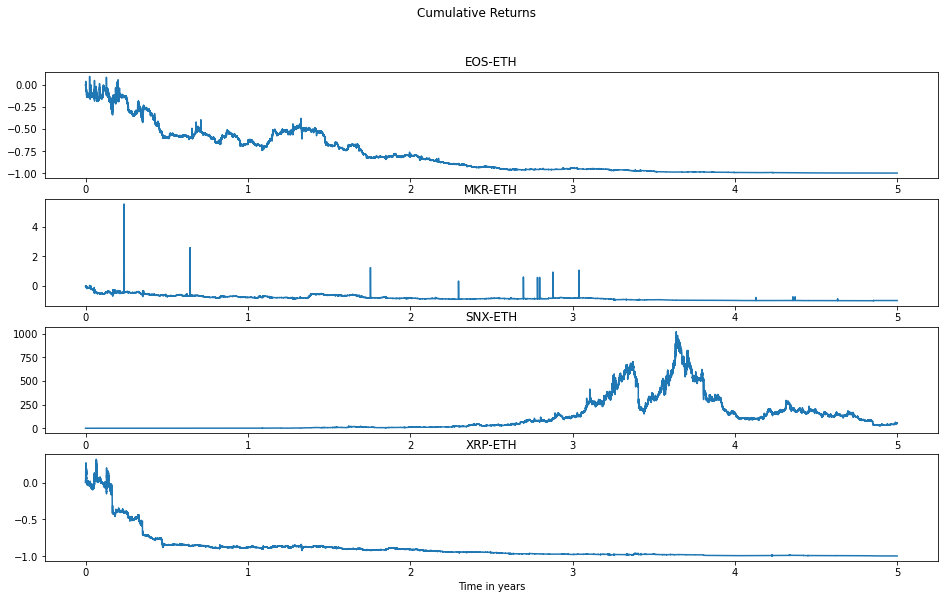

In [11]:
plot_multivariate_simulation(simulated_data=simulated_cumulative_returns,
                             series_names=tickers, 
                             tZODB runs on Python 2.7 or Python 3.4 and above. It also runs on PyPy.ime_resolution=time_resolution, 
                             title='Cumulative Returns')

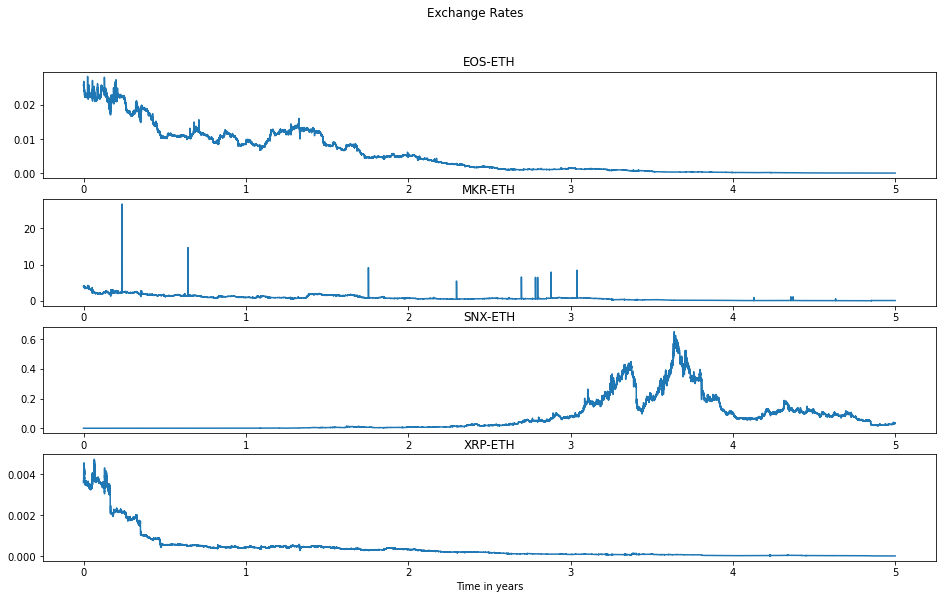

In [12]:
plot_multivariate_simulation(simulated_data=simulated_prices,
                             series_names=tickers, 
                             time_resolution=time_resolution, 
                             title='Exchange Rates')

In [13]:
simulated_prices

array([[[2.59243540e-02, 4.10000000e+00, 6.35700000e-04, 3.58640845e-03],
        [2.59243540e-02, 4.10000000e+00, 6.35700000e-04, 3.58640845e-03],
        [2.59243540e-02, 4.10000000e+00, 6.35700000e-04, 3.61031784e-03],
        ...,
        [5.03648392e-05, 8.71403858e-02, 3.30065214e-02, 6.46671675e-06],
        [5.03952749e-05, 8.71403858e-02, 3.30065214e-02, 6.47224386e-06],
        [5.04135362e-05, 8.71403858e-02, 3.30065214e-02, 6.47224386e-06]]])

In [14]:
# ticker_to_time_series_of_prices_map = \
#     construct_ticker_to_series_of_prices_map_from_simulated_prices(simulated_prices=simulated_prices, 
#                                                                    tickers=tickers_with_ovl)

In [15]:
# ticker_to_time_series_of_prices_map

In [16]:
def construct_ticker_to_series_of_prices_map_from_historical_prices(
        historical_price_df: pd.DataFrame, 
        tickers: tp.Sequence[str], 
        ovl_ticker: str, 
        ovl_quote_ticker: str) -> tp.Dict[str, np.ndarray]:
    
    result = {ovl_quote_ticker if ticker == ovl_ticker else ticker: historical_price_df.loc[:, ticker].values 
              for ticker 
              in tickers}
    
    return result

In [17]:
ticker_to_time_series_of_prices_map = \
    construct_ticker_to_series_of_prices_map_from_historical_prices(
        historical_price_df=closing_price_df, 
        tickers=tickers, 
        ovl_ticker=OVL_TICKER, 
        ovl_quote_ticker=OVL_QUOTE_TICKER)

In [18]:
ticker_to_time_series_of_prices_map

{'EOS-ETH': array([0.0258226, 0.0207657, 0.0215244, ..., 0.0023   , 0.0023   ,
        0.0023   ]),
 'MKR-ETH': array([4.1      , 3.4798327, 4.167512 , ..., 1.0118   , 1.0118   ,
        1.0118   ]),
 'OVL-ETH': array([0.0006357, 0.0003766, 0.00044  , ..., 0.0109575, 0.0110133,
        0.0109971]),
 'XRP-ETH': array([0.0035768, 0.0029722, 0.0022677, ..., 0.0002344, 0.0002349,
        0.0002357])}

# Load Resampled Data

# Construct Agent Based Monetary Model

In [19]:
# Constants
STEPS_MONTH = int((86400*30)/time_resolution.in_seconds)

total_supply = 100000  # OVL
# base_wealth = 0.0002*100000  # OVL
base_wealth = 0.001*100000  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
base_liquidate_reward = 0.1
base_maintenance = 0.6
liquidity = 0.285*total_supply
time_liquidity_mine = STEPS_MONTH
treasury = 0.0
sampling_interval = int(3600/time_resolution.in_seconds)


# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

# num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 100)
num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 50)
num_keepers = int(total_supply*0.005/base_wealth)
# num_traders = int(total_supply*0.005/base_wealth)
num_traders = 0
# num_holders = int(total_supply*0.5/base_wealth)
num_holders = 0
# num_snipers = min(int(total_supply*0.1/base_wealth), 100)
num_snipers = min(int(total_supply*0.1/base_wealth), 50)
# num_liquidators = int(total_supply*0.005/base_wealth)
num_liquidators = 4 * (len(tickers) + 1)
num_agents = num_arbitrageurs + num_keepers + \
    num_traders + num_holders + num_snipers + num_liquidators

DATA_COLLECTOR_NAME = 'data_collector'
data_collection_options = \
    DataCollectionOptions(compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False)

monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  num_snipers=num_snipers, 
                  num_liquidators=num_liquidators, 
                  base_maintenance=base_maintenance, 
                  base_liquidate_reward=base_liquidate_reward, 
                  sims=ticker_to_time_series_of_prices_map, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  data_collection_options=data_collection_options, 
                  quote_ticker=QUOTE_TICKER, 
                  ovl_quote_ticker=OVL_QUOTE_TICKER,
                  seed=0)

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {num_arbitrageurs}")
print(f"num_snipers = {num_snipers}")
print(f"num_keepers = {num_keepers}")
print(f"num_traders = {num_traders}")
print(f"num_holders = {num_holders}")
print(f"num_liquidators = {num_liquidators}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {base_wealth}")

Model kwargs for initial conditions of sim:
quote_ticker = ETH
ovl_quote_ticker = OVL-ETH
num_arbitrageurs = 50
num_snipers = 50
num_keepers = 5
num_traders = 0
num_holders = 0
num_liquidators = 20
base_wealth = 100.0
total_supply = 41000.0
sampling_interval = 60
num_agents * base_wealth + liquidity = 41000.0
Model kwargs for initial conditions of sim:
num_arbitrageurs = 50
num_snipers = 50
num_keepers = 5
num_traders = 0
num_holders = 0
num_liquidators = 20
total number of agents = 125
base_wealth = 100.0


Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

# Run Simulation

In [20]:
def run_model(number_of_steps_to_simulate: int):
    for i in tqdm(range(number_of_steps_to_simulate + 1)):
        monetary_model.step()

In [21]:
number_of_steps_to_simulate

1051920

In [22]:
run_model(number_of_steps_to_simulate)

  0%|          | 34/1051921 [00:00<52:48, 331.99it/s]

step 0
supply 41000.0
treasury 0.0
fmarket: ticker EOS-ETH
fmarket: nx 3562.4999999999995
fmarket: px 0.0006357
fmarket: ny 3562.4999999999995
fmarket: py 0.024617970305081595
fmarket: x 2.2646812499999998
fmarket: y 87.70151921185317
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 0.0
fmarket: futures price 0.0258226
fmarket: spot price 0.0258226
fmarket: price_diff bw f/s 0.0
fmarket: positional imbalance 0.0
fmarket: open positions 0
fmarket: ticker MKR-ETH
fmarket: nx 3562.4999999999995
fmarket: px 0.0006357
fmarket: ny 3562.4999999999995
fmarket: py 0.0001550487804878049
fmarket: x 2.2646812499999998
fmarket: y 0.5523612804878049
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 0.0
fmarket: futures price 4.1
fmarket: spot price 4.1
fmarket: price_diff bw f/s 0.0
fmarket: positional imbalance 0.0
fmarket: open positions 0
fmarket: ticker OVL-ETH
fmarket: nx 3562.4999999999995
fmarket: px 0.0006357
fmar

  0%|          | 88/1051921 [00:00<59:44, 293.43it/s]


fund: py (prior) = 0.0001550487804878049
fund: price (prior) = 4.1462546346999885
fund: twap_ovl_quote_feed = 0.00044220499999999993
fund: twap_feed = 4.154925478333333
fund: px (updated) = 0.00044220499999999993
fund: py (updated) = 0.00010642910499982824
fund: price (updated) = 4.1462546346999885
fund: px (prior) = 0.0006357
fund: py (prior) = 1.0
fund: price (prior) = 0.00044417306922676084
fund: twap_ovl_quote_feed = 0.00044220499999999993
fund: twap_feed = 0.00044220499999999993
fund: px (updated) = 0.00044220499999999993
fund: py (updated) = 1.0
fund: price (updated) = 0.00044417306922676084
fund: px (prior) = 0.0006357
fund: py (prior) = 0.1777286960411541
fund: price (prior) = 0.0022829305144589367
fund: twap_ovl_quote_feed = 0.00044220499999999993
fund: twap_feed = 0.002301260000000001
fund: px (updated) = 0.00044220499999999993
fund: py (updated) = 0.19215777443661286
fund: price (updated) = 0.0022829305144589367
fund: px (prior) = 0.0006357
fund: py (prior) = 0.024617970305

  0%|          | 114/1051921 [00:00<1:02:43, 279.47it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 106
supply 40863.041222916785
treasury 9.433894400989654
step 107
supply 40863.041222916785
treasury 9.433894400989654
step 108
supply 40863.041222916785
treasury 9.433894400989654
step 109
supply 40863.041222916785
treasury 9.433894400989654
step 110
supply 40863.041222916785
treasury 9.433894400989654
step 111
supply 40863.041222916785
treasury 9.433894400989654
step 112
supply 40863.041222916785
treasury 9.433894400989654
step 113
supply 40863.041222916785
treasury 9.433894400989654


  0%|          | 137/1051921 [00:00<1:07:23, 260.11it/s]

step 114
supply 40863.041222916785
treasury 9.433894400989654
step 115
supply 40863.041222916785
treasury 9.433894400989654
step 116
supply 40863.041222916785
treasury 9.433894400989654
step 117
supply 40863.041222916785
treasury 9.433894400989654
step 118
supply 40863.041222916785
treasury 9.433894400989654
step 119
supply 40863.041222916785
treasury 9.433894400989654
step 120
supply 40863.041222916785
treasury 9.433894400989654
fmarket: ticker EOS-ETH
fmarket: nx 3256.2353558317836
fmarket: px 0.00044220499999999993
fmarket: ny 3896.1068721543447
fmarket: py 0.020488207174729635
fmarket: x 2.071428074170885
fmarket: y 95.88360254077234
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 348.7841477258223
fmarket: futures price 0.021603569528898924
fmarket: spot price 0.0215244
fmarket: price_diff bw f/s 0.003678129420514631
fmarket: positional imbalance -348.7841477258223
fmarket: open positions 19
fmarket: ticker MKR-ETH
fmarket: nx 3582.53902281

  0%|          | 162/1051921 [00:00<1:08:49, 254.71it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 155
supply 40863.041222916785
treasury 9.433894400989654
step 156
supply 40863.041222916785
treasury 9.433894400989654
step 157
supply 40863.041222916785
treasury 9.433894400989654
step 158
supply 40863.041222916785
treasury 9.433894400989654
step 159
supply 40863.041222916785
treasury 9.433894400989654
step 160
supply 40863.041222916785
treasury 9.433894400989654
step 161
supply 40863.041222916785
treasury 9.433894400989654
step 162
supply 40863.041222916785
treasury 9.433894400989654
step 163
supply 40863.041222916785
treasury 9.433894400989654
step 164
supply 40863.041222916785
treasury 9.433894400989654
step 165
supply 40863.041222916785
treasury 9.433894400989654
step 166
supply 40863.041222916785
treasury 9.433894400989654
step 167
supply 40863.041222916785
treasury 9.433894400989654
step 168
supply 40863.041222916785
treasury 9.433894400989654
step 169

  0%|          | 186/1051921 [00:00<1:10:54, 247.21it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 170
supply 40863.041222916785
treasury 9.433894400989654
step 171
supply 40863.041222916785
treasury 9.433894400989654
step 172
supply 40863.041222916785
treasury 9.433894400989654
step 173
supply 40863.041222916785
treasury 9.433894400989654
step 174
supply 40863.041222916785
treasury 9.433894400989654
step 175
supply 40863.041222916785
treasury 9.433894400989654
step 176
supply 40863.041222916785
treasury 9.433894400989654
step 177
supply 40863.041222916785
treasury 9.433894400989654
step 178
supply 40863.041222916785
treasury 9.433894400989654
step 179
supply 40863.041222916785
treasury 9.433894400989654
step 180
supply 40863.041222916785
treasury 9.433894400989654
fmarket: ticker EOS-ETH
fmarket: nx 3256.2353558317836
fmarket: px 0.00043999999999999996
fmarket: ny 3896.1068721543447
fmarket: py 0.02044191708015089
fmarket: x 2.071428074170885
fmarket: y 95.88360254077234
fmarket: k 198.61598615559862
fmarket: locked_long (O

  0%|          | 211/1051921 [00:00<1:10:47, 247.62it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 206
supply 40863.041222916785
treasury 9.433894400989654
step 207
supply 40863.041222916785
treasury 9.433894400989654
step 208
supply 40863.041222916785
treasury 9.433894400989654
step 209
supply 40863.041222916785
treasury 9.433894400989654
step 210
supply 40863.041222916785
treasury 9.433894400989654
step 211
supply 40863.041222916785
treasury 9.433894400989654
step 212
supply 40863.041222916785
treasury 9.433894400989654
step 213
supply 40863.041222916785
treasury 9.433894400989654
step 214
supply 40863.041222916785
treasury 9.433894400989654
step 215
supply 40863.041222916785
treasury 9.433894400989654
step 216
supply 40863.041222916785
treasury 9.433894400989654
step 217
supply 40863.041222916785
treasury 9.433894400989654
step 218
supply 40863.041222916785
treasury 9.433894400989654
step 219
supply 40863.041222916785
treasury 9.433894400989654
step 220
supply 40863.041222916785
treasury 9.433894400989654
step 221
supply 

  0%|          | 236/1051921 [00:00<1:11:22, 245.56it/s]

supply 40863.041222916785
treasury 9.433894400989654
step 224
supply 40863.041222916785
treasury 9.433894400989654
step 225
supply 40863.041222916785
treasury 9.433894400989654
step 226
supply 40863.041222916785
treasury 9.433894400989654
step 227
supply 40863.041222916785
treasury 9.433894400989654
step 228
supply 40863.041222916785
treasury 9.433894400989654
step 229
supply 40863.041222916785
treasury 9.433894400989654
step 230
supply 40863.041222916785
treasury 9.433894400989654
step 231
supply 40863.041222916785
treasury 9.433894400989654
step 232
supply 40863.041222916785
treasury 9.433894400989654
step 233
supply 40863.041222916785
treasury 9.433894400989654
step 234
supply 40863.041222916785
treasury 9.433894400989654
step 235
supply 40863.041222916785
treasury 9.433894400989654
step 236
supply 40863.041222916785
treasury 9.433894400989654
step 237
supply 40863.041222916785
treasury 9.433894400989654
step 238
supply 40863.041222916785
treasury 9.433894400989654
step 239
supply 4

  0%|          | 260/1051921 [00:01<1:11:56, 243.65it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 258
supply 40863.041222916785
treasury 9.433894400989654
step 259
supply 40863.041222916785
treasury 9.433894400989654
step 260
supply 40863.041222916785
treasury 9.433894400989654
step 261
supply 40863.041222916785
treasury 9.433894400989654
step 262
supply 40863.041222916785
treasury 9.433894400989654
step 263
supply 40863.041222916785
treasury 9.433894400989654
step 264
supply 40863.041222916785
treasury 9.433894400989654
step 265
supply 40863.041222916785
treasury 9.433894400989654
step 266
supply 40863.041222916785
treasury 9.433894400989654
step 267
supply 40863.041222916785
treasury 9.433894400989654
step 268
supply 40863.041222916785
treasury 9.433894400989654
step 269
supply 40863.041222916785
treasury 9.433894400989654
step 270
supply 40863.041222916785
treasury 9.433894400989654
step 271
supply 40863.041222916785
treasury 9.433894400989654
step 272
supply 40863.041222916785
treasury 9.433894400989654
step 273
supply 

  0%|          | 284/1051921 [00:01<1:12:28, 241.86it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 276
supply 40863.041222916785
treasury 9.433894400989654
step 277
supply 40863.041222916785
treasury 9.433894400989654
step 278
supply 40863.041222916785
treasury 9.433894400989654
step 279
supply 40863.041222916785
treasury 9.433894400989654
step 280
supply 40863.041222916785
treasury 9.433894400989654
step 281
supply 40863.041222916785
treasury 9.433894400989654
step 282
supply 40863.041222916785
treasury 9.433894400989654
step 283
supply 40863.041222916785
treasury 9.433894400989654
step 284
supply 40863.041222916785
treasury 9.433894400989654
step 285
supply 40863.041222916785
treasury 9.433894400989654
step 286
supply 40863.041222916785
treasury 9.433894400989654
step 287
supply 40863.041222916785
treasury 9.433894400989654
step 288
supply 40863.041222916785
treasury 9.433894400989654
step 289
supply 40863.041222916785
treasury 9.433894400989654
step 290
supply 40863.041222916785
treasury 9.433894400989654
step 291
supply 

  0%|          | 308/1051921 [00:01<1:13:38, 238.03it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 308
supply 40863.041222916785
treasury 9.433894400989654
step 309
supply 40863.041222916785
treasury 9.433894400989654
step 310
supply 40863.041222916785
treasury 9.433894400989654
step 311
supply 40863.041222916785
treasury 9.433894400989654
step 312
supply 40863.041222916785
treasury 9.433894400989654
step 313
supply 40863.041222916785
treasury 9.433894400989654
step 314
supply 40863.041222916785
treasury 9.433894400989654
step 315
supply 40863.041222916785
treasury 9.433894400989654
step 316
supply 40863.041222916785
treasury 9.433894400989654
step 317
supply 40863.041222916785
treasury 9.433894400989654
step 318
supply 40863.041222916785
treasury 9.433894400989654
step 319
supply 40863.041222916785
treasury 9.433894400989654
step 320
supply 40863.041222916785
treasury 9.433894400989654
step 321
supply 40863.041222916785
treasury 9.433894400989654
step 322
supply 40863.041222916785
treasury 9.433894400989654
step 323
supply 

  0%|          | 332/1051921 [00:01<1:13:46, 237.58it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 332
supply 40863.041222916785
treasury 9.433894400989654
step 333
supply 40863.041222916785
treasury 9.433894400989654
step 334
supply 40863.041222916785
treasury 9.433894400989654
step 335
supply 40863.041222916785
treasury 9.433894400989654
step 336
supply 40863.041222916785
treasury 9.433894400989654
step 337
supply 40863.041222916785
treasury 9.433894400989654
step 338
supply 40863.041222916785
treasury 9.433894400989654
step 339
supply 40863.041222916785
treasury 9.433894400989654
step 340
supply 40863.041222916785
treasury 9.433894400989654
step 341
supply 40863.041222916785
treasury 9.433894400989654
step 342
supply 40863.041222916785
treasury 9.433894400989654
step 343
supply 40863.041222916785
treasury 9.433894400989654
step 344
supply 40863.041222916785
treasury 9.433894400989654
step 345
supply 40863.041222916785
treasury 9.433894400989654
step 346
supply 40863.041222916785
treasury 9.433894400989654
step 347
supply 

  0%|          | 357/1051921 [00:01<1:13:09, 239.58it/s]

step 357
supply 40863.041222916785
treasury 9.433894400989654
step 358
supply 40863.041222916785
treasury 9.433894400989654
step 359
supply 40863.041222916785
treasury 9.433894400989654
step 360
supply 40863.041222916785
treasury 9.433894400989654
fmarket: ticker EOS-ETH
fmarket: nx 3256.2353558317836
fmarket: px 0.00043999999999999996
fmarket: ny 3896.1068721543447
fmarket: py 0.02044191708015089
fmarket: x 2.071428074170885
fmarket: y 95.88360254077234
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 348.7841477258223
fmarket: futures price 0.021603569528898924
fmarket: spot price 0.0215244
fmarket: price_diff bw f/s 0.003678129420514631
fmarket: positional imbalance -348.7841477258223
fmarket: open positions 19
fmarket: ticker MKR-ETH
fmarket: nx 3582.5390228134556
fmarket: px 0.00043999999999999996
fmarket: ny 3542.5730659684823
fmarket: py 0.00010557858021764543
fmarket: x 2.277420056802514
fmarket: y 0.5492716336673572
fmarket: k 1.25092223

  0%|          | 405/1051921 [00:01<1:13:23, 238.78it/s]

step 381
supply 40863.041222916785
treasury 9.433894400989654
step 382
supply 40863.041222916785
treasury 9.433894400989654
step 383
supply 40863.041222916785
treasury 9.433894400989654
step 384
supply 40863.041222916785
treasury 9.433894400989654
step 385
supply 40863.041222916785
treasury 9.433894400989654
step 386
supply 40863.041222916785
treasury 9.433894400989654
step 387
supply 40863.041222916785
treasury 9.433894400989654
step 388
supply 40863.041222916785
treasury 9.433894400989654
step 389
supply 40863.041222916785
treasury 9.433894400989654
step 390
supply 40863.041222916785
treasury 9.433894400989654
step 391
supply 40863.041222916785
treasury 9.433894400989654
step 392
supply 40863.041222916785
treasury 9.433894400989654
step 393
supply 40863.041222916785
treasury 9.433894400989654
step 394
supply 40863.041222916785
treasury 9.433894400989654
step 395
supply 40863.041222916785
treasury 9.433894400989654
step 396
supply 40863.041222916785
treasury 9.433894400989654
step 397

  0%|          | 429/1051921 [00:01<1:13:32, 238.30it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 407
supply 40863.041222916785
treasury 9.433894400989654
step 408
supply 40863.041222916785
treasury 9.433894400989654
step 409
supply 40863.041222916785
treasury 9.433894400989654
step 410
supply 40863.041222916785
treasury 9.433894400989654
step 411
supply 40863.041222916785
treasury 9.433894400989654
step 412
supply 40863.041222916785
treasury 9.433894400989654
step 413
supply 40863.041222916785
treasury 9.433894400989654
step 414
supply 40863.041222916785
treasury 9.433894400989654
step 415
supply 40863.041222916785
treasury 9.433894400989654
step 416
supply 40863.041222916785
treasury 9.433894400989654
step 417
supply 40863.041222916785
treasury 9.433894400989654
step 418
supply 40863.041222916785
treasury 9.433894400989654
step 419
supply 40863.041222916785
treasury 9.433894400989654
step 420
supply 40863.041222916785
treasury 9.433894400989654
fmarket: ticker EOS-ETH
fmarket: nx 3256.2353558317836
fmarket: px 0.000439999

  0%|          | 454/1051921 [00:01<1:13:20, 238.95it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 442
supply 40863.041222916785
treasury 9.433894400989654
step 443
supply 40863.041222916785
treasury 9.433894400989654
step 444
supply 40863.041222916785
treasury 9.433894400989654
step 445
supply 40863.041222916785
treasury 9.433894400989654
step 446
supply 40863.041222916785
treasury 9.433894400989654
step 447
supply 40863.041222916785
treasury 9.433894400989654
step 448
supply 40863.041222916785
treasury 9.433894400989654
step 449
supply 40863.041222916785
treasury 9.433894400989654
step 450
supply 40863.041222916785
treasury 9.433894400989654
step 451
supply 40863.041222916785
treasury 9.433894400989654
step 452
supply 40863.041222916785
treasury 9.433894400989654
step 453
supply 40863.041222916785
treasury 9.433894400989654
step 454
supply 40863.041222916785
treasury 9.433894400989654
step 455
supply 40863.041222916785
treasury 9.433894400989654
step 456
supply 40863.041222916785
treasury 9.433894400989654
step 457
supply 

  0%|          | 478/1051921 [00:01<1:13:29, 238.47it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 465
supply 40863.041222916785
treasury 9.433894400989654
step 466
supply 40863.041222916785
treasury 9.433894400989654
step 467
supply 40863.041222916785
treasury 9.433894400989654
step 468
supply 40863.041222916785
treasury 9.433894400989654
step 469
supply 40863.041222916785
treasury 9.433894400989654
step 470
supply 40863.041222916785
treasury 9.433894400989654
step 471
supply 40863.041222916785
treasury 9.433894400989654
step 472
supply 40863.041222916785
treasury 9.433894400989654
step 473
supply 40863.041222916785
treasury 9.433894400989654
step 474
supply 40863.041222916785
treasury 9.433894400989654
step 475
supply 40863.041222916785
treasury 9.433894400989654
step 476
supply 40863.041222916785
treasury 9.433894400989654
step 477
supply 40863.041222916785
treasury 9.433894400989654
step 478
supply 40863.041222916785
treasury 9.433894400989654
step 479
supply 40863.041222916785
treasury 9.433894400989654
step 480
supply 

  0%|          | 502/1051921 [00:02<1:13:29, 238.44it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 493
supply 40863.041222916785
treasury 9.433894400989654
step 494
supply 40863.041222916785
treasury 9.433894400989654
step 495
supply 40863.041222916785
treasury 9.433894400989654
step 496
supply 40863.041222916785
treasury 9.433894400989654
step 497
supply 40863.041222916785
treasury 9.433894400989654
step 498
supply 40863.041222916785
treasury 9.433894400989654
step 499
supply 40863.041222916785
treasury 9.433894400989654
step 500
supply 40863.041222916785
treasury 9.433894400989654
step 501
supply 40863.041222916785
treasury 9.433894400989654
step 502
supply 40863.041222916785
treasury 9.433894400989654
step 503
supply 40863.041222916785
treasury 9.433894400989654
step 504
supply 40863.041222916785
treasury 9.433894400989654
step 505
supply 40863.041222916785
treasury 9.433894400989654
step 506
supply 40863.041222916785
treasury 9.433894400989654
step 507
supply 40863.041222916785
treasury 9.433894400989654
step 508
supply 

  0%|          | 526/1051921 [00:02<1:14:17, 235.86it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 515
supply 40863.041222916785
treasury 9.433894400989654
step 516
supply 40863.041222916785
treasury 9.433894400989654
step 517
supply 40863.041222916785
treasury 9.433894400989654
step 518
supply 40863.041222916785
treasury 9.433894400989654
step 519
supply 40863.041222916785
treasury 9.433894400989654
step 520
supply 40863.041222916785
treasury 9.433894400989654
step 521
supply 40863.041222916785
treasury 9.433894400989654
step 522
supply 40863.041222916785
treasury 9.433894400989654
step 523
supply 40863.041222916785
treasury 9.433894400989654
step 524
supply 40863.041222916785
treasury 9.433894400989654
step 525
supply 40863.041222916785
treasury 9.433894400989654
step 526
supply 40863.041222916785
treasury 9.433894400989654
step 527
supply 40863.041222916785
treasury 9.433894400989654
step 528
supply 40863.041222916785
treasury 9.433894400989654
step 529
supply 40863.041222916785
treasury 9.433894400989654
step 530
supply 

  0%|          | 550/1051921 [00:02<1:14:49, 234.20it/s]


fund: py (prior) = 0.00010557858021764543
fund: price (prior) = 4.1462546346999885
fund: twap_ovl_quote_feed = 0.00043999999999999996
fund: twap_feed = 4.167512
fund: px (updated) = 0.00043999999999999996
fund: py (updated) = 0.00010557858021764543
fund: price (updated) = 4.1462546346999885
fund: px (prior) = 0.00043999999999999996
fund: py (prior) = 0.1940291925739735
fund: price (prior) = 0.0022711344837547786
fund: twap_ovl_quote_feed = 0.00043999999999999996
fund: twap_feed = 0.0022677000000000014
fund: px (updated) = 0.00043999999999999996
fund: py (updated) = 0.1940291925739735
fund: price (updated) = 0.0022711344837547786
fund: px (prior) = 0.00043999999999999996
fund: py (prior) = 0.02044191708015089
fund: price (prior) = 0.021603569528898924
fund: twap_ovl_quote_feed = 0.00043999999999999996
fund: twap_feed = 0.021524400000000006
fund: px (updated) = 0.00043999999999999996
fund: py (updated) = 0.02044191708015089
fund: price (updated) = 0.021603569528898924
step 541
supply 40

  0%|          | 575/1051921 [00:02<1:14:00, 236.78it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 568
supply 40863.041222916785
treasury 9.433894400989654
step 569
supply 40863.041222916785
treasury 9.433894400989654
step 570
supply 40863.041222916785
treasury 9.433894400989654
step 571
supply 40863.041222916785
treasury 9.433894400989654
step 572
supply 40863.041222916785
treasury 9.433894400989654
step 573
supply 40863.041222916785
treasury 9.433894400989654
step 574
supply 40863.041222916785
treasury 9.433894400989654
step 575
supply 40863.041222916785
treasury 9.433894400989654
step 576
supply 40863.041222916785
treasury 9.433894400989654
step 577
supply 40863.041222916785
treasury 9.433894400989654
step 578
supply 40863.041222916785
treasury 9.433894400989654
step 579
supply 40863.041222916785
treasury 9.433894400989654
step 580
supply 40863.041222916785
treasury 9.433894400989654
step 581
supply 40863.041222916785
treasury 9.433894400989654
step 582
supply 40863.041222916785
treasury 9.433894400989654
step 583
supply 

  0%|          | 600/1051921 [00:02<1:13:28, 238.49it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 593
supply 40863.041222916785
treasury 9.433894400989654
step 594
supply 40863.041222916785
treasury 9.433894400989654
step 595
supply 40863.041222916785
treasury 9.433894400989654
step 596
supply 40863.041222916785
treasury 9.433894400989654
step 597
supply 40863.041222916785
treasury 9.433894400989654
step 598
supply 40863.041222916785
treasury 9.433894400989654
step 599
supply 40863.041222916785
treasury 9.433894400989654
step 600
supply 40863.041222916785
treasury 9.433894400989654
fmarket: ticker EOS-ETH
fmarket: nx 3256.2353558317836
fmarket: px 0.00043999999999999996
fmarket: ny 3896.1068721543447
fmarket: py 0.02044191708015089
fmarket: x 2.071428074170885
fmarket: y 95.88360254077234
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 348.7841477258223
fmarket: futures price 0.021603569528898924
fmarket: spot price 0.0215244
fmarket: price_diff bw f/s 0.003678129420514631
fmarket: p

  0%|          | 624/1051921 [00:02<1:14:14, 236.02it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 621
supply 40863.041222916785
treasury 9.433894400989654
step 622
supply 40863.041222916785
treasury 9.433894400989654
step 623
supply 40863.041222916785
treasury 9.433894400989654
step 624
supply 40863.041222916785
treasury 9.433894400989654
step 625
supply 40863.041222916785
treasury 9.433894400989654
step 626
supply 40863.041222916785
treasury 9.433894400989654
step 627
supply 40863.041222916785
treasury 9.433894400989654
step 628
supply 40863.041222916785
treasury 9.433894400989654
step 629
supply 40863.041222916785
treasury 9.433894400989654
step 630
supply 40863.041222916785
treasury 9.433894400989654
step 631
supply 40863.041222916785
treasury 9.433894400989654
step 632
supply 40863.041222916785
treasury 9.433894400989654
step 633
supply 40863.041222916785
treasury 9.433894400989654
step 634
supply 40863.041222916785
treasury 9.433894400989654
step 635
supply 40863.041222916785
treasury 9.433894400989654
step 636
supply 

  0%|          | 648/1051921 [00:02<1:13:58, 236.86it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 648
supply 40863.041222916785
treasury 9.433894400989654
step 649
supply 40863.041222916785
treasury 9.433894400989654
step 650
supply 40863.041222916785
treasury 9.433894400989654
step 651
supply 40863.041222916785
treasury 9.433894400989654
step 652
supply 40863.041222916785
treasury 9.433894400989654
step 653
supply 40863.041222916785
treasury 9.433894400989654
step 654
supply 40863.041222916785
treasury 9.433894400989654
step 655
supply 40863.041222916785
treasury 9.433894400989654
step 656
supply 40863.041222916785
treasury 9.433894400989654
step 657
supply 40863.041222916785
treasury 9.433894400989654
step 658
supply 40863.041222916785
treasury 9.433894400989654
step 659
supply 40863.041222916785
treasury 9.433894400989654
step 660
supply 40863.041222916785
treasury 9.433894400989654
fmarket: ticker EOS-ETH
fmarket: nx 3256.2353558317836
fmarket: px 0.00043999999999999996
fmarket: ny 3896.1068721543447
fmarket: py 0.02044

  0%|          | 672/1051921 [00:02<1:14:04, 236.53it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 672
supply 40863.041222916785
treasury 9.433894400989654
step 673
supply 40863.041222916785
treasury 9.433894400989654
step 674
supply 40863.041222916785
treasury 9.433894400989654
step 675
supply 40863.041222916785
treasury 9.433894400989654
step 676
supply 40863.041222916785
treasury 9.433894400989654
step 677
supply 40863.041222916785
treasury 9.433894400989654
step 678
supply 40863.041222916785
treasury 9.433894400989654
step 679
supply 40863.041222916785
treasury 9.433894400989654
step 680
supply 40863.041222916785
treasury 9.433894400989654
step 681
supply 40863.041222916785
treasury 9.433894400989654
step 682
supply 40863.041222916785
treasury 9.433894400989654
step 683
supply 40863.041222916785
treasury 9.433894400989654
step 684
supply 40863.041222916785
treasury 9.433894400989654
step 685
supply 40863.041222916785
treasury 9.433894400989654
step 686
supply 40863.041222916785
treasury 9.433894400989654
step 687
supply 

  0%|          | 697/1051921 [00:02<1:13:10, 239.45it/s]

step 697
supply 40863.041222916785
treasury 9.433894400989654
step 698
supply 40863.041222916785
treasury 9.433894400989654
step 699
supply 40863.041222916785
treasury 9.433894400989654
step 700
supply 40863.041222916785
treasury 9.433894400989654
step 701
supply 40863.041222916785
treasury 9.433894400989654
step 702
supply 40863.041222916785
treasury 9.433894400989654
step 703
supply 40863.041222916785
treasury 9.433894400989654
step 704
supply 40863.041222916785
treasury 9.433894400989654
step 705
supply 40863.041222916785
treasury 9.433894400989654
step 706
supply 40863.041222916785
treasury 9.433894400989654
step 707
supply 40863.041222916785
treasury 9.433894400989654
step 708
supply 40863.041222916785
treasury 9.433894400989654
step 709
supply 40863.041222916785
treasury 9.433894400989654
step 710
supply 40863.041222916785
treasury 9.433894400989654
step 711
supply 40863.041222916785
treasury 9.433894400989654
step 712
supply 40863.041222916785
treasury 9.433894400989654
step 713

  0%|          | 747/1051921 [00:03<1:12:08, 242.88it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 722
supply 40863.041222916785
treasury 9.433894400989654
step 723
supply 40863.041222916785
treasury 9.433894400989654
step 724
supply 40863.041222916785
treasury 9.433894400989654
step 725
supply 40863.041222916785
treasury 9.433894400989654
step 726
supply 40863.041222916785
treasury 9.433894400989654
step 727
supply 40863.041222916785
treasury 9.433894400989654
step 728
supply 40863.041222916785
treasury 9.433894400989654
step 729
supply 40863.041222916785
treasury 9.433894400989654
step 730
supply 40863.041222916785
treasury 9.433894400989654
step 731
supply 40863.041222916785
treasury 9.433894400989654
step 732
supply 40863.041222916785
treasury 9.433894400989654
step 733
supply 40863.041222916785
treasury 9.433894400989654
step 734
supply 40863.041222916785
treasury 9.433894400989654
step 735
supply 40863.041222916785
treasury 9.433894400989654
step 736
supply 40863.041222916785
treasury 9.433894400989654
step 737
supply 

  0%|          | 797/1051921 [00:03<1:13:13, 239.23it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 772
supply 40863.041222916785
treasury 9.433894400989654
step 773
supply 40863.041222916785
treasury 9.433894400989654
step 774
supply 40863.041222916785
treasury 9.433894400989654
step 775
supply 40863.041222916785
treasury 9.433894400989654
step 776
supply 40863.041222916785
treasury 9.433894400989654
step 777
supply 40863.041222916785
treasury 9.433894400989654
step 778
supply 40863.041222916785
treasury 9.433894400989654
step 779
supply 40863.041222916785
treasury 9.433894400989654
step 780
supply 40863.041222916785
treasury 9.433894400989654
fmarket: ticker EOS-ETH
fmarket: nx 3256.2353558317836
fmarket: px 0.00043999999999999996
fmarket: ny 3896.1068721543447
fmarket: py 0.02044191708015089
fmarket: x 2.071428074170885
fmarket: y 95.88360254077234
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 348.7841477258223
fmarket: futures price 0.021603569528898924
fmarket: spot price 0.0215

  0%|          | 845/1051921 [00:03<1:15:05, 233.29it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 821
supply 40863.041222916785
treasury 9.433894400989654
step 822
supply 40863.041222916785
treasury 9.433894400989654
step 823
supply 40863.041222916785
treasury 9.433894400989654
step 824
supply 40863.041222916785
treasury 9.433894400989654
step 825
supply 40863.041222916785
treasury 9.433894400989654
step 826
supply 40863.041222916785
treasury 9.433894400989654
step 827
supply 40863.041222916785
treasury 9.433894400989654
step 828
supply 40863.041222916785
treasury 9.433894400989654
step 829
supply 40863.041222916785
treasury 9.433894400989654
step 830
supply 40863.041222916785
treasury 9.433894400989654
step 831
supply 40863.041222916785
treasury 9.433894400989654
step 832
supply 40863.041222916785
treasury 9.433894400989654
step 833
supply 40863.041222916785
treasury 9.433894400989654
step 834
supply 40863.041222916785
treasury 9.433894400989654
step 835
supply 40863.041222916785
treasury 9.433894400989654
step 836
supply 

  0%|          | 895/1051921 [00:03<1:13:29, 238.37it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 870
supply 40863.041222916785
treasury 9.433894400989654
step 871
supply 40863.041222916785
treasury 9.433894400989654
step 872
supply 40863.041222916785
treasury 9.433894400989654
step 873
supply 40863.041222916785
treasury 9.433894400989654
step 874
supply 40863.041222916785
treasury 9.433894400989654
step 875
supply 40863.041222916785
treasury 9.433894400989654
step 876
supply 40863.041222916785
treasury 9.433894400989654
step 877
supply 40863.041222916785
treasury 9.433894400989654
step 878
supply 40863.041222916785
treasury 9.433894400989654
step 879
supply 40863.041222916785
treasury 9.433894400989654
step 880
supply 40863.041222916785
treasury 9.433894400989654
step 881
supply 40863.041222916785
treasury 9.433894400989654
step 882
supply 40863.041222916785
treasury 9.433894400989654
step 883
supply 40863.041222916785
treasury 9.433894400989654
step 884
supply 40863.041222916785
treasury 9.433894400989654
step 885
supply 

  0%|          | 944/1051921 [00:03<1:13:11, 239.34it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 919
supply 40863.041222916785
treasury 9.433894400989654
step 920
supply 40863.041222916785
treasury 9.433894400989654
step 921
supply 40863.041222916785
treasury 9.433894400989654
step 922
supply 40863.041222916785
treasury 9.433894400989654
step 923
supply 40863.041222916785
treasury 9.433894400989654
step 924
supply 40863.041222916785
treasury 9.433894400989654
step 925
supply 40863.041222916785
treasury 9.433894400989654
step 926
supply 40863.041222916785
treasury 9.433894400989654
step 927
supply 40863.041222916785
treasury 9.433894400989654
step 928
supply 40863.041222916785
treasury 9.433894400989654
step 929
supply 40863.041222916785
treasury 9.433894400989654
step 930
supply 40863.041222916785
treasury 9.433894400989654
step 931
supply 40863.041222916785
treasury 9.433894400989654
step 932
supply 40863.041222916785
treasury 9.433894400989654
step 933
supply 40863.041222916785
treasury 9.433894400989654
step 934
supply 

  0%|          | 994/1051921 [00:04<1:12:12, 242.59it/s]

step 968
supply 40863.041222916785
treasury 9.433894400989654
step 969
supply 40863.041222916785
treasury 9.433894400989654
step 970
supply 40863.041222916785
treasury 9.433894400989654
step 971
supply 40863.041222916785
treasury 9.433894400989654
step 972
supply 40863.041222916785
treasury 9.433894400989654
step 973
supply 40863.041222916785
treasury 9.433894400989654
step 974
supply 40863.041222916785
treasury 9.433894400989654
step 975
supply 40863.041222916785
treasury 9.433894400989654
step 976
supply 40863.041222916785
treasury 9.433894400989654
step 977
supply 40863.041222916785
treasury 9.433894400989654
step 978
supply 40863.041222916785
treasury 9.433894400989654
step 979
supply 40863.041222916785
treasury 9.433894400989654
step 980
supply 40863.041222916785
treasury 9.433894400989654
step 981
supply 40863.041222916785
treasury 9.433894400989654
step 982
supply 40863.041222916785
treasury 9.433894400989654
step 983
supply 40863.041222916785
treasury 9.433894400989654
step 984

  0%|          | 1020/1051921 [00:04<1:11:21, 245.47it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 1012
supply 40863.041222916785
treasury 9.433894400989654
step 1013
supply 40863.041222916785
treasury 9.433894400989654
step 1014
supply 40863.041222916785
treasury 9.433894400989654
step 1015
supply 40863.041222916785
treasury 9.433894400989654
step 1016
supply 40863.041222916785
treasury 9.433894400989654
step 1017
supply 40863.041222916785
treasury 9.433894400989654
step 1018
supply 40863.041222916785
treasury 9.433894400989654
step 1019
supply 40863.041222916785
treasury 9.433894400989654
step 1020
supply 40863.041222916785
treasury 9.433894400989654
fmarket: ticker EOS-ETH
fmarket: nx 3256.2353558317836
fmarket: px 0.00043999999999999996
fmarket: ny 3896.1068721543447
fmarket: py 0.02044191708015089
fmarket: x 2.071428074170885
fmarket: y 95.88360254077234
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 348.7841477258223
fmarket: futures price 0.021603569528898924
fmarket: spot pri

  0%|          | 1045/1051921 [00:04<1:11:48, 243.92it/s]


supply 40863.041222916785
treasury 9.433894400989654
step 1032
supply 40863.041222916785
treasury 9.433894400989654
step 1033
supply 40863.041222916785
treasury 9.433894400989654
step 1034
supply 40863.041222916785
treasury 9.433894400989654
step 1035
supply 40863.041222916785
treasury 9.433894400989654
step 1036
supply 40863.041222916785
treasury 9.433894400989654
step 1037
supply 40863.041222916785
treasury 9.433894400989654
step 1038
supply 40863.041222916785
treasury 9.433894400989654
step 1039
supply 40863.041222916785
treasury 9.433894400989654
step 1040
supply 40863.041222916785
treasury 9.433894400989654
step 1041
supply 40863.041222916785
treasury 9.433894400989654
step 1042
supply 40863.041222916785
treasury 9.433894400989654
step 1043
supply 40863.041222916785
treasury 9.433894400989654
step 1044
supply 40863.041222916785
treasury 9.433894400989654
step 1045
supply 40863.041222916785
treasury 9.433894400989654
step 1046
supply 40863.041222916785
treasury 9.433894400989654
s

  0%|          | 1070/1051921 [00:04<1:11:19, 245.55it/s]


supply 40862.9797996275
treasury 9.49531769027411
step 1064
supply 40862.9797996275
treasury 9.49531769027411
step 1065
supply 40862.9797996275
treasury 9.49531769027411
step 1066
supply 40862.9797996275
treasury 9.49531769027411
step 1067
supply 40862.9797996275
treasury 9.49531769027411
step 1068
supply 40862.9797996275
treasury 9.49531769027411
step 1069
supply 40862.9797996275
treasury 9.49531769027411
step 1070
supply 40862.9797996275
treasury 9.49531769027411
step 1071
supply 40862.9797996275
treasury 9.49531769027411
step 1072
supply 40862.9797996275
treasury 9.49531769027411
step 1073
supply 40862.9797996275
treasury 9.49531769027411
step 1074
supply 40862.9797996275
treasury 9.49531769027411
step 1075
supply 40862.9797996275
treasury 9.49531769027411
step 1076
supply 40862.9797996275
treasury 9.49531769027411
step 1077
supply 40862.9797996275
treasury 9.49531769027411
step 1078
supply 40862.9797996275
treasury 9.49531769027411
step 1079
supply 40862.9797996275
treasury 9.4953

  0%|          | 1096/1051921 [00:04<1:10:48, 247.31it/s]


supply 40862.85700718068
treasury 9.618110137088198
step 1084
supply 40862.84069716026
treasury 9.6344201575095
step 1085
supply 40862.84069716026
treasury 9.6344201575095
step 1086
supply 40862.84069716026
treasury 9.6344201575095
step 1087
supply 40862.84069716026
treasury 9.6344201575095
step 1088
supply 40862.84069716026
treasury 9.6344201575095
step 1089
supply 40862.84069716026
treasury 9.6344201575095
step 1090
supply 40862.84069716026
treasury 9.6344201575095
step 1091
supply 40862.84069716026
treasury 9.6344201575095
step 1092
supply 40862.84069716026
treasury 9.6344201575095
step 1093
supply 40862.84069716026
treasury 9.6344201575095
step 1094
supply 40862.84069716026
treasury 9.6344201575095
step 1095
supply 40862.84069716026
treasury 9.6344201575095
step 1096
supply 40862.84069716026
treasury 9.6344201575095
step 1097
supply 40862.84069716026
treasury 9.6344201575095
step 1098
supply 40862.84069716026
treasury 9.6344201575095
step 1099
supply 40862.84069716026
treasury 9.6

  0%|          | 1121/1051921 [00:04<1:11:00, 246.61it/s]


supply 40862.84069716026
treasury 9.6344201575095
step 1116
supply 40862.84069716026
treasury 9.6344201575095
step 1117
supply 40862.84069716026
treasury 9.6344201575095
step 1118
supply 40862.84069716026
treasury 9.6344201575095
step 1119
supply 40862.84069716026
treasury 9.6344201575095
step 1120
supply 40862.84069716026
treasury 9.6344201575095
step 1121
supply 40862.84069716026
treasury 9.6344201575095
step 1122
supply 40862.84069716026
treasury 9.6344201575095
step 1123
supply 40862.84069716026
treasury 9.6344201575095
step 1124
supply 40862.84069716026
treasury 9.6344201575095
step 1125
supply 40862.84069716026
treasury 9.6344201575095
step 1126
supply 40862.84069716026
treasury 9.6344201575095
step 1127
supply 40862.84069716026
treasury 9.6344201575095
step 1128
supply 40862.84069716026
treasury 9.6344201575095
step 1129
supply 40862.84069716026
treasury 9.6344201575095
step 1130
supply 40862.84069716026
treasury 9.6344201575095
step 1131
supply 40862.84069716026
treasury 9.634

  0%|          | 1148/1051921 [00:04<1:09:30, 251.96it/s]

step 1135
supply 40862.824563635404
treasury 9.650553682369896
step 1136
supply 40862.81770663434
treasury 9.65741068343135
step 1137
supply 40862.78776060195
treasury 9.687356715824869
step 1138
supply 40862.75777860195
treasury 9.71733871582487
step 1139
supply 40862.69777860195
treasury 9.77733871582487
step 1140
supply 40862.69777860195
treasury 9.77733871582487
fmarket: ticker EOS-ETH
fmarket: nx 3385.2753954861573
fmarket: px 0.00043999999999999996
fmarket: ny 3770.21385500518
fmarket: py 0.020296334166841252
fmarket: x 2.1282056916188092
fmarket: y 93.32555914955869
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 109.16003965437307
fmarket: locked_short (OVL) 348.7841477258223
fmarket: futures price 0.02280410330259321
fmarket: spot price 0.0248
fmarket: price_diff bw f/s -0.08047970554059633
fmarket: positional imbalance -239.62410807144926
fmarket: open positions 29
fmarket: ticker MKR-ETH
fmarket: nx 3582.5390228134556
fmarket: px 0.00043999999999999996
fmarket: ny 3

  0%|          | 1178/1051921 [00:04<1:06:35, 262.96it/s]


supply 40841.617458918045
treasury 11.272363527785455
step 1178
supply 40841.617458918045
treasury 11.272363527785455
step 1179
supply 40841.617458918045
treasury 11.272363527785455
step 1180
supply 40825.57883097274
treasury 11.570563527785454
step 1181
supply 40825.27883097274
treasury 11.870563527785455
step 1182
supply 40825.27883097274
treasury 11.870563527785455
step 1183
supply 40825.27883097274
treasury 11.870563527785455
step 1184
supply 40825.27883097274
treasury 11.870563527785455
step 1185
supply 40825.27883097274
treasury 11.870563527785455
step 1186
supply 40825.27883097274
treasury 11.870563527785455
step 1187
supply 40825.27883097274
treasury 11.870563527785455
step 1188
supply 40825.27883097274
treasury 11.870563527785455
step 1189
supply 40825.27883097274
treasury 11.870563527785455
step 1190
supply 40825.27883097274
treasury 11.870563527785455
step 1191
supply 40825.27883097274
treasury 11.870563527785455
step 1192
supply 40809.24422479439
treasury 12.16876352778545

  0%|          | 1207/1051921 [00:04<1:05:20, 267.99it/s]


supply 40808.757313362024
treasury 12.655674960154277
step 1198
supply 40808.757313362024
treasury 12.655674960154277
step 1199
supply 40808.757313362024
treasury 12.655674960154277
step 1200
supply 40808.757313362024
treasury 12.655674960154277
fmarket: ticker EOS-ETH
fmarket: nx 3582.6104041343656
fmarket: px 0.00043999999999999996
fmarket: ny 3585.127088764999
fmarket: py 0.019765228022601236
fmarket: x 2.2150330954240207
fmarket: y 89.6672770108556
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 271.2758642507806
fmarket: locked_short (OVL) 308.9161117258223
fmarket: futures price 0.024702803177081612
fmarket: spot price 0.0248
fmarket: price_diff bw f/s -0.003919226730580121
fmarket: positional imbalance -37.64024747504169
fmarket: open positions 35
fmarket: ticker MKR-ETH
fmarket: nx 3475.618875463678
fmarket: px 0.00043999999999999996
fmarket: ny 3652.3081884796984
fmarket: py 0.00010557858021764543
fmarket: x 2.2303751919686117
fmarket: y 0.5608573121021007
fmarket: k

  0%|          | 1242/1051921 [00:05<1:01:04, 286.72it/s]


supply 40808.287187630754
treasury 13.125800691408216
step 1241
supply 40808.28242461352
treasury 13.130563708641352
step 1242
supply 40808.27798542779
treasury 13.135002894370874
step 1243
supply 40808.2182011687
treasury 13.194787153467194
step 1244
supply 40808.187662029726
treasury 13.225326292440931
step 1245
supply 40810.57149074088
treasury 13.344858659504869
step 1246
supply 40810.56759085392
treasury 13.348758546460969
step 1247
supply 40810.55984446654
treasury 13.356504933840862
step 1248
supply 40810.553430672015
treasury 13.362918728363407
step 1249
supply 40810.547596344455
treasury 13.368753055921184
step 1250
supply 40810.545488586475
treasury 13.370860813899684
step 1251
supply 40810.544155492484
treasury 13.37219390789332
step 1252
supply 40810.54180968335
treasury 13.37453971702482
step 1253
supply 40810.53670005143
treasury 13.379649348945847
step 1254
supply 40810.53309297248
treasury 13.383256427897413
step 1255
supply 40810.52911905106
treasury 13.38723034931730

  0%|          | 1277/1051921 [00:05<57:50, 302.69it/s]  


supply 40810.97883179344
treasury 13.802236615785075
step 1270
supply 40810.964074764175
treasury 13.816993645056655
step 1271
supply 40810.904129171904
treasury 13.87693923732487
step 1272
supply 40810.8939739522
treasury 13.887094457024157
step 1273
supply 40810.8776876454
treasury 13.90338076382454
step 1274
supply 40810.86935674531
treasury 13.911711663915177
step 1275
supply 40810.86373026269
treasury 13.917338146535073
step 1276
supply 40810.856243611255
treasury 13.924824797969574
step 1277
supply 40810.85376314778
treasury 13.927305261443102
step 1278
supply 40810.85236697246
treasury 13.928701436766294
step 1279
supply 40812.75142512253
treasury 14.050455007896485
step 1280
supply 40812.74468561385
treasury 14.05719451657991
step 1281
supply 40812.71578225779
treasury 14.08609787264103
step 1282
supply 40812.69657264636
treasury 14.10530748406598
step 1283
supply 40812.6659836571
treasury 14.135896473331085
step 1284
supply 40812.662701917245
treasury 14.139178213185158
step 

  0%|          | 1312/1051921 [00:05<55:48, 313.77it/s]


supply 40808.40606253978
treasury 14.305254374383695
step 1312
supply 40808.40606253978
treasury 14.305254374383695
step 1313
supply 40808.40606253978
treasury 14.305254374383695
step 1314
supply 40808.40606253978
treasury 14.305254374383695
step 1315
supply 40808.40606253978
treasury 14.305254374383695
step 1316
supply 40808.40606253978
treasury 14.305254374383695
step 1317
supply 40808.40606253978
treasury 14.305254374383695
step 1318
supply 40808.40606253978
treasury 14.305254374383695
step 1319
supply 40808.40606253978
treasury 14.305254374383695
step 1320
supply 40808.40606253978
treasury 14.305254374383695
fmarket: ticker EOS-ETH
fmarket: nx 3131.9748024698465
fmarket: px 0.00043999999999999996
fmarket: ny 4060.3178361061355
fmarket: py 0.020610443874013982
fmarket: x 2.016753430691633
fmarket: y 98.48302877932107
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 187.87579759519187
fmarket: locked_short (OVL) 690.4057857669519
fmarket: futures price 0.020478182441065418
f

  0%|          | 1345/1051921 [00:05<55:03, 317.99it/s]


supply 40768.61095348983
treasury 15.549908554146366
step 1341
supply 40768.61095348983
treasury 15.549908554146366
step 1342
supply 40768.61095348983
treasury 15.549908554146366
step 1343
supply 40768.61095348983
treasury 15.549908554146366
step 1344
supply 40768.61095348983
treasury 15.549908554146366
step 1345
supply 40768.61095348983
treasury 15.549908554146366
step 1346
supply 40750.01467843279
treasury 15.848108554146366
step 1347
supply 40749.954750432786
treasury 15.908036554146365
step 1348
supply 40749.65475043278
treasury 16.208036554146364
step 1349
supply 40749.48322708722
treasury 16.37955989970959
step 1350
supply 40749.3701128667
treasury 16.4926741202321
step 1351
supply 40749.3701128667
treasury 16.4926741202321
step 1352
supply 40749.3701128667
treasury 16.4926741202321
step 1353
supply 40749.3701128667
treasury 16.4926741202321
step 1354
supply 40749.3701128667
treasury 16.4926741202321
step 1355
supply 40749.3701128667
treasury 16.4926741202321
step 1356
supply 40

  0%|          | 1382/1051921 [00:05<52:57, 330.66it/s]

step 1382
supply 40672.92076269931
treasury 19.957183225279586
step 1383
supply 40672.89081666691
treasury 19.987129257673107
step 1384
supply 40672.71533526498
treasury 20.162610659608475
step 1385
supply 40672.71533526498
treasury 20.162610659608475
step 1386
supply 40672.71533526498
treasury 20.162610659608475
step 1387
supply 40672.54884463028
treasury 20.329101294309055
step 1388
supply 40672.488988543875
treasury 20.388957380709055
step 1389
supply 40672.488988543875
treasury 20.388957380709055
step 1390
supply 40672.384173772436
treasury 20.49377215214467
step 1391
supply 40672.054199965896
treasury 20.823745958685446
step 1392
supply 40671.9944157068
treasury 20.883530217781765
step 1393
supply 40671.9944157068
treasury 20.883530217781765
step 1394
supply 40699.85821651168
treasury 21.003062584845708
step 1395
supply 40673.248369885
treasury 21.137785827987262
step 1396
supply 40673.248369885
treasury 21.137785827987262
step 1397
supply 40673.248369885
treasury 21.1377858279872

  0%|          | 1477/1051921 [00:05<44:56, 389.50it/s]

step 1425
supply 40622.15885387369
treasury 24.851032204564532
step 1426
supply 40622.12885312142
treasury 24.881032956831554
step 1427
supply 40622.09743158275
treasury 24.91245449550717
step 1428
supply 40622.008556523855
treasury 25.001329554402908
step 1429
supply 40621.37604351787
treasury 25.23946048982625
step 1430
supply 40620.0489208352
treasury 25.477591425249592
step 1431
supply 40620.0489208352
treasury 25.477591425249592
step 1432
supply 40620.0489208352
treasury 25.477591425249592
step 1433
supply 40620.0489208352
treasury 25.477591425249592
step 1434
supply 40620.0489208352
treasury 25.477591425249592
step 1435
supply 40620.021234604734
treasury 25.50527765571901
liquidatable: pos 34a02842-c510-44a4-accb-0cf86df70b1e is liquidatable ...
liquidatable: pos.fmarket_ticker MKR-ETH
liquidatable: pos.lock_price 3.216086944638728
liquidatable: pos.amount 19.82
liquidatable: pos.long False
liquidatable: pos.leverage 3.0
liquidatable: pos.trader <ovm.monetary.agents.MonetaryArbit

step 1484
supply 40582.31063915123
treasury 29.396595956384633
step 1485
supply 40586.34686722923
treasury 29.66085734847845
step 1486
supply 40577.53053235044
treasury 29.97604796467427
step 1487
supply 40577.53053235044
treasury 29.97604796467427
step 1488
supply 40577.47030475273
treasury 30.036275562390394
step 1489
supply 40577.47030475273
treasury 30.036275562390394
step 1490
supply 40577.47030475273
treasury 30.036275562390394
step 1491
supply 40577.47030475273
treasury 30.036275562390394
step 1492
supply 40577.441921348116
treasury 30.06465896700482
step 1493
supply 40577.40066323576
treasury 30.10591707935991
step 1494
supply 40577.370077077634
treasury 30.136503237490594
step 1495
supply 40577.2494631755
treasury 30.25711713962348
step 1496
supply 40577.15769085273
treasury 30.348889462396095
step 1497
supply 40575.02670518546
treasury 30.5340008540671
step 1498
supply 40575.02670518546
treasury 30.5340008540671
step 1499
supply 40574.96654986086
treasury 30.594156178665962
s

  0%|          | 1587/1051921 [00:05<38:16, 457.28it/s]


supply 40533.739164700724
treasury 32.54646463582565
liquidatable: pos 6411bb4b-1e1b-475e-8629-011c5cca05b9 is liquidatable ...
liquidatable: pos.fmarket_ticker OVL-ETH
liquidatable: pos.lock_price 0.0004153972872204878
liquidatable: pos.amount 12.189451310876713
liquidatable: pos.long False
liquidatable: pos.leverage 3.0
liquidatable: pos.trader <ovm.monetary.agents.MonetarySniper object at 0x7f0d50673250>
liquidatable: open_position_notional 30.350036534173892
liquidatable: value 5.971133912420464
liquidatable: open_leverage 5.08279281277602
liquidatable: open_margin 0.19674223145323125
liquidatable: maintenance_margin 0.19999999999999998
liquidatable: open_margin < maintenance_margin True
liquidatable: pos 6411bb4b-1e1b-475e-8629-011c5cca05b9 is liquidatable ...
liquidatable: pos.fmarket_ticker OVL-ETH
liquidatable: pos.lock_price 0.0004153972872204878
liquidatable: pos.amount 12.189451310876713
liquidatable: pos.long False
liquidatable: pos.leverage 3.0
liquidatable: pos.trader <o

  0%|          | 1663/1051921 [00:05<33:42, 519.32it/s]

step 1615
supply 40299.91047945525
treasury 41.48615779934766
step 1616
supply 40299.85729137899
treasury 41.53934587560185
step 1617
supply 40299.807264522846
treasury 41.589372731743474
step 1618
supply 40299.73653218461
treasury 41.66010506998318
step 1619
supply 40299.68780373922
treasury 41.70883351536722
step 1620
supply 40299.68780373922
treasury 41.70883351536722
fmarket: ticker EOS-ETH
fmarket: nx 3626.0793702174187
fmarket: px 0.0004248333333333333
fmarket: ny 3593.51052440847
fmarket: py 0.017130445418462703
fmarket: x 2.2186831112733008
fmarket: y 89.51976293794071
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 265.4030856439336
fmarket: locked_short (OVL) 261.4412863702444
fmarket: futures price 0.024784282693100915
fmarket: spot price 0.0247999
fmarket: price_diff bw f/s -0.000629732656143171
fmarket: positional imbalance 3.9617992736891665
fmarket: open positions 60
fmarket: ticker MKR-ETH
fmarket: nx 3149.6966117318143
fmarket: px 0.0004248333333333333
fmarket

  0%|          | 1742/1051921 [00:06<30:19, 577.11it/s]

step 1663
supply 40153.5287979019
treasury 47.78805970832851
step 1664
supply 40153.5287979019
treasury 47.78805970832851
step 1665
supply 40153.5287979019
treasury 47.78805970832851
step 1666
supply 40153.46435385679
treasury 47.85175182058976
step 1667
supply 40153.39914606603
treasury 47.916959611351594
step 1668
supply 40154.23193651999
treasury 48.02604218243794
step 1669
supply 40154.23193651999
treasury 48.02604218243794
step 1670
supply 40154.14498394407
treasury 48.11299475835782
step 1671
supply 40154.14498394407
treasury 48.11299475835782
step 1672
supply 40154.14498394407
treasury 48.11299475835782
step 1673
supply 40154.10586477954
treasury 48.15211392287992
step 1674
supply 40154.10586477954
treasury 48.15211392287992
step 1675
supply 40154.10586477954
treasury 48.15211392287992
step 1676
supply 40154.10586477954
treasury 48.15211392287992
step 1677
supply 40154.04476444931
treasury 48.21321425311592
step 1678
supply 40153.982058891146
treasury 48.275919811283885
step 167

  0%|          | 1838/1051921 [00:06<26:45, 654.24it/s]


supply 40152.03703425572
treasury 54.783543590910895
step 1809
supply 40151.984006684026
treasury 54.83657116260545
step 1810
supply 40151.984006684026
treasury 54.83657116260545
step 1811
supply 40151.92807067882
treasury 54.89250716781283
step 1812
supply 40151.90254873885
treasury 54.918029107783255
step 1813
supply 40151.869143562166
treasury 54.9514342844676
step 1814
supply 40151.869143562166
treasury 54.9514342844676
step 1815
supply 40151.869143562166
treasury 54.9514342844676
step 1816
supply 40151.869143562166
treasury 54.9514342844676
step 1817
supply 40151.869143562166
treasury 54.9514342844676
step 1818
supply 40151.869143562166
treasury 54.9514342844676
step 1819
supply 40151.869143562166
treasury 54.9514342844676
step 1820
supply 40149.5992224029
treasury 55.16265217763425
step 1821
supply 40149.5992224029
treasury 55.16265217763425
step 1822
supply 40149.5433535209
treasury 55.21852105963538
step 1823
supply 40149.517846894094
treasury 55.24402768644182
step 1824
suppl

  0%|          | 1994/1051921 [00:06<24:32, 713.16it/s]

step 1848
supply 40148.767834818944
treasury 56.06011950031204
step 1849
supply 40148.76575341821
treasury 56.06220090104536
step 1850
supply 40148.76575341821
treasury 56.06220090104536
step 1851
supply 40148.76575341821
treasury 56.06220090104536
step 1852
supply 40148.76127215208
treasury 56.06399294039354
step 1853
supply 40148.70992036339
treasury 56.115344729082544
step 1854
supply 40148.679264026556
treasury 56.146001065919705
step 1855
supply 40142.19786682302
treasury 56.42673106068144
step 1856
supply 40142.17223576861
treasury 56.45236211509735
step 1857
supply 40143.07429142811
treasury 56.585462109806336
step 1858
supply 40143.01428394352
treasury 56.60177600597374
step 1859
supply 40143.01428394352
treasury 56.60177600597374
step 1860
supply 40143.01428394352
treasury 56.60177600597374
fmarket: ticker EOS-ETH
fmarket: nx 3584.857036909265
fmarket: px 0.00043899999999999994
fmarket: ny 3635.358235976717
fmarket: py 0.017848974903690747
fmarket: x 2.20191354665777
fmarket: 

step 1994
supply 40116.784491333
treasury 62.009722787691594
step 1995
supply 40116.784491333
treasury 62.009722787691594
step 1996
supply 40116.73628532285
treasury 62.05792879784
step 1997
supply 40116.73628532285
treasury 62.05792879784
step 1998
supply 40116.687394298904
treasury 62.10681982178252
step 1999
supply 40115.76090407876
treasury 62.202338795122756
step 2000
supply 40115.72605085763
treasury 62.2371920162497
step 2001
supply 40115.65519622589
treasury 62.30804664798942
step 2002
supply 40131.0104015523
treasury 62.420482183188795
step 2003
supply 40130.95684432854
treasury 62.47403940695406
step 2004
supply 40128.96771303916
treasury 62.56524037139055
step 2005
supply 40127.60834622424
treasury 62.71594747115239
step 2006
supply 40127.60834622424
treasury 62.71594747115239
step 2007
supply 40127.5601980613
treasury 62.76409563408861
step 2008
supply 40127.5601980613
treasury 62.76409563408861
step 2009
supply 40127.51136570659
treasury 62.8129279888024
step 2010
supply 4

  0%|          | 2177/1051921 [00:06<22:34, 774.90it/s]

fund: px (prior) = 0.0003957333333333333
fund: py (prior) = 1.0
fund: price (prior) = 0.00045209033952201244
fund: twap_ovl_quote_feed = 0.00037999999999999997
fund: twap_feed = 0.00037999999999999997
fund: px (updated) = 0.00037999999999999997
fund: py (updated) = 1.0
fund: price (updated) = 0.00045209033952201244
step 2041
supply 40114.878655368644
treasury 64.24257378826472
step 2042
supply 40114.83002544882
treasury 64.29120370809035
step 2043
supply 40114.80498149632
treasury 64.31624766058715
step 2044
supply 40114.77123182794
treasury 64.34999732897417
step 2045
supply 40114.77123182794
treasury 64.34999732897417
step 2046
supply 40114.77123182794
treasury 64.34999732897417
step 2047
supply 40114.718525062075
treasury 64.40270409484
step 2048
supply 40114.65563266201
treasury 64.46559649490575
step 2049
supply 40114.541864271705
treasury 64.57936488521588
step 2050
supply 40113.4278020325
treasury 64.59588179914388
step 2051
supply 40113.38176842172
treasury 64.64191540992552
st

  0%|          | 2258/1051921 [00:06<23:08, 755.88it/s]

supply 40090.11515941722
treasury 72.95964919124896
step 2255
supply 40090.08533613517
treasury 72.98947247330105
step 2256
supply 40089.31335927165
treasury 73.13406870548421
step 2257
supply 40089.31335927165
treasury 73.13406870548421
step 2258
supply 40089.27774725981
treasury 73.16968071732298
step 2259
supply 40089.27774725981
treasury 73.16968071732298
step 2260
supply 40089.27774725981
treasury 73.16968071732298
step 2261
supply 40089.27774725981
treasury 73.16968071732298
step 2262
supply 40089.27774725981
treasury 73.16968071732298
step 2263
supply 40089.27774725981
treasury 73.16968071732298
step 2264
supply 40089.27774725981
treasury 73.16968071732298
step 2265
supply 40089.27774725981
treasury 73.16968071732298
step 2266
supply 40088.880027200605
treasury 73.28872311500884
step 2267
supply 40088.7998213831
treasury 73.36892893251056
step 2268
supply 40087.75920839151
treasury 73.39567279152767
step 2269
supply 40087.00859158654
treasury 73.43898658437708
step 2270
supply 4

  0%|          | 2442/1051921 [00:06<21:30, 813.28it/s]

step 2343
supply 40049.15097372318
treasury 77.20607204280537
step 2344
supply 40045.40055579704
treasury 77.39239918132755
step 2345
supply 40045.357091269594
treasury 77.43586370877236
step 2346
supply 40045.28869394567
treasury 77.50426103269794
step 2347
supply 40045.26470774837
treasury 77.52824722999779
step 2348
supply 40045.26470774837
treasury 77.52824722999779
step 2349
supply 40045.26470774837
treasury 77.52824722999779
step 2350
supply 40043.27326847693
treasury 77.71534052974907
step 2351
supply 40043.24364699114
treasury 77.7449620155361
step 2352
supply 40043.24364699114
treasury 77.7449620155361
step 2353
supply 40043.24217865587
treasury 77.74643035080534
step 2354
supply 40048.41118067694
treasury 77.91357328544089
step 2355
supply 40048.31876452623
treasury 78.00598943615468
step 2356
supply 40048.27535215622
treasury 78.04940180616656
step 2357
supply 40049.8565424849
treasury 78.21556894937144
step 2358
supply 40049.83257067932
treasury 78.23954075495291
step 2359


  0%|          | 2537/1051921 [00:06<20:35, 849.32it/s]

step 2442
supply 40031.01575859641
treasury 83.60809610035
step 2443
supply 40030.92410086828
treasury 83.69975382847659
step 2444
supply 40030.88414720889
treasury 83.73970748786516
step 2445
supply 40029.838400629335
treasury 83.91148594393299
step 2446
supply 40029.783137013605
treasury 83.96674955966797
step 2447
supply 40029.71882483628
treasury 84.03106173699092
step 2448
supply 40029.68898138547
treasury 84.06090518780059
step 2449
supply 40029.60771147231
treasury 84.1421751009633
step 2450
supply 40029.60771147231
treasury 84.1421751009633
step 2451
supply 40029.60771147231
treasury 84.1421751009633
step 2452
supply 40029.578422890314
treasury 84.17146368295911
step 2453
supply 40029.48737275187
treasury 84.26251382140526
step 2454
supply 40029.3958534774
treasury 84.35403309587737
step 2455
supply 40031.26848186461
treasury 84.47331810744474
step 2456
supply 40031.20128996625
treasury 84.54051000579807
step 2457
supply 40031.14605950869
treasury 84.59574046336361
step 2458
su

  0%|          | 2634/1051921 [00:07<19:49, 881.98it/s]

step 2537
supply 40019.02286863759
treasury 89.5022636900325
step 2538
supply 40019.02286863759
treasury 89.5022636900325
step 2539
supply 40019.02286863759
treasury 89.5022636900325
step 2540
supply 40019.02286863759
treasury 89.5022636900325
step 2541
supply 40018.976988380404
treasury 89.5481439472197
step 2542
supply 40018.88653949673
treasury 89.63859283089637
step 2543
supply 40020.204894036695
treasury 89.79698922139453
step 2544
supply 40020.0455551775
treasury 89.95632808058083
step 2545
supply 40018.02625017723
treasury 90.37142291818822
step 2546
supply 40017.99451520475
treasury 90.40315789066975
step 2547
supply 40017.57758718983
treasury 90.49131007795123
step 2548
supply 40017.57758718983
treasury 90.49131007795123
step 2549
supply 40017.57758718983
treasury 90.49131007795123
step 2550
supply 40017.57758718983
treasury 90.49131007795123
step 2551
supply 40017.57758718983
treasury 90.49131007795123
step 2552
supply 40017.531761988954
treasury 90.5371352788298
step 2553
su

  0%|          | 2732/1051921 [00:07<19:14, 908.42it/s]


step 2668
supply 40002.4328723439
treasury 96.15602380839626
step 2669
supply 40002.4328723439
treasury 96.15602380839626
step 2670
supply 40002.4328723439
treasury 96.15602380839626
step 2671
supply 40002.4328723439
treasury 96.15602380839626
step 2672
supply 40002.4328723439
treasury 96.15602380839626
step 2673
supply 40002.38578166213
treasury 96.20311449016957
step 2674
supply 40002.295676631606
treasury 96.29321952069398
step 2675
supply 40004.90762521739
treasury 96.40081805214015
step 2676
supply 40004.84475128813
treasury 96.46369198140003
step 2677
supply 40004.8211184939
treasury 96.4873247756311
step 2678
supply 40004.8211184939
treasury 96.4873247756311
step 2679
supply 40004.8211184939
treasury 96.4873247756311
step 2680
supply 40004.8211184939
treasury 96.4873247756311
step 2681
supply 40004.8211184939
treasury 96.4873247756311
step 2682
supply 40004.8211184939
treasury 96.4873247756311
step 2683
supply 40004.8211184939
treasury 96.4873247756311
step 2684
supply 40007.49

  0%|          | 2825/1051921 [00:07<19:36, 891.44it/s]

fmarket: px 0.0003200000000000001
fmarket: ny 3623.7066638946158
fmarket: py 0.012866380228876822
fmarket: x 2.212449133408002
fmarket: y 89.7720011531544
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 63.47881353224802
fmarket: locked_short (OVL) 63.78886201609008
fmarket: futures price 0.024645202345812484
fmarket: spot price 0.0245906
fmarket: price_diff bw f/s 0.0022204560202875746
fmarket: positional imbalance -0.31004848384205985
fmarket: open positions 7
fmarket: ticker MKR-ETH
fmarket: nx 3622.9239597674505
fmarket: px 0.0003200000000000001
fmarket: ny 3464.454122731019
fmarket: py 7.568948389233172e-05
fmarket: x 2.2404781500550333
fmarket: y 0.5583282457434346
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 185.17767082517614
fmarket: locked_short (OVL) 1.7763568394002505e-13
fmarket: futures price 4.012833252008868
fmarket: spot price 4.269
fmarket: price_diff bw f/s -0.060006265633903134
fmarket: positional imbalance 185.17767082517597
fmarket: open posit

  0%|          | 2922/1051921 [00:07<19:09, 912.58it/s]


supply 39987.355964751696
treasury 108.62219767380601
step 2922
supply 39987.355964751696
treasury 108.62219767380601
step 2923
supply 39987.3279878408
treasury 108.65017458470044
step 2924
supply 39986.42697182398
treasury 108.7940743580966
step 2925
supply 39986.42697182398
treasury 108.7940743580966
step 2926
supply 39986.37841521516
treasury 108.84263096692084
step 2927
supply 39986.28925862634
treasury 108.93178755573489
step 2928
supply 39986.25475012116
treasury 108.96629606091298
step 2929
supply 39986.19180515764
treasury 109.0292410244319
step 2930
supply 39988.060839412436
treasury 109.12224255927917
step 2931
supply 39988.060839412436
treasury 109.12224255927917
step 2932
supply 39988.060839412436
treasury 109.12224255927917
step 2933
supply 39988.060839412436
treasury 109.12224255927917
step 2934
supply 39988.03287928769
treasury 109.15020268402705
step 2935
supply 39987.99742265234
treasury 109.18565931937461
step 2936
supply 39987.99742265234
treasury 109.18565931937461

  0%|          | 3034/1051921 [00:07<18:16, 956.18it/s]


supply 39991.827723050315
treasury 110.93412351570394
step 2976
supply 39991.827723050315
treasury 110.93412351570394
step 2977
supply 39991.827723050315
treasury 110.93412351570394
step 2978
supply 39991.827723050315
treasury 110.93412351570394
step 2979
supply 39990.28360769868
treasury 111.07484554474189
step 2980
supply 39990.25590397522
treasury 111.10254926819471
step 2981
supply 39990.204962265765
treasury 111.1534909776528
step 2982
supply 39990.15507326572
treasury 111.20337997770002
step 2983
supply 39991.05756162162
treasury 111.3092563720833
step 2984
supply 39991.030666300125
treasury 111.33615169358085
step 2985
supply 39991.19022234447
treasury 111.43105315949744
step 2986
supply 39991.19022234447
treasury 111.43105315949744
step 2987
supply 39991.19022234447
treasury 111.43105315949744
step 2988
supply 39991.19022234447
treasury 111.43105315949744
step 2989
supply 39991.19022234447
treasury 111.43105315949744
step 2990
supply 39991.1559464973
treasury 111.4653290066672

  0%|          | 3131/1051921 [00:07<18:49, 928.87it/s]


supply 40002.20020806341
treasury 117.5370842826655
step 3117
supply 40002.17683711346
treasury 117.56045523261999
step 3118
supply 40002.17683711346
treasury 117.56045523261999
step 3119
supply 40002.17683711346
treasury 117.56045523261999
step 3120
supply 40002.17683711346
treasury 117.56045523261999
fmarket: ticker EOS-ETH
fmarket: nx 3600.2656728533702
fmarket: px 0.00034999999999999994
fmarket: ny 3623.7066638946158
fmarket: py 0.014121134860469066
fmarket: x 2.212449133408002
fmarket: y 89.7720011531544
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 63.47881353224802
fmarket: locked_short (OVL) 63.78886201609008
fmarket: futures price 0.024645202345812484
fmarket: spot price 0.0247091
fmarket: price_diff bw f/s -0.0025859968265747
fmarket: positional imbalance -0.31004848384205985
fmarket: open positions 7
fmarket: ticker MKR-ETH
fmarket: nx 4344.397224690835
fmarket: px 0.00034999999999999994
fmarket: ny 2501.585173892075
fmarket: py 5.477308294209703e-05
fmarket: x 2

  0%|          | 3321/1051921 [00:07<19:01, 918.27it/s]


fund: px (updated) = 0.0003666000000000001
fund: py (updated) = 0.014715991598316854
fund: price (updated) = 0.024801849119181697
fund: px (prior) = 0.00036065000000000007
fund: py (prior) = 5.643974960876371e-05
fund: price (prior) = 4.970011604003884
fund: twap_ovl_quote_feed = 0.0003666000000000001
fund: twap_feed = 6.389999999999999
fund: px (updated) = 0.0003666000000000001
fund: py (updated) = 5.7370892018779366e-05
fund: price (updated) = 4.970011604003884
fund: px (prior) = 0.00036065000000000007
fund: py (prior) = 1.0
fund: price (prior) = 0.00039752277646882205
fund: twap_ovl_quote_feed = 0.0003666000000000001
fund: twap_feed = 0.0003666000000000001
fund: px (updated) = 0.0003666000000000001
fund: py (updated) = 1.0
fund: price (updated) = 0.00039752277646882205
fund: px (prior) = 0.00036065000000000007
fund: py (prior) = 0.1584432016378102
fund: price (prior) = 0.0022947747570546922
fund: twap_ovl_quote_feed = 0.0003666000000000001
fund: twap_feed = 0.0022754000000000008
fu

  0%|          | 3428/1051921 [00:07<18:13, 958.87it/s]

step 3321
supply 39982.24015712222
treasury 126.76452604800254
step 3322
supply 39982.14460125928
treasury 126.86008191094007
step 3323
supply 39982.09253247917
treasury 126.91215069105442
step 3324
supply 39982.09253247917
treasury 126.91215069105442
step 3325
supply 39982.06702860425
treasury 126.93765456596839
step 3326
supply 39982.352603007166
treasury 127.0055356119691
step 3327
supply 39982.32686755013
treasury 127.03127106900622
step 3328
supply 39980.487981584265
treasury 127.16458521083759
step 3329
supply 39980.487981584265
treasury 127.16458521083759
step 3330
supply 39980.487981584265
treasury 127.16458521083759
step 3331
supply 39980.487981584265
treasury 127.16458521083759
step 3332
supply 39980.45701182074
treasury 127.19555497436083
step 3333
supply 39980.36157062484
treasury 127.29099617026283
step 3334
supply 39980.27787963703
treasury 127.37468715807103
step 3335
supply 39980.27787963703
treasury 127.37468715807103
step 3336
supply 39980.252391064445
treasury 127.40

  0%|          | 3525/1051921 [00:08<19:12, 910.01it/s]

step 3428
supply 39955.39167796912
treasury 132.5562883933258
step 3429
supply 39955.39167796912
treasury 132.5562883933258
step 3430
supply 39955.36014174991
treasury 132.5878246125412
step 3431
supply 39955.36014174991
treasury 132.5878246125412
step 3432
supply 39955.30714609909
treasury 132.64082026336044
step 3433
supply 39955.30714609909
treasury 132.64082026336044
step 3434
supply 39955.257161648544
treasury 132.69080471390555
step 3435
supply 39953.21540398409
treasury 132.8923742908883
step 3436
supply 39953.14708690712
treasury 132.9606913678556
step 3437
supply 39953.114857229135
treasury 132.99292104584399
step 3438
supply 39951.796974567755
treasury 133.15564107790752
step 3439
supply 39951.70974976741
treasury 133.2428658782478
step 3440
supply 39951.70974976741
treasury 133.2428658782478
step 3441
supply 39951.70974976741
treasury 133.2428658782478
step 3442
supply 39951.70974976741
treasury 133.2428658782478
step 3443
supply 39951.65681771137
treasury 133.29579793428607

  0%|          | 3618/1051921 [00:08<19:15, 907.15it/s]

fmarket: x 2.291303096842446
fmarket: y 86.68254602776186
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 119.01480017962453
fmarket: locked_short (OVL) 0.0
fmarket: futures price 0.026433269462442986
fmarket: spot price 0.0264131
fmarket: price_diff bw f/s 0.0007636158740544321
fmarket: positional imbalance 119.01480017962453
fmarket: open positions 8
fmarket: ticker MKR-ETH
fmarket: nx 4464.985925988934
fmarket: px 0.0003666000000000001
fmarket: ny 2482.6395219132783
fmarket: py 5.728125089501956e-05
fmarket: x 2.525666346799205
fmarket: y 0.4952840412717321
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 32.061480586651044
fmarket: locked_short (OVL) 183.7609225213744
fmarket: futures price 5.099430097352009
fmarket: spot price 4.487
fmarket: price_diff bw f/s 0.1364898812908422
fmarket: positional imbalance -151.69944193472335
fmarket: open positions 20
fmarket: ticker OVL-ETH
fmarket: nx 2595.4651779801093
fmarket: px 0.0003666000000000001
fmarket: ny 4560.485627

  0%|          | 3710/1051921 [00:08<19:37, 890.17it/s]

liquidatable: open_margin 0.12650625223670017
liquidatable: maintenance_margin 0.15
liquidatable: open_margin < maintenance_margin True
liquidated pos.amount 0.12773277575264252
liqudated unwind ds -0.0
step 3631
supply 39929.97400996264
treasury 143.54433872007664
step 3632
supply 39929.888567351634
treasury 143.6297813310804
step 3633
supply 39929.83740186269
treasury 143.68094682002263
liquidatable: pos 0d412fac-60b0-40b3-8109-2652435c5b28 is liquidatable ...
liquidatable: pos.fmarket_ticker MKR-ETH
liquidatable: pos.lock_price 6.275945334729488
liquidatable: pos.amount 0.12773277575264252
liquidatable: pos.long True
liquidatable: pos.leverage 4.0
liquidatable: pos.trader <ovm.monetary.agents.MonetaryArbitrageur object at 0x7f0d768a2a60>
liquidatable: open_position_notional 0.4295155048058443
liquidatable: value 0.046317177547916734
liquidatable: open_leverage 9.273352297028365
liquidatable: open_margin 0.10783586862330775
liquidatable: maintenance_margin 0.15
liquidatable: open_mar

step 3784
supply 39918.12286786546
treasury 151.87427881200264
step 3785
supply 39918.0832859356
treasury 151.91386074185795
step 3786
supply 39918.19359158867
treasury 151.9685352937843
step 3787
supply 39919.752625117566
treasury 152.19020734153298
step 3788
supply 39919.67259615273
treasury 152.2702363063686
step 3789
supply 39919.47928717545
treasury 152.36006123072448
step 3790
supply 39919.453476120114
treasury 152.38587228605456
step 3791
supply 39919.421723936335
treasury 152.41762446983364
step 3792
supply 39919.39178718655
treasury 152.4475612196172
step 3793
supply 39918.84471799107
treasury 152.58669421914038
step 3794
supply 39918.84471799107
treasury 152.58669421914038
step 3795
supply 39918.84471799107
treasury 152.58669421914038
liquidatable: pos 0d412fac-60b0-40b3-8109-2652435c5b28 is liquidatable ...
liquidatable: pos.fmarket_ticker MKR-ETH
liquidatable: pos.lock_price 6.275945334729488
liquidatable: pos.amount 0.12773277575264252
liquidatable: pos.long True
liquidata

  0%|          | 3922/1051921 [00:08<18:24, 949.07it/s]

step 3810
supply 39918.21616035444
treasury 153.28150261433103
step 3811
supply 39918.19376871073
treasury 153.30389425803995
step 3812
supply 39917.32304122376
treasury 153.40685966412718
step 3813
supply 39917.291693071886
treasury 153.4382078160024
step 3814
supply 39917.26182812719
treasury 153.46807276069538
step 3815
supply 39917.26182812719
treasury 153.46807276069538
step 3816
supply 39917.227970156004
treasury 153.50193073188322
step 3817
supply 39917.227970156004
treasury 153.50193073188322
step 3818
supply 39917.18825142261
treasury 153.54164946527595
step 3819
supply 39917.01811408162
treasury 153.6222988857065
step 3820
supply 39916.96186154429
treasury 153.67855142303847
step 3821
supply 39914.02279973415
treasury 154.04711620008842
step 3822
supply 39914.00042152543
treasury 154.06949440881112
step 3823
supply 39913.97493354194
treasury 154.0949823922989
step 3824
supply 39913.84663448157
treasury 154.12614245526288
step 3825
supply 39913.20860493284
treasury 154.2450996

  0%|          | 4018/1051921 [00:08<18:43, 932.85it/s]


supply 39901.8014338304
treasury 163.25856933227496
step 4007
supply 39901.7794645839
treasury 163.28053857877055
step 4008
supply 39901.75262604548
treasury 163.30737711719007
step 4009
supply 39901.75262604548
treasury 163.30737711719007
step 4010
supply 39901.75262604548
treasury 163.30737711719007
step 4011
supply 39901.75262604548
treasury 163.30737711719007
step 4012
supply 39901.72498373248
treasury 163.33501943019238
step 4013
supply 39901.72498373248
treasury 163.33501943019238
step 4014
supply 39901.72498373248
treasury 163.33501943019238
step 4015
supply 39901.72498373248
treasury 163.33501943019238
step 4016
supply 39901.68591224082
treasury 163.37409092185078
step 4017
supply 39901.86557893806
treasury 163.52704985858682
step 4018
supply 39901.86557893806
treasury 163.52704985858682
step 4019
supply 39901.83875650276
treasury 163.5538722938833
step 4020
supply 39901.83875650276
treasury 163.5538722938833
fmarket: ticker EOS-ETH
fmarket: nx 3756.6042993773613
fmarket: px 0

  0%|          | 4112/1051921 [00:08<18:59, 919.40it/s]

step 4099
supply 39896.35392267578
treasury 165.32882127167215
step 4100
supply 39895.813937334795
treasury 165.4365392902971
step 4101
supply 39895.813937334795
treasury 165.4365392902971
step 4102
supply 39895.813937334795
treasury 165.4365392902971
step 4103
supply 39895.813937334795
treasury 165.4365392902971
step 4104
supply 39895.77539234891
treasury 165.475084276187
step 4105
supply 39895.725254200224
treasury 165.52522242487208
step 4106
supply 39895.725254200224
treasury 165.52522242487208
step 4107
supply 39895.6991462784
treasury 165.55133034669768
step 4108
supply 39895.6991462784
treasury 165.55133034669768
step 4109
supply 39895.6991462784
treasury 165.55133034669768
step 4110
supply 39895.6991462784
treasury 165.55133034669768
step 4111
supply 39895.67252407079
treasury 165.57795255430412
step 4112
supply 39895.67252407079
treasury 165.57795255430412
step 4113
supply 39895.67252407079
treasury 165.57795255430412
step 4114
supply 39895.67252407079
treasury 165.57795255430

  0%|          | 4299/1051921 [00:08<18:58, 920.45it/s]


supply 39891.253051453605
treasury 167.3087919839327
step 4202
supply 39891.253051453605
treasury 167.3087919839327
step 4203
supply 39891.21546780997
treasury 167.3463756275686
step 4204
supply 39891.1901477307
treasury 167.37169570684185
step 4205
supply 39891.1901477307
treasury 167.37169570684185
step 4206
supply 39890.42724484174
treasury 167.47318229399764
step 4207
supply 39890.42724484174
treasury 167.47318229399764
step 4208
supply 39890.42724484174
treasury 167.47318229399764
step 4209
supply 39890.42724484174
treasury 167.47318229399764
step 4210
supply 39889.51428038842
treasury 167.57684496121655
step 4211
supply 39889.489894924816
treasury 167.60123042482653
step 4212
supply 39889.489894924816
treasury 167.60123042482653
step 4213
supply 39889.489894924816
treasury 167.60123042482653
step 4214
supply 39889.45235638155
treasury 167.63876896809006
step 4215
supply 39888.94988060947
treasury 167.68913552376154
step 4216
supply 39888.94988060947
treasury 167.68913552376154
s

  0%|          | 4411/1051921 [00:08<17:58, 971.49it/s]

step 4299
supply 39885.76343617268
treasury 169.4462277522472
step 4300
supply 39885.76343617268
treasury 169.4462277522472
step 4301
supply 39885.76343617268
treasury 169.4462277522472
step 4302
supply 39885.79481089089
treasury 169.59562660920756
step 4303
supply 39885.77064813122
treasury 169.6197893688752
step 4304
supply 39885.77064813122
treasury 169.6197893688752
step 4305
supply 39885.745962363726
treasury 169.64447513636554
step 4306
supply 39885.745962363726
treasury 169.64447513636554
step 4307
supply 39885.745962363726
treasury 169.64447513636554
step 4308
supply 39885.482087369455
treasury 169.74169520798353
step 4309
supply 39885.4567643006
treasury 169.7670182768359
step 4310
supply 39885.4567643006
treasury 169.7670182768359
step 4311
supply 39885.4567643006
treasury 169.7670182768359
step 4312
supply 39885.4567643006
treasury 169.7670182768359
step 4313
supply 39885.374370084464
treasury 169.8494124929673
step 4314
supply 39885.13133404325
treasury 169.92804972628122
s

step 4411
supply 39867.63314444485
treasury 174.39357744634665
step 4412
supply 39868.06261461402
treasury 174.5386503509172
step 4413
supply 39867.03895621792
treasury 174.62303160467843
step 4414
supply 39866.22038834695
treasury 174.65357284530882
step 4415
supply 39866.150199882104
treasury 174.72376131015204
step 4416
supply 39866.12889009056
treasury 174.7450711017003
step 4417
supply 39866.07884232872
treasury 174.7951188635362
step 4418
supply 39866.07884232872
treasury 174.7951188635362
step 4419
supply 39866.07884232872
treasury 174.7951188635362
step 4420
supply 39866.07884232872
treasury 174.7951188635362
step 4421
supply 39866.055685682426
treasury 174.81827550982973
step 4422
supply 39866.055685682426
treasury 174.81827550982973
step 4423
supply 39866.019137290765
treasury 174.8548239014945
step 4424
supply 39865.95906216857
treasury 174.91489902369236
step 4425
supply 39865.92888291056
treasury 174.94507828170794
step 4426
supply 39864.83517061769
treasury 175.0862959449

  0%|          | 4602/1051921 [00:09<21:05, 827.35it/s]


fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 174.10325925209474
fmarket: futures price 4.469983206360018
fmarket: spot price 4.4444444
fmarket: price_diff bw f/s 0.005746231488466349
fmarket: positional imbalance -174.10325925209474
fmarket: open positions 22
fmarket: ticker OVL-ETH
fmarket: nx 2231.0619776566514
fmarket: px 0.00032599999999999996
fmarket: ny 4882.589706079698
fmarket: py 1.0
fmarket: x 1.6523868354285403
fmarket: y 4882.589706079698
fmarket: k 8067.926953124998
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 220.31419905853744
fmarket: futures price 0.0003384242655841065
fmarket: spot price 0.000326
fmarket: price_diff bw f/s 0.03811124412302605
fmarket: positional imbalance -220.31419905853744
fmarket: open positions 11
fmarket: ticker XRP-ETH
fmarket: nx 2784.8597091796314
fmarket: px 0.00032599999999999996
fmarket: ny 4564.552328489402
fmarket: py 0.14514014260241617
fmarket: x 1.799474092616625
fmarket: y 796.8451132570308
fmarket: k 1433

  0%|          | 4703/1051921 [00:09<19:57, 874.76it/s]

fund: px (updated) = 0.00032830000000000007
fund: py (updated) = 1.0
fund: price (updated) = 0.0003384476372887247
fund: px (prior) = 0.0003264483333333333
fund: py (prior) = 0.012515192007615857
fund: price (prior) = 0.026065498404501113
fund: twap_ovl_quote_feed = 0.00032830000000000007
fund: twap_feed = 0.02601412166666667
fund: px (updated) = 0.00032830000000000007
fund: py (updated) = 0.012620068599920056
fund: price (updated) = 0.026065498404501113
fund: px (prior) = 0.0003264483333333333
fund: py (prior) = 7.345087573450872e-05
fund: price (prior) = 4.68172568242025
fund: twap_ovl_quote_feed = 0.00032830000000000007
fund: twap_feed = 4.513699346666666
fund: px (updated) = 0.00032830000000000007
fund: py (updated) = 7.273413109414282e-05
fund: price (updated) = 4.68172568242025
fund: px (prior) = 0.0003264483333333333
fund: py (prior) = 0.14627448842501137
fund: price (prior) = 0.0022565462403332406
fund: twap_ovl_quote_feed = 0.00032830000000000007
fund: twap_feed = 0.0022173433

  0%|          | 4801/1051921 [00:09<19:43, 884.61it/s]

step 4703
supply 39841.70579950344
treasury 182.3852714466337
step 4704
supply 39841.667551596576
treasury 182.4235193535002
step 4705
supply 39841.6462190161
treasury 182.44485193398245
step 4706
supply 39841.59525795897
treasury 182.49581299110616
step 4707
supply 39841.54206493287
treasury 182.54900601720598
step 4708
supply 39841.51444396575
treasury 182.57662698433055
step 4709
supply 39841.45891684594
treasury 182.63215410413608
step 4710
supply 39841.888654755494
treasury 182.67480009951112
step 4711
supply 39841.04970679609
treasury 182.76414559846359
step 4712
supply 39841.04970679609
treasury 182.76414559846359
step 4713
supply 39841.04970679609
treasury 182.76414559846359
step 4714
supply 39841.02656138539
treasury 182.78729100915996
step 4715
supply 39840.98838232476
treasury 182.8254700697941
step 4716
supply 39841.73252949734
treasury 182.88931413211515
step 4717
supply 39841.681629593484
treasury 182.9402140359703
step 4718
supply 39841.774984646654
treasury 182.99320245

  0%|          | 4906/1051921 [00:09<18:47, 928.32it/s]

step 4819
supply 39835.79277251347
treasury 185.3653017601355
step 4820
supply 39835.79277251347
treasury 185.3653017601355
step 4821
supply 39835.77074177884
treasury 185.3873324947685
step 4822
supply 39835.74969708422
treasury 185.40837718939295
step 4823
supply 39835.74969708422
treasury 185.40837718939295
step 4824
supply 39835.74969708422
treasury 185.40837718939295
step 4825
supply 39835.72819903325
treasury 185.42987524036232
step 4826
supply 39835.72819903325
treasury 185.42987524036232
step 4827
supply 39835.72819903325
treasury 185.42987524036232
step 4828
supply 39835.704704443575
treasury 185.4533698300327
step 4829
supply 39835.704704443575
treasury 185.4533698300327
step 4830
supply 39835.65185143687
treasury 185.50622283674022
step 4831
supply 39835.65185143687
treasury 185.50622283674022
step 4832
supply 39836.01074104274
treasury 185.5941605583132
step 4833
supply 39835.70138482959
treasury 185.61507898476992
step 4834
supply 39835.70138482959
treasury 185.61507898476

  0%|          | 5002/1051921 [00:09<19:05, 914.28it/s]

fund: price (updated) = 0.0003350744997387382
fund: px (prior) = 0.00032599999999999996
fund: py (prior) = 7.265973254086179e-05
fund: price (prior) = 4.536440613124942
fund: twap_ovl_quote_feed = 0.00032599999999999996
fund: twap_feed = 4.5
fund: px (updated) = 0.00032599999999999996
fund: py (updated) = 7.244444444444444e-05
fund: price (updated) = 4.536440613124942
fund: px (prior) = 0.00032599999999999996
fund: py (prior) = 0.012608994312802069
fund: price (prior) = 0.025919783824490308
fund: twap_ovl_quote_feed = 0.00032599999999999996
fund: twap_feed = 0.025769600000000004
fund: px (updated) = 0.00032599999999999996
fund: py (updated) = 0.01265056500682975
fund: price (updated) = 0.025919783824490308
fund: px (prior) = 0.00032599999999999996
fund: py (prior) = 0.14665406061551223
fund: price (prior) = 0.002315991231039644
fund: twap_ovl_quote_feed = 0.00032599999999999996
fund: twap_feed = 0.0021904283333333335
fund: px (updated) = 0.00032599999999999996
fund: py (updated) = 0.14

  0%|          | 5096/1051921 [00:09<18:56, 921.20it/s]

step 5008
supply 39827.7433621509
treasury 188.4621020359877
step 5009
supply 39827.83219564562
treasury 188.4820542466907
step 5010
supply 39827.83219564562
treasury 188.4820542466907
step 5011
supply 39827.83219564562
treasury 188.4820542466907
step 5012
supply 39827.83219564562
treasury 188.4820542466907
step 5013
supply 39827.83219564562
treasury 188.4820542466907
step 5014
supply 39827.83219564562
treasury 188.4820542466907
step 5015
supply 39827.817524133694
treasury 188.57345256965735
step 5016
supply 39827.817524133694
treasury 188.57345256965735
step 5017
supply 39826.42929050433
treasury 188.70678274788816
step 5018
supply 39826.42929050433
treasury 188.70678274788816
step 5019
supply 39826.4073394641
treasury 188.72873378811607
step 5020
supply 39826.38724957593
treasury 188.74882367629309
step 5021
supply 39826.38724957593
treasury 188.74882367629309
step 5022
supply 39826.38724957593
treasury 188.74882367629309
step 5023
supply 39826.38724957593
treasury 188.74882367629309

  0%|          | 5190/1051921 [00:09<19:04, 914.61it/s]


treasury 190.93296874765707
step 5115
supply 39821.65132366178
treasury 190.93296874765707
step 5116
supply 39821.631061674154
treasury 190.9532307352874
step 5117
supply 39821.631061674154
treasury 190.9532307352874
step 5118
supply 39821.60945917922
treasury 190.97483323022297
step 5119
supply 39821.58253518277
treasury 191.0017572266695
step 5120
supply 39821.66478661415
treasury 191.02127303275867
step 5121
supply 39821.66478661415
treasury 191.02127303275867
step 5122
supply 39821.66478661415
treasury 191.02127303275867
step 5123
supply 39821.66478661415
treasury 191.02127303275867
step 5124
supply 39821.66478661415
treasury 191.02127303275867
step 5125
supply 39821.63960730976
treasury 191.1112761970296
step 5126
supply 39821.63960730976
treasury 191.1112761970296
step 5127
supply 39821.61935747932
treasury 191.13152602746734
step 5128
supply 39821.61935747932
treasury 191.13152602746734
step 5129
supply 39821.59776794588
treasury 191.15311556090595
step 5130
supply 39820.837516

  1%|          | 5283/1051921 [00:09<19:07, 911.79it/s]


supply 39807.690366702845
treasury 195.47505987950063
step 5261
supply 39807.668386622005
treasury 195.49703996033995
step 5262
supply 39807.62235316904
treasury 195.54307341330565
step 5263
supply 39807.19966504167
treasury 195.59398819394235
step 5264
supply 39807.148672451665
treasury 195.6449807839493
step 5265
supply 39807.12944341589
treasury 195.66420981972618
step 5266
supply 39807.12944341589
treasury 195.66420981972618
step 5267
supply 39807.12944341589
treasury 195.66420981972618
step 5268
supply 39807.1073584021
treasury 195.6862948335162
step 5269
supply 39807.1073584021
treasury 195.6862948335162
step 5270
supply 39807.067313833875
treasury 195.72633940174106
step 5271
supply 39807.02758622576
treasury 195.76606700985488
step 5272
supply 39807.00561933297
treasury 195.78803390264568
step 5273
supply 39805.686124486165
treasury 195.97139302394598
step 5274
supply 39805.42274277834
treasury 196.08572498434168
step 5275
supply 39805.37184232717
treasury 196.13662543551158
s

  1%|          | 5384/1051921 [00:10<18:34, 939.01it/s]

step 5301
supply 39804.30028086036
treasury 196.88240843821953
step 5302
supply 39804.30028086036
treasury 196.88240843821953
step 5303
supply 39803.65428900284
treasury 196.95996340793357
step 5304
supply 39803.65428900284
treasury 196.95996340793357
step 5305
supply 39803.927558691285
treasury 197.0475411109662
step 5306
supply 39803.90195415815
treasury 197.07314564409774
step 5307
supply 39803.860315266356
treasury 197.11478453589055
step 5308
supply 39803.795955795154
treasury 197.1791440070927
step 5309
supply 39803.777173319984
treasury 197.19792648226434
step 5310
supply 39803.777173319984
treasury 197.19792648226434
step 5311
supply 39803.74741631538
treasury 197.22768348686725
step 5312
supply 39803.725486901014
treasury 197.24961290123287
step 5313
supply 39803.725486901014
treasury 197.24961290123287
step 5314
supply 39803.706286043256
treasury 197.26881375899254
step 5315
supply 39803.706286043256
treasury 197.26881375899254
step 5316
supply 39803.684302959555
treasury 197

  1%|          | 5480/1051921 [00:10<18:27, 945.10it/s]

step 5475
supply 39794.791212897246
treasury 200.61422119103418
step 5476
supply 39794.791212897246
treasury 200.61422119103418
step 5477
supply 39794.74671469047
treasury 200.6587193978089
step 5478
supply 39794.66323484703
treasury 200.75143934793087
step 5479
supply 39794.66323484703
treasury 200.75143934793087
step 5480
supply 39794.66323484703
treasury 200.75143934793087
step 5481
supply 39794.66323484703
treasury 200.75143934793087
step 5482
supply 39794.66323484703
treasury 200.75143934793087
step 5483
supply 39794.66323484703
treasury 200.75143934793087
step 5484
supply 39794.66323484703
treasury 200.75143934793087
step 5485
supply 39794.66323484703
treasury 200.75143934793087
step 5486
supply 39794.64267077337
treasury 200.77200342159117
step 5487
supply 39794.64267077337
treasury 200.77200342159117
step 5488
supply 39794.598225964444
treasury 200.81644823051778
step 5489
supply 39794.57964673368
treasury 200.83502746128482
step 5490
supply 39794.57964673368
treasury 200.83502

  1%|          | 5678/1051921 [00:10<18:20, 950.76it/s]


fund: py (prior) = 0.012611663756084156
fund: price (prior) = 0.025919783824490308
fund: twap_ovl_quote_feed = 0.0003257000000000001
fund: twap_feed = 0.025873135
fund: px (updated) = 0.0003257000000000001
fund: py (updated) = 0.01258834694751912
fund: price (updated) = 0.025919783824490308
fund: px (prior) = 0.0003257000000000001
fund: py (prior) = 0.14787539783794093
fund: price (prior) = 0.0022551653080094326
fund: twap_ovl_quote_feed = 0.0003257000000000001
fund: twap_feed = 0.002216564999999999
fund: px (updated) = 0.0003257000000000001
fund: py (updated) = 0.14693907013780344
fund: price (updated) = 0.0022551653080094326
fund: px (prior) = 0.0003257000000000001
fund: py (prior) = 7.27338890134219e-05
fund: price (prior) = 4.53022097440013
fund: twap_ovl_quote_feed = 0.0003257000000000001
fund: twap_feed = 4.4999975
fund: px (updated) = 0.0003257000000000001
fund: py (updated) = 7.237781798767669e-05
fund: price (updated) = 4.53022097440013
fund: px (prior) = 0.000325700000000000

step 5678
supply 39789.2852603709
treasury 202.99289120093158
step 5679
supply 39789.2852603709
treasury 202.99289120093158
step 5680
supply 39789.2852603709
treasury 202.99289120093158
step 5681
supply 39789.2852603709
treasury 202.99289120093158
step 5682
supply 39789.2852603709
treasury 202.99289120093158
step 5683
supply 39789.26715281491
treasury 203.0109987569276
step 5684
supply 39789.26715281491
treasury 203.0109987569276
step 5685
supply 39789.26715281491
treasury 203.0109987569276
step 5686
supply 39789.247296585796
treasury 203.03085498604037
step 5687
supply 39789.247296585796
treasury 203.03085498604037
step 5688
supply 39789.247296585796
treasury 203.03085498604037
step 5689
supply 39789.247296585796
treasury 203.03085498604037
step 5690
supply 39789.247296585796
treasury 203.03085498604037
step 5691
supply 39789.247296585796
treasury 203.03085498604037
step 5692
supply 39789.247296585796
treasury 203.03085498604037
step 5693
supply 39789.247296585796
treasury 203.0308549

  1%|          | 5886/1051921 [00:10<19:22, 899.98it/s]


supply 39806.650443577084
treasury 203.90849446438605
step 5763
supply 39806.63096353199
treasury 203.9279745094756
step 5764
supply 39806.63096353199
treasury 203.9279745094756
step 5765
supply 39806.63096353199
treasury 203.9279745094756
step 5766
supply 39806.63096353199
treasury 203.9279745094756
step 5767
supply 39806.59944624784
treasury 203.9594917936296
step 5768
supply 39806.59944624784
treasury 203.9594917936296
step 5769
supply 39806.59944624784
treasury 203.9594917936296
step 5770
supply 39806.58173446675
treasury 203.97720357471724
step 5771
supply 39806.5446986022
treasury 204.01423943927276
step 5772
supply 39806.5446986022
treasury 204.01423943927276
step 5773
supply 39806.52508707072
treasury 204.03385097075366
step 5774
supply 39806.50563040168
treasury 204.0533076397891
step 5775
supply 39806.50563040168
treasury 204.0533076397891
step 5776
supply 39806.50563040168
treasury 204.0533076397891
step 5777
supply 39806.50563040168
treasury 204.0533076397891
step 5778
sup

fmarket: nx 3859.4691579967953
fmarket: px 0.0003111000000000001
fmarket: ny 3368.9657125770223
fmarket: py 0.011800093295712456
fmarket: x 2.30416087119952
fmarket: y 86.19883647802828
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 113.13056146515649
fmarket: locked_short (OVL) 0.0
fmarket: futures price 0.026730765348402828
fmarket: spot price 0.027
fmarket: price_diff bw f/s -0.00997165376285823
fmarket: positional imbalance 113.13056146515649
fmarket: open positions 10
fmarket: ticker MKR-ETH
fmarket: nx 4005.7234853497325
fmarket: px 0.0003111000000000001
fmarket: ny 2928.560158455971
fmarket: py 7.066172016959421e-05
fmarket: x 2.372181022803381
fmarket: y 0.5273300069100189
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 1.0658141036401503e-14
fmarket: locked_short (OVL) 178.69331742952457
fmarket: futures price 4.49847532231967
fmarket: spot price 4.34
fmarket: price_diff bw f/s 0.036515051225730365
fmarket: positional imbalance -178.69331742952457
fmarket: o

  1%|          | 6088/1051921 [00:10<18:31, 940.97it/s]

step 5961
supply 39791.429403934046
treasury 208.85492185586577
step 5962
supply 39791.39295594292
treasury 208.89136984699073
step 5963
supply 39791.37377976295
treasury 208.91054602696454
step 5964
supply 39791.352032000425
treasury 208.93229378948922
step 5965
supply 39791.352032000425
treasury 208.93229378948922
step 5966
supply 39791.352032000425
treasury 208.93229378948922
step 5967
supply 39791.352032000425
treasury 208.93229378948922
step 5968
supply 39791.33500214351
treasury 208.94932364640528
step 5969
supply 39791.298272575244
treasury 208.98605321466587
step 5970
supply 39791.25698784617
treasury 209.02733794373597
step 5971
supply 39791.60689451335
treasury 209.07339366822742
step 5972
supply 39791.56262239624
treasury 209.1176657853403
step 5973
supply 39791.526240011495
treasury 209.15404817008124
step 5974
supply 39791.50707533723
treasury 209.17321284434706
step 5975
supply 39791.48534062336
treasury 209.19494755821424
step 5976
supply 39791.48534062336
treasury 209.1

  1%|          | 6192/1051921 [00:10<18:00, 967.50it/s]


supply 39786.80297269588
treasury 213.1304772048296
step 6158
supply 39786.78739873834
treasury 213.14605116236228
step 6159
supply 39786.77002033747
treasury 213.16342956323348
step 6160
supply 39786.77002033747
treasury 213.16342956323348
step 6161
supply 39786.77002033747
treasury 213.16342956323348
step 6162
supply 39786.77002033747
treasury 213.16342956323348
step 6163
supply 39786.77002033747
treasury 213.16342956323348
step 6164
supply 39786.77002033747
treasury 213.16342956323348
step 6165
supply 39786.77002033747
treasury 213.16342956323348
step 6166
supply 39786.75363013646
treasury 213.1798197642445
step 6167
supply 39786.970825155106
treasury 213.27372231472842
step 6168
supply 39786.945317288926
treasury 213.29923018090926
step 6169
supply 39786.9012911932
treasury 213.34325627663404
step 6170
supply 39786.65955550419
treasury 213.4124774214332
step 6171
supply 39786.65955550419
treasury 213.4124774214332
step 6172
supply 39786.65955550419
treasury 213.4124774214332
step 

  1%|          | 6389/1051921 [00:11<17:54, 973.47it/s]


treasury 214.5887741169867
step 6198
supply 39777.57632073999
treasury 214.5887741169867
step 6199
supply 39777.619976388916
treasury 214.60506215331827
step 6200
supply 39777.59292640291
treasury 214.7499181275171
step 6201
supply 39777.5695223294
treasury 214.7733222010258
step 6202
supply 39776.86466620686
treasury 214.87196690567728
step 6203
supply 39776.82575866787
treasury 214.91087444466712
step 6204
supply 39776.63751581493
treasury 214.9962066219685
step 6205
supply 39776.54146658734
treasury 215.09225584956334
step 6206
supply 39776.52220671736
treasury 215.11151571953968
step 6207
supply 39776.52220671736
treasury 215.11151571953968
step 6208
supply 39776.52220671736
treasury 215.11151571953968
step 6209
supply 39776.52220671736
treasury 215.11151571953968
step 6210
supply 39776.505823605956
treasury 215.12789883094018
step 6211
supply 39776.4696066834
treasury 215.16411575349574
step 6212
supply 39776.446258779666
treasury 215.187463657228
step 6213
supply 39776.394429623

step 6389
supply 39774.58449000929
treasury 218.77197118980115
step 6390
supply 39774.58449000929
treasury 218.77197118980115
step 6391
supply 39774.58449000929
treasury 218.77197118980115
step 6392
supply 39774.58449000929
treasury 218.77197118980115
step 6393
supply 39774.58449000929
treasury 218.77197118980115
step 6394
supply 39774.58449000929
treasury 218.77197118980115
step 6395
supply 39774.557437007585
treasury 218.79902419150733
step 6396
supply 39774.52066335379
treasury 218.83579784530437
step 6397
supply 39774.54173002455
treasury 218.87065429516488
step 6398
supply 39774.52219851781
treasury 218.89018580191384
step 6399
supply 39774.52219851781
treasury 218.89018580191384
step 6400
supply 39774.508343507056
treasury 218.9040408126661
step 6401
supply 39774.508343507056
treasury 218.9040408126661
step 6402
supply 39774.508343507056
treasury 218.9040408126661
step 6403
supply 39774.508343507056
treasury 218.9040408126661
step 6404
supply 39774.508343507056
treasury 218.90404

  1%|          | 6605/1051921 [00:11<18:15, 954.12it/s] 


supply 39776.21989434827
treasury 219.25590281801823
step 6426
supply 39776.21989434827
treasury 219.25590281801823
step 6427
supply 39776.21989434827
treasury 219.25590281801823
step 6428
supply 39776.21989434827
treasury 219.25590281801823
step 6429
supply 39776.21989434827
treasury 219.25590281801823
step 6430
supply 39776.20406961421
treasury 219.27172755208602
step 6431
supply 39776.184537706824
treasury 219.29125945946714
step 6432
supply 39776.184537706824
treasury 219.29125945946714
step 6433
supply 39776.17108317313
treasury 219.30471399316158
step 6434
supply 39776.17108317313
treasury 219.30471399316158
step 6435
supply 39776.17108317313
treasury 219.30471399316158
step 6436
supply 39776.17108317313
treasury 219.30471399316158
step 6437
supply 39776.17108317313
treasury 219.30471399316158
step 6438
supply 39776.17108317313
treasury 219.30471399316158
step 6439
supply 39776.17108317313
treasury 219.30471399316158
step 6440
supply 39776.17108317313
treasury 219.30471399316158

  1%|          | 6719/1051921 [00:11<17:24, 1001.07it/s]


fund: price (updated) = 4.507010060687682
fund: px (prior) = 0.0003248499999999999
fund: py (prior) = 1.0
fund: price (prior) = 0.0003282339100991719
fund: twap_ovl_quote_feed = 0.0003067999999999999
fund: twap_feed = 0.0003067999999999999
fund: px (updated) = 0.0003067999999999999
fund: py (updated) = 1.0
fund: price (updated) = 0.0003282339100991719
fund: px (prior) = 0.0003248499999999999
fund: py (prior) = 0.01245125955692143
fund: price (prior) = 0.02616313999425283
fund: twap_ovl_quote_feed = 0.0003067999999999999
fund: twap_feed = 0.02621447333333333
fund: px (updated) = 0.0003067999999999999
fund: py (updated) = 0.011703458471160076
fund: price (updated) = 0.02616313999425283
step 6661
supply 39786.05413915436
treasury 220.94346299314617
step 6662
supply 39786.034987905354
treasury 220.96261424215524
step 6663
supply 39786.034987905354
treasury 220.96261424215524
step 6664
supply 39786.0224392173
treasury 220.97516293020962
step 6665
supply 39786.0224392173
treasury 220.975162

  1%|          | 6821/1051921 [00:11<18:34, 937.56it/s] 


fund: py (prior) = 0.1415194427787259
fund: price (prior) = 0.002178995588557169
fund: twap_ovl_quote_feed = 0.000303575
fund: twap_feed = 0.0021706800000000004
fund: px (updated) = 0.000303575
fund: py (updated) = 0.13985248862107724
fund: price (updated) = 0.002178995588557169
fund: px (prior) = 0.0003067999999999999
fund: py (prior) = 6.801152737752159e-05
fund: price (prior) = 4.507010060687682
fund: twap_ovl_quote_feed = 0.000303575
fund: twap_feed = 4.505799960000002
fund: px (updated) = 0.000303575
fund: py (updated) = 6.737427375715096e-05
fund: price (updated) = 4.507010060687682
fund: px (prior) = 0.0003067999999999999
fund: py (prior) = 0.011703458471160076
fund: price (prior) = 0.02616313999425283
fund: twap_ovl_quote_feed = 0.000303575
fund: twap_feed = 0.026224668333333336
fund: px (updated) = 0.000303575
fund: py (updated) = 0.01157593286372036
fund: price (updated) = 0.02616313999425283
step 6721
supply 39785.63225135591
treasury 221.24047196215074
step 6722
supply 397

  1%|          | 6928/1051921 [00:11<17:54, 972.81it/s]


supply 39784.57345303264
treasury 221.93343280745506
step 6842
supply 39784.57345303264
treasury 221.93343280745506
step 6843
supply 39784.57345303264
treasury 221.93343280745506
step 6844
supply 39784.57345303264
treasury 221.93343280745506
step 6845
supply 39784.57345303264
treasury 221.93343280745506
step 6846
supply 39784.57345303264
treasury 221.93343280745506
step 6847
supply 39784.57345303264
treasury 221.93343280745506
step 6848
supply 39784.557227521225
treasury 221.9496583188643
step 6849
supply 39784.52234251766
treasury 221.98454332243233
step 6850
supply 39784.52234251766
treasury 221.98454332243233
step 6851
supply 39784.65969022827
treasury 222.0201532715737
step 6852
supply 39784.65969022827
treasury 222.0201532715737
step 6853
supply 39784.65969022827
treasury 222.0201532715737
step 6854
supply 39784.65969022827
treasury 222.0201532715737
step 6855
supply 39784.65969022827
treasury 222.0201532715737
step 6856
supply 39784.65969022827
treasury 222.0201532715737
step 68

  1%|          | 7129/1051921 [00:11<17:56, 970.67it/s]

step 6972
supply 39804.2028400597
treasury 223.40532829519603
step 6973
supply 39804.2028400597
treasury 223.40532829519603
step 6974
supply 39804.2028400597
treasury 223.40532829519603
step 6975
supply 39804.2028400597
treasury 223.40532829519603
step 6976
supply 39804.2028400597
treasury 223.40532829519603
step 6977
supply 39804.2028400597
treasury 223.40532829519603
step 6978
supply 39804.2028400597
treasury 223.40532829519603
step 6979
supply 39804.2028400597
treasury 223.40532829519603
step 6980
supply 39804.2028400597
treasury 223.40532829519603
step 6981
supply 39804.2028400597
treasury 223.40532829519603
step 6982
supply 39804.2028400597
treasury 223.40532829519603
step 6983
supply 39804.70178923791
treasury 223.44076985746773
step 6984
supply 39804.6835887855
treasury 223.45897030987769
step 6985
supply 39804.6835887855
treasury 223.45897030987769
step 6986
supply 39804.6835887855
treasury 223.45897030987769
step 6987
supply 39804.6835887855
treasury 223.45897030987769
step 69

  1%|          | 7243/1051921 [00:11<17:10, 1013.78it/s]

step 7129
supply 39807.05124156524
treasury 224.07582975825483
step 7130
supply 39807.05124156524
treasury 224.07582975825483
step 7131
supply 39807.05124156524
treasury 224.07582975825483
step 7132
supply 39807.05124156524
treasury 224.07582975825483
step 7133
supply 39807.05124156524
treasury 224.07582975825483
step 7134
supply 39807.05124156524
treasury 224.07582975825483
step 7135
supply 39807.05124156524
treasury 224.07582975825483
step 7136
supply 39807.05124156524
treasury 224.07582975825483
step 7137
supply 39807.0392949391
treasury 224.08777638439088
step 7138
supply 39806.97628560981
treasury 224.15903072339844
step 7139
supply 39806.97628560981
treasury 224.15903072339844
step 7140
supply 39806.97628560981
treasury 224.15903072339844
fmarket: ticker EOS-ETH
fmarket: nx 3777.0425537926585
fmarket: px 0.0002923
fmarket: ny 3451.8278563847
fmarket: py 0.01112777718558224
fmarket: x 2.279565276732717
fmarket: y 87.12888732902326
fmarket: k 198.61598615559862
fmarket: locked_long

  1%|          | 7346/1051921 [00:12<18:01, 965.49it/s] 

step 7243
supply 39795.66771607254
treasury 225.25411410496469
step 7244
supply 39795.66771607254
treasury 225.25411410496469
step 7245
supply 39795.66771607254
treasury 225.25411410496469
step 7246
supply 39795.66771607254
treasury 225.25411410496469
step 7247
supply 39795.698465750516
treasury 225.27716753766353
step 7248
supply 39795.213056157205
treasury 225.3476006005514
step 7249
supply 39802.84883503346
treasury 225.3965975739244
step 7250
supply 39802.84883503346
treasury 225.3965975739244
step 7251
supply 39802.84883503346
treasury 225.3965975739244
step 7252
supply 39802.84883503346
treasury 225.3965975739244
step 7253
supply 39802.84883503346
treasury 225.3965975739244
step 7254
supply 39802.84883503346
treasury 225.3965975739244
step 7255
supply 39802.84883503346
treasury 225.3965975739244
step 7256
supply 39802.84883503346
treasury 225.3965975739244
step 7257
supply 39802.84883503346
treasury 225.3965975739244
step 7258
supply 39802.83725499075
treasury 225.40817761663342


  1%|          | 7444/1051921 [00:12<18:01, 966.00it/s]

supply 39833.99551643457
treasury 226.48897766764603
step 7396
supply 39833.99551643457
treasury 226.48897766764603
step 7397
supply 39833.99551643457
treasury 226.48897766764603
step 7398
supply 39833.85860860383
treasury 226.5176237855991
step 7399
supply 39833.82731047355
treasury 226.5489219158801
step 7400
supply 39833.82731047355
treasury 226.5489219158801
step 7401
supply 39833.82731047355
treasury 226.5489219158801
step 7402
supply 39833.81033481818
treasury 226.56589757124556
step 7403
supply 39833.81033481818
treasury 226.56589757124556
step 7404
supply 39833.81033481818
treasury 226.56589757124556
step 7405
supply 39833.81033481818
treasury 226.56589757124556
step 7406
supply 39833.81033481818
treasury 226.56589757124556
step 7407
supply 39833.81033481818
treasury 226.56589757124556
step 7408
supply 39833.81033481818
treasury 226.56589757124556
step 7409
supply 39833.81033481818
treasury 226.56589757124556
step 7410
supply 39833.81033481818
treasury 226.56589757124556
step 7

  1%|          | 7680/1051921 [00:12<16:30, 1054.02it/s]


fund: price (prior) = 0.02601359244495823
fund: twap_ovl_quote_feed = 0.00033180000000000004
fund: twap_feed = 0.025898123333333332
fund: px (updated) = 0.00033180000000000004
fund: py (updated) = 0.012811739126013895
fund: price (updated) = 0.02601359244495823
step 7561
supply 39834.20455062394
treasury 227.85477033930334
step 7562
supply 39834.20455062394
treasury 227.85477033930334
step 7563
supply 39834.20455062394
treasury 227.85477033930334
step 7564
supply 39834.189127985024
treasury 227.87019297821342
step 7565
supply 39834.1734673276
treasury 227.88585363564007
step 7566
supply 39834.1734673276
treasury 227.88585363564007
step 7567
supply 39834.1568880076
treasury 227.90243295564065
step 7568
supply 39834.1568880076
treasury 227.90243295564065
step 7569
supply 39834.1568880076
treasury 227.90243295564065
step 7570
supply 39834.1568880076
treasury 227.90243295564065
step 7571
supply 39834.1568880076
treasury 227.90243295564065
step 7572
supply 39834.1568880076
treasury 227.902

step 7680
supply 39832.482657712186
treasury 228.60765422594156
fmarket: ticker EOS-ETH
fmarket: nx 3741.139548836318
fmarket: px 0.0003454200000000001
fmarket: ny 3494.3050491720496
fmarket: py 0.013314114083864816
fmarket: x 2.273040984431475
fmarket: y 87.37897271362917
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 55.64348384921965
fmarket: locked_short (OVL) 0.0
fmarket: futures price 0.02601359244495823
fmarket: spot price 0.026174
fmarket: price_diff bw f/s -0.0061285074899431035
fmarket: positional imbalance 55.64348384921965
fmarket: open positions 9
fmarket: ticker MKR-ETH
fmarket: nx 4121.57057650371
fmarket: px 0.0003454200000000001
fmarket: ny 2816.443055371561
fmarket: py 7.444396551724141e-05
fmarket: x 2.4116107822613566
fmarket: y 0.5187081780973538
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 42.68660695528002
fmarket: locked_short (OVL) 83.8257645281676
fmarket: futures price 4.6492630810396305
fmarket: spot price 4.64
fmarket: price_diff bw f/

  1%|          | 7901/1051921 [00:12<16:25, 1059.84it/s]

step 7776
supply 39830.94900332212
treasury 229.20369630566995
step 7777
supply 39830.94900332212
treasury 229.20369630566995
step 7778
supply 39830.94900332212
treasury 229.20369630566995
step 7779
supply 39830.94900332212
treasury 229.20369630566995
step 7780
supply 39830.94900332212
treasury 229.20369630566995
step 7781
supply 39830.94900332212
treasury 229.20369630566995
step 7782
supply 39830.94900332212
treasury 229.20369630566995
step 7783
supply 39830.94900332212
treasury 229.20369630566995
step 7784
supply 39830.9345600497
treasury 229.21813957808826
step 7785
supply 39830.91940416368
treasury 229.23329546410812
step 7786
supply 39830.91940416368
treasury 229.23329546410812
step 7787
supply 39830.84877957064
treasury 229.24944901161143
step 7788
supply 39830.84877957064
treasury 229.24944901161143
step 7789
supply 39830.84877957064
treasury 229.24944901161143
step 7790
supply 39830.84877957064
treasury 229.24944901161143
step 7791
supply 39830.84877957064
treasury 229.24944901

  1%|          | 8009/1051921 [00:12<17:02, 1020.73it/s]

step 7946
supply 39826.57623958554
treasury 230.43674441140936
step 7947
supply 39826.57623958554
treasury 230.43674441140936
step 7948
supply 39826.57623958554
treasury 230.43674441140936
step 7949
supply 39826.562466328374
treasury 230.4505176685793
step 7950
supply 39826.547677981966
treasury 230.4653060149851
step 7951
supply 39826.547677981966
treasury 230.4653060149851
step 7952
supply 39826.53174652888
treasury 230.48123746806775
step 7953
supply 39826.53174652888
treasury 230.48123746806775
step 7954
supply 39826.53174652888
treasury 230.48123746806775
step 7955
supply 39826.4885465366
treasury 230.50810732592402
step 7956
supply 39826.45391643028
treasury 230.5427374322469
step 7957
supply 39817.321952298356
treasury 230.8846394812694
step 7958
supply 39817.30300895301
treasury 230.9035828266189
step 7959
supply 39817.28165577181
treasury 230.92493600781938
step 7960
supply 39817.05724116892
treasury 231.01570696686605
step 7961
supply 39817.04246169552
treasury 231.0304864402

  1%|          | 8114/1051921 [00:12<16:54, 1029.05it/s]

step 8009
supply 39816.53291267423
treasury 231.44163333512745
step 8010
supply 39816.53291267423
treasury 231.44163333512745
step 8011
supply 39816.53291267423
treasury 231.44163333512745
step 8012
supply 39816.53291267423
treasury 231.44163333512745
step 8013
supply 39816.53291267423
treasury 231.44163333512745
step 8014
supply 39816.53291267423
treasury 231.44163333512745
step 8015
supply 39816.33418690001
treasury 231.49565218522088
step 8016
supply 39816.319532466616
treasury 231.51030661861003
step 8017
supply 39816.319532466616
treasury 231.51030661861003
step 8018
supply 39816.3037002575
treasury 231.5261388277285
step 8019
supply 39816.3037002575
treasury 231.5261388277285
step 8020
supply 39816.3037002575
treasury 231.5261388277285
step 8021
supply 39816.3037002575
treasury 231.5261388277285
step 8022
supply 39816.3037002575
treasury 231.5261388277285
step 8023
supply 39816.3037002575
treasury 231.5261388277285
step 8024
supply 39816.3037002575
treasury 231.5261388277285
step

  1%|          | 8239/1051921 [00:12<16:00, 1086.07it/s]

fund: price (updated) = 4.715271349994959
step 8221
supply 39812.594324092235
treasury 233.39954034932
step 8222
supply 39812.594324092235
treasury 233.39954034932
step 8223
supply 39812.594324092235
treasury 233.39954034932
step 8224
supply 39812.581588451445
treasury 233.41227599011202
step 8225
supply 39812.536114639246
treasury 233.4577498023128
step 8226
supply 39812.476590581435
treasury 233.51727386012615
step 8227
supply 39812.4151374745
treasury 233.53276672632737
step 8228
supply 39812.4151374745
treasury 233.53276672632737
step 8229
supply 39812.4151374745
treasury 233.53276672632737
step 8230
supply 39812.4151374745
treasury 233.53276672632737
step 8231
supply 39812.4151374745
treasury 233.53276672632737
step 8232
supply 39812.4151374745
treasury 233.53276672632737
step 8233
supply 39812.4151374745
treasury 233.53276672632737
step 8234
supply 39812.4151374745
treasury 233.53276672632737
step 8235
supply 39812.222980172686
treasury 233.61216037249625
step 8236
supply 39811.8

  1%|          | 8349/1051921 [00:13<20:15, 858.85it/s] 

step 8267
supply 39811.360970558155
treasury 233.89083529207164
step 8268
supply 39811.34840893446
treasury 233.90339691576708
step 8269
supply 39811.334316263696
treasury 233.91748958652843
step 8270
supply 39811.334316263696
treasury 233.91748958652843
step 8271
supply 39811.27331436314
treasury 233.93291792890193
step 8272
supply 39811.26221434696
treasury 233.944017945078
step 8273
supply 39811.26221434696
treasury 233.944017945078
step 8274
supply 39811.26221434696
treasury 233.944017945078
step 8275
supply 39811.26221434696
treasury 233.944017945078
step 8276
supply 39811.26221434696
treasury 233.944017945078
step 8277
supply 39811.26221434696
treasury 233.944017945078
step 8278
supply 39811.26221434696
treasury 233.944017945078
step 8279
supply 39811.249667797216
treasury 233.956564494825
step 8280
supply 39811.235583582056
treasury 233.9706487099839
fmarket: ticker EOS-ETH
fmarket: nx 3662.2612365246387
fmarket: px 0.0003685933333333334
fmarket: ny 3574.2523674114736
fmarket: p

  1%|          | 8461/1051921 [00:13<19:15, 902.70it/s]


fmarket: futures price 0.0021982604979608397
fmarket: spot price 0.0021014
fmarket: price_diff bw f/s 0.04609331776950601
fmarket: positional imbalance -208.20243599724313
fmarket: open positions 23
fund: px (prior) = 0.0003000000000000001
fund: py (prior) = 1.0
fund: price (prior) = 0.0003603331506375406
fund: twap_ovl_quote_feed = 0.00037016166666666673
fund: twap_feed = 0.00037016166666666673
fund: px (updated) = 0.00037016166666666673
fund: py (updated) = 1.0
fund: price (updated) = 0.0003603331506375406
fund: px (prior) = 0.0003000000000000001
fund: py (prior) = 0.1424857751701122
fund: price (prior) = 0.0021982604979608397
fund: twap_ovl_quote_feed = 0.00037016166666666673
fund: twap_feed = 0.0020940200000000003
fund: px (updated) = 0.00037016166666666673
fund: py (updated) = 0.17677083631802307
fund: price (updated) = 0.0021982604979608397
fund: px (prior) = 0.0003000000000000001
fund: py (prior) = 5.895318789363536e-05
fund: price (prior) = 4.7943830374399585
fund: twap_ovl_qu

  1%|          | 8581/1051921 [00:13<18:19, 949.09it/s]

fmarket: x 2.45433187942696
fmarket: y 0.5096793329510062
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 52.262372809409044
fmarket: locked_short (OVL) 62.48094396897986
fmarket: futures price 4.815443202722302
fmarket: spot price 4.859
fmarket: price_diff bw f/s -0.008964148441592466
fmarket: positional imbalance -10.218571159570814
fmarket: open positions 35
fmarket: ticker OVL-ETH
fmarket: nx 2377.676045792641
fmarket: px 0.0003798999999999999
fmarket: ny 4739.480011870833
fmarket: py 1.0
fmarket: x 1.7022810377757698
fmarket: y 4739.480011870833
fmarket: k 8067.926953124998
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 1.7763568394002505e-15
fmarket: futures price 0.00035917042239066684
fmarket: spot price 0.0003799
fmarket: price_diff bw f/s -0.054565879466525864
fmarket: positional imbalance -1.7763568394002505e-15
fmarket: open positions 8
fmarket: ticker XRP-ETH
fmarket: nx 2672.446779898303
fmarket: px 0.0003798999999999999
fmarket: ny 4675.531688034948


  1%|          | 8802/1051921 [00:13<17:04, 1018.14it/s]

step 8664
supply 39792.03085478088
treasury 242.04745525556785
step 8665
supply 39792.017448865976
treasury 242.06086117047408
step 8666
supply 39792.017448865976
treasury 242.06086117047408
step 8667
supply 39791.967665193006
treasury 242.07574353444537
step 8668
supply 39791.949127864485
treasury 242.094280862965
step 8669
supply 39791.949127864485
treasury 242.094280862965
step 8670
supply 39791.949127864485
treasury 242.094280862965
step 8671
supply 39791.949127864485
treasury 242.094280862965
step 8672
supply 39791.949127864485
treasury 242.094280862965
step 8673
supply 39791.949127864485
treasury 242.094280862965
step 8674
supply 39791.949127864485
treasury 242.094280862965
step 8675
supply 39791.84282377927
treasury 242.1397602886897
step 8676
supply 39791.82942590791
treasury 242.15315816004698
step 8677
supply 39791.82942590791
treasury 242.15315816004698
step 8678
supply 39791.8145271186
treasury 242.16805694935616
step 8679
supply 39791.70375925533
treasury 242.2235353926817

  1%|          | 8930/1051921 [00:13<16:01, 1084.70it/s]

step 8802
supply 39785.53682839918
treasury 244.35731858199583
step 8803
supply 39785.53682839918
treasury 244.35731858199583
step 8804
supply 39785.50539424465
treasury 244.38875273652465
step 8805
supply 39785.49612129513
treasury 244.39802568603662
step 8806
supply 39785.46994515275
treasury 244.42420182841562
step 8807
supply 39785.43856358443
treasury 244.45558339673445
step 8808
supply 39785.255440362846
treasury 244.53686759837652
step 8809
supply 39785.23725027613
treasury 244.55505768509423
step 8810
supply 39785.22252023368
treasury 244.5697877275447
step 8811
supply 39785.22252023368
treasury 244.5697877275447
step 8812
supply 39785.22252023368
treasury 244.5697877275447
step 8813
supply 39785.22252023368
treasury 244.5697877275447
step 8814
supply 39785.22252023368
treasury 244.5697877275447
step 8815
supply 39784.888843054374
treasury 244.72610671066127
step 8816
supply 39784.87959235994
treasury 244.73535740509442
step 8817
supply 39784.47163814435
treasury 244.7613764906

  1%|          | 9042/1051921 [00:13<17:18, 1003.82it/s]

step 8930
supply 39774.57033636976
treasury 247.94813576886392
step 8931
supply 39774.5179663921
treasury 247.96267674918823
step 8932
supply 39774.5179663921
treasury 247.96267674918823
step 8933
supply 39774.5179663921
treasury 247.96267674918823
step 8934
supply 39774.5179663921
treasury 247.96267674918823
step 8935
supply 39774.5179663921
treasury 247.96267674918823
step 8936
supply 39774.5179663921
treasury 247.96267674918823
step 8937
supply 39774.38361185016
treasury 247.99111725245413
step 8938
supply 39774.38361185016
treasury 247.99111725245413
step 8939
supply 39774.372926460856
treasury 248.0018026417577
step 8940
supply 39774.35998933879
treasury 248.01473976382522
fmarket: ticker EOS-ETH
fmarket: nx 3733.6992266545053
fmarket: px 0.0003427000000000001
fmarket: ny 3506.0890934304184
fmarket: py 0.013014484167673044
fmarket: x 2.2648426269342856
fmarket: y 87.69527021153222
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 32.797659281002424
fmarket: locked_short (OV

  1%|          | 9164/1051921 [00:13<16:24, 1059.55it/s]

fund: px (prior) = 0.0003890000000000001
fund: py (prior) = 6.223468930651253e-05
fund: price (prior) = 4.800308414899353
fund: twap_ovl_quote_feed = 0.0003890000000000001
fund: twap_feed = 4.7268932833333315
fund: px (updated) = 0.0003890000000000001
fund: py (updated) = 8.229506711555869e-05
fund: price (updated) = 4.800308414899353
fund: px (prior) = 0.0003890000000000001
fund: py (prior) = 0.18774131274131273
fund: price (prior) = 0.002169796626342489
fund: twap_ovl_quote_feed = 0.0003890000000000001
fund: twap_feed = 0.0020720000000000005
fund: px (updated) = 0.0003890000000000001
fund: py (updated) = 0.18774131274131273
fund: price (updated) = 0.002169796626342489
step 9121
supply 39765.70828250082
treasury 251.50700833821134
step 9122
supply 39765.683562939856
treasury 251.53172789917747
step 9123
supply 39765.678624043874
treasury 251.53666679515885
step 9124
supply 39765.84809370191
treasury 251.56205352020442
step 9125
supply 39765.829622697376
treasury 251.58052452473927
ste

  1%|          | 9274/1051921 [00:13<16:53, 1028.26it/s]

step 9164
supply 39763.13668224302
treasury 252.4524577878206
step 9165
supply 39763.13668224302
treasury 252.4524577878206
step 9166
supply 39763.1120365708
treasury 252.47710346004374
step 9167
supply 39763.107144917805
treasury 252.481995113039
step 9168
supply 39762.85435104517
treasury 252.50699580634907
step 9169
supply 39762.85435104517
treasury 252.50699580634907
step 9170
supply 39762.74846512304
treasury 252.54731201049944
step 9171
supply 39762.73590691062
treasury 252.559870222921
step 9172
supply 39762.709291318395
treasury 252.5864858151444
step 9173
supply 39762.63935495387
treasury 252.61880717578538
step 9174
supply 39762.61939217057
treasury 252.6387699590868
step 9175
supply 39762.61939217057
treasury 252.6387699590868
step 9176
supply 39762.61939217057
treasury 252.6387699590868
step 9177
supply 39762.59479086056
treasury 252.66337126909994
step 9178
supply 39762.59479086056
treasury 252.66337126909994
step 9179
supply 39762.59479086056
treasury 252.66337126909994
s

  1%|          | 9380/1051921 [00:14<16:55, 1026.28it/s]


fmarket: ny 3420.9226057161213
fmarket: py 0.014686443856759926
fmarket: x 2.2979465847955747
fmarket: y 86.43194209549806
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 61.07117845459098
fmarket: locked_short (OVL) 7.105427357601002e-15
fmarket: futures price 0.026586774855256512
fmarket: spot price 0.0266201
fmarket: price_diff bw f/s -0.0012518790216223359
fmarket: positional imbalance 61.07117845459097
fmarket: open positions 10
fmarket: ticker MKR-ETH
fmarket: nx 4232.325512830406
fmarket: px 0.00038859999999999996
fmarket: ny 2750.183816251589
fmarket: py 8.141630002095115e-05
fmarket: x 2.4413698224218146
fmarket: y 0.5123853926832846
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 5.329070518200751e-15
fmarket: locked_short (OVL) 95.46098354633727
fmarket: futures price 4.764713938538979
fmarket: spot price 4.773
fmarket: price_diff bw f/s -0.0017360279616635845
fmarket: positional imbalance -95.46098354633727
fmarket: open positions 21
fmarket: ticker OVL-E

  1%|          | 9599/1051921 [00:14<16:24, 1058.94it/s]

step 9380
supply 39759.571707348274
treasury 254.123072768432
step 9381
supply 39759.571707348274
treasury 254.123072768432
step 9382
supply 39759.55771950736
treasury 254.13706060934766
step 9383
supply 39759.55771950736
treasury 254.13706060934766
step 9384
supply 39759.55771950736
treasury 254.13706060934766
step 9385
supply 39759.55771950736
treasury 254.13706060934766
step 9386
supply 39759.55771950736
treasury 254.13706060934766
step 9387
supply 39759.55771950736
treasury 254.13706060934766
step 9388
supply 39759.55771950736
treasury 254.13706060934766
step 9389
supply 39759.55771950736
treasury 254.13706060934766
step 9390
supply 39759.46041820886
treasury 254.1752666495104
step 9391
supply 39759.448224331485
treasury 254.1874605268868
step 9392
supply 39759.448224331485
treasury 254.1874605268868
step 9393
supply 39759.398065500565
treasury 254.2014064042797
step 9394
supply 39759.398065500565
treasury 254.2014064042797
step 9395
supply 39759.398065500565
treasury 254.201406404

step 9599
supply 39752.07166572034
treasury 256.37385818049484
step 9600
supply 39752.07166572034
treasury 256.37385818049484
fmarket: ticker EOS-ETH
fmarket: nx 3700.564599290239
fmarket: px 0.00038859999999999996
fmarket: ny 3543.302595185517
fmarket: py 0.014880954280444334
fmarket: x 2.2519780870794466
fmarket: y 88.19623392214284
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 18.62265013302342
fmarket: locked_short (OVL) 7.105427357601002e-15
fmarket: futures price 0.025533721644706846
fmarket: spot price 0.0257964
fmarket: price_diff bw f/s -0.010182752449688904
fmarket: positional imbalance 18.622650133023413
fmarket: open positions 7
fmarket: ticker MKR-ETH
fmarket: nx 4232.784353849414
fmarket: px 0.00038859999999999996
fmarket: ny 2750.711315592344
fmarket: py 8.05449504425861e-05
fmarket: x 2.441548128041804
fmarket: y 0.5123479733123263
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 0.799706557199368
fmarket: locked_short (OVL) 72.07112484415852
fmarket:

  1%|          | 9816/1051921 [00:14<16:29, 1053.58it/s]


supply 39750.814928574844
treasury 256.98855751783424
step 9653
supply 39750.81018736293
treasury 256.9932987297535
step 9654
supply 39750.81018736293
treasury 256.9932987297535
step 9655
supply 39750.81018736293
treasury 256.9932987297535
step 9656
supply 39750.81018736293
treasury 256.9932987297535
step 9657
supply 39750.76195964927
treasury 257.0069189363248
step 9658
supply 39750.76195964927
treasury 257.0069189363248
step 9659
supply 39750.73258636285
treasury 257.03629222274515
step 9660
supply 39750.67644862758
treasury 257.0924299580154
fmarket: ticker EOS-ETH
fmarket: nx 3817.923749185362
fmarket: px 0.00038859999999999996
fmarket: ny 3427.1099687530486
fmarket: py 0.015066759391813678
fmarket: x 2.297583852728691
fmarket: y 86.44558757658194
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 89.91793408913874
fmarket: locked_short (OVL) 7.105427357601002e-15
fmarket: futures price 0.02657838204515953
fmarket: spot price 0.02749
fmarket: price_diff bw f/s -0.03316180264

step 9816
supply 39748.97124940855
treasury 258.40311705523857
step 9817
supply 39748.97124940855
treasury 258.40311705523857
step 9818
supply 39748.97124940855
treasury 258.40311705523857
step 9819
supply 39748.97124940855
treasury 258.40311705523857
step 9820
supply 39748.97124940855
treasury 258.40311705523857
step 9821
supply 39748.97124940855
treasury 258.40311705523857
step 9822
supply 39748.957800232536
treasury 258.4165662312477
step 9823
supply 39749.15676258789
treasury 258.4758727695522
step 9824
supply 39745.49646713758
treasury 258.7206655176346
step 9825
supply 39745.441151565545
treasury 258.7759810896654
step 9826
supply 39744.56504456256
treasury 258.8035256651146
step 9827
supply 39744.56504456256
treasury 258.8035256651146
step 9828
supply 39744.56504456256
treasury 258.8035256651146
step 9829
supply 39744.56504456256
treasury 258.8035256651146
step 9830
supply 39744.56504456256
treasury 258.8035256651146
step 9831
supply 39744.56504456256
treasury 258.8035256651146


  1%|          | 10035/1051921 [00:14<16:27, 1055.13it/s]

step 9867
supply 39744.82046655391
treasury 259.7911719443101
step 9868
supply 39744.762817233466
treasury 259.848821264754
step 9869
supply 39744.762817233466
treasury 259.848821264754
step 9870
supply 39744.96306611564
treasury 259.87592650974864
step 9871
supply 39744.898261963586
treasury 259.9407306618027
step 9872
supply 39744.898261963586
treasury 259.9407306618027
step 9873
supply 39744.14503024336
treasury 260.0580931574009
step 9874
supply 39744.14503024336
treasury 260.0580931574009
step 9875
supply 39744.14034565354
treasury 260.0627777472163
step 9876
supply 39743.523041757784
treasury 260.14112720935873
step 9877
supply 39743.523041757784
treasury 260.14112720935873
step 9878
supply 39743.523041757784
treasury 260.14112720935873
step 9879
supply 39742.00633195338
treasury 260.3702679807829
step 9880
supply 39741.97689374813
treasury 260.3997061860357
step 9881
supply 39741.94967131171
treasury 260.42692862245445
step 9882
supply 39741.614352993565
treasury 260.51882531982

step 10054
supply 39734.97332916495
treasury 262.3884092260277
step 10055
supply 39734.97332916495
treasury 262.3884092260277
step 10056
supply 39734.97332916495
treasury 262.3884092260277
step 10057
supply 39734.97332916495
treasury 262.3884092260277
step 10058
supply 39734.96492837236
treasury 262.3968100186157
step 10059
supply 39734.96492837236
treasury 262.3968100186157
step 10060
supply 39734.95329233877
treasury 262.4084460522096
step 10061
supply 39734.95329233877
treasury 262.4084460522096
step 10062
supply 39734.95329233877
treasury 262.4084460522096
step 10063
supply 39734.95329233877
treasury 262.4084460522096
step 10064
supply 39734.95329233877
treasury 262.4084460522096
step 10065
supply 39734.95329233877
treasury 262.4084460522096
step 10066
supply 39734.95329233877
treasury 262.4084460522096
step 10067
supply 39734.95329233877
treasury 262.4084460522096
step 10068
supply 39734.95329233877
treasury 262.4084460522096
step 10069
supply 39734.94490162713
treasury 262.416836

  1%|          | 10364/1051921 [00:15<16:21, 1061.68it/s]


fund: py (updated) = 0.16429672062255415
fund: price (updated) = 0.0022371950839550235
fund: px (prior) = 0.0003675
fund: py (prior) = 0.014176435870433159
fund: price (prior) = 0.026252850072104896
fund: twap_ovl_quote_feed = 0.0003675
fund: twap_feed = 0.026113099999999997
fund: px (updated) = 0.0003675
fund: py (updated) = 0.01407339611153023
fund: price (updated) = 0.026252850072104896
step 10141
supply 39733.590487966896
treasury 263.14571149069087
step 10142
supply 39734.37023451677
treasury 263.18965213884997
step 10143
supply 39734.358705137936
treasury 263.2011815176804
step 10144
supply 39733.94140346594
treasury 263.2598712668418
step 10145
supply 39733.905695371446
treasury 263.2955793613405
step 10146
supply 39733.905695371446
treasury 263.2955793613405
step 10147
supply 39733.905695371446
treasury 263.2955793613405
step 10148
supply 39733.905695371446
treasury 263.2955793613405
step 10149
supply 39733.905695371446
treasury 263.2955793613405
step 10150
supply 39733.905695

  1%|          | 10605/1051921 [00:15<16:40, 1041.08it/s]

step 10364
supply 39731.33085275046
treasury 264.3314642984005
step 10365
supply 39731.32302456557
treasury 264.33929248329235
step 10366
supply 39731.32302456557
treasury 264.33929248329235
step 10367
supply 39731.32302456557
treasury 264.33929248329235
step 10368
supply 39731.32302456557
treasury 264.33929248329235
step 10369
supply 39731.32302456557
treasury 264.33929248329235
step 10370
supply 39731.32302456557
treasury 264.33929248329235
step 10371
supply 39731.32302456557
treasury 264.33929248329235
step 10372
supply 39731.32302456557
treasury 264.33929248329235
step 10373
supply 39731.295845693574
treasury 264.366471355291
step 10374
supply 39731.28464898506
treasury 264.37766806380444
step 10375
supply 39731.28464898506
treasury 264.37766806380444
step 10376
supply 39731.21537841447
treasury 264.4088490639397
step 10377
supply 39731.21537841447
treasury 264.4088490639397
step 10378
supply 39731.21537841447
treasury 264.4088490639397
step 10379
supply 39731.21537841447
treasury 

  1%|          | 10729/1051921 [00:15<15:52, 1093.60it/s]

supply 39728.20867205297
treasury 265.8099889594953
step 10696
supply 39728.20867205297
treasury 265.8099889594953
step 10697
supply 39728.20867205297
treasury 265.8099889594953
step 10698
supply 39728.20867205297
treasury 265.8099889594953
step 10699
supply 39728.20867205297
treasury 265.8099889594953
step 10700
supply 39728.20867205297
treasury 265.8099889594953
step 10701
supply 39728.20867205297
treasury 265.8099889594953
step 10702
supply 39728.20867205297
treasury 265.8099889594953
step 10703
supply 39728.20867205297
treasury 265.8099889594953
step 10704
supply 39728.19792608799
treasury 265.8207349244781
step 10705
supply 39728.19792608799
treasury 265.8207349244781
step 10706
supply 39728.139570950436
treasury 265.8496932327356
step 10707
supply 39728.139570950436
treasury 265.8496932327356
step 10708
supply 39728.08665325951
treasury 265.90261092365995
step 10709
supply 39728.03320513335
treasury 265.9560590498196
step 10710
supply 39728.00609030116
treasury 265.9831738820129


  1%|          | 10841/1051921 [00:15<16:47, 1033.05it/s]


supply 39724.64813463391
treasury 266.51766778306325
step 10738
supply 39724.64813463391
treasury 266.51766778306325
step 10739
supply 39724.64094287331
treasury 266.52485954366443
step 10740
supply 39724.611823761385
treasury 266.5539786555864
fmarket: ticker EOS-ETH
fmarket: nx 3578.8427573316776
fmarket: px 0.00033107
fmarket: ny 3671.5435578475626
fmarket: py 0.012752246578613877
fmarket: x 2.215797156816947
fmarket: y 89.63635752692991
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 31.146193216223494
fmarket: locked_short (OVL) 69.99089347810656
fmarket: futures price 0.02471984826192032
fmarket: spot price 0.0249481
fmarket: price_diff bw f/s -0.00914906297792936
fmarket: positional imbalance -38.84470026188306
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4304.221680920766
fmarket: px 0.00033107
fmarket: ny 2683.6534992664942
fmarket: py 6.907226985988172e-05
fmarket: x 2.4682423032376835
fmarket: y 0.5068069020232908
fmarket: k 1.2509222351467224
fma

  1%|          | 10962/1051921 [00:15<16:03, 1080.20it/s]

step 10947
supply 39719.12174991381
treasury 267.8316112996984
step 10948
supply 39719.114890889716
treasury 267.8384703237866
step 10949
supply 39719.114890889716
treasury 267.8384703237866
step 10950
supply 39719.114890889716
treasury 267.8384703237866
step 10951
supply 39719.114890889716
treasury 267.8384703237866
step 10952
supply 39719.114890889716
treasury 267.8384703237866
step 10953
supply 39719.114890889716
treasury 267.8384703237866
step 10954
supply 39719.114890889716
treasury 267.8384703237866
step 10955
supply 39719.114890889716
treasury 267.8384703237866
step 10956
supply 39719.114890889716
treasury 267.8384703237866
step 10957
supply 39719.00144857434
treasury 267.8801533947824
step 10958
supply 39719.00144857434
treasury 267.8801533947824
step 10959
supply 39718.99459778108
treasury 267.88700418804166
step 10960
supply 39718.99459778108
treasury 267.88700418804166
step 10961
supply 39718.99459778108
treasury 267.88700418804166
step 10962
supply 39718.99459778108
treasur

  1%|          | 11073/1051921 [00:15<16:49, 1030.96it/s]


treasury 268.78353317552927
step 11052
supply 39716.33119351819
treasury 268.78353317552927
step 11053
supply 39716.33119351819
treasury 268.78353317552927
step 11054
supply 39716.33119351819
treasury 268.78353317552927
step 11055
supply 39716.33119351819
treasury 268.78353317552927
step 11056
supply 39716.33119351819
treasury 268.78353317552927
step 11057
supply 39716.33119351819
treasury 268.78353317552927
step 11058
supply 39716.33119351819
treasury 268.78353317552927
step 11059
supply 39716.33119351819
treasury 268.78353317552927
step 11060
supply 39716.33119351819
treasury 268.78353317552927
step 11061
supply 39716.33119351819
treasury 268.78353317552927
step 11062
supply 39716.33119351819
treasury 268.78353317552927
step 11063
supply 39716.33119351819
treasury 268.78353317552927
step 11064
supply 39716.33119351819
treasury 268.78353317552927
step 11065
supply 39716.33119351819
treasury 268.78353317552927
step 11066
supply 39716.33119351819
treasury 268.78353317552927
step 11067


  1%|          | 11313/1051921 [00:15<16:44, 1036.35it/s]

step 11198
supply 39707.44938241689
treasury 269.645108966525
step 11199
supply 39707.42737675576
treasury 269.6671146276554
step 11200
supply 39707.42737675576
treasury 269.6671146276554
step 11201
supply 39707.42737675576
treasury 269.6671146276554
step 11202
supply 39707.42737675576
treasury 269.6671146276554
step 11203
supply 39707.42737675576
treasury 269.6671146276554
step 11204
supply 39707.42737675576
treasury 269.6671146276554
step 11205
supply 39707.42737675576
treasury 269.6671146276554
step 11206
supply 39707.42737675576
treasury 269.6671146276554
step 11207
supply 39707.42737675576
treasury 269.6671146276554
step 11208
supply 39707.42737675576
treasury 269.6671146276554
step 11209
supply 39707.42287967116
treasury 269.6716117122576
step 11210
supply 39707.42287967116
treasury 269.6716117122576
step 11211
supply 39707.42287967116
treasury 269.6716117122576
step 11212
supply 39707.42287967116
treasury 269.6716117122576
step 11213
supply 39707.42287967116
treasury 269.6716117

step 11313
supply 39708.75906764687
treasury 270.1311793056469
step 11314
supply 39708.65589352004
treasury 270.1708422303489
step 11315
supply 39708.65589352004
treasury 270.1708422303489
step 11316
supply 39708.65589352004
treasury 270.1708422303489
step 11317
supply 39708.65589352004
treasury 270.1708422303489
step 11318
supply 39708.65589352004
treasury 270.1708422303489
step 11319
supply 39708.62651776087
treasury 270.20021798951154
step 11320
supply 39708.599484005885
treasury 270.22725174450244
step 11321
supply 39708.599484005885
treasury 270.22725174450244
step 11322
supply 39708.599484005885
treasury 270.22725174450244
step 11323
supply 39708.592937787
treasury 270.233797963386
step 11324
supply 39708.592937787
treasury 270.233797963386
step 11325
supply 39708.58304998411
treasury 270.24368576627467
step 11326
supply 39708.58304998411
treasury 270.24368576627467
step 11327
supply 39708.58304998411
treasury 270.24368576627467
step 11328
supply 39708.58304998411
treasury 270.24

  1%|          | 11536/1051921 [00:16<16:24, 1057.01it/s]


fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 30.062536590067438
fmarket: locked_short (OVL) 15.00421742660796
fmarket: futures price 0.02569373307450077
fmarket: spot price 0.0254803
fmarket: price_diff bw f/s 0.00837639566648623
fmarket: positional imbalance 15.058319163459478
fmarket: open positions 10
fmarket: ticker MKR-ETH
fmarket: nx 4276.004368199266
fmarket: px 0.00033000000000000005
fmarket: ny 2712.7355883702494
fmarket: py 6.819783997739197e-05
fmarket: x 2.459476581155775
fmarket: y 0.5086131922259979
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 37.701952175079654
fmarket: locked_short (OVL) 59.324606571578855
fmarket: futures price 4.835652355755114
fmarket: spot price 4.8632944
fmarket: price_diff bw f/s -0.005683810596554908
fmarket: positional imbalance -21.6226543964992
fmarket: open positions 58
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.00033000000000000005
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7

fmarket: x 1.8636672862786032
fmarket: y 769.398136508273
fmarket: k 1433.9021371341873
fmarket: locked_long (OVL) 7.993605777301127e-15
fmarket: locked_short (OVL) 110.59535949364769
fmarket: futures price 0.002422240447236337
fmarket: spot price 0.0023764
fmarket: price_diff bw f/s 0.019289870070837007
fmarket: positional imbalance -110.59535949364768
fmarket: open positions 13
fund: px (prior) = 0.00033000000000000005
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.00033000000000000005
fund: twap_feed = 0.00033000000000000005
fund: px (updated) = 0.00033000000000000005
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.00033000000000000005
fund: py (prior) = 6.785523821054308e-05
fund: price (prior) = 4.835652355755114
fund: twap_ovl_quote_feed = 0.00033000000000000005
fund: twap_feed = 4.863294399999998
fund: px (updated) = 0.00033000000000000005
fund: py (updated) = 6.785523821054308e-05
fu

  1%|          | 11784/1051921 [00:16<16:27, 1053.12it/s]


fund: py (updated) = 6.783531390340647e-05
fund: price (updated) = 4.85046843710856
fund: px (prior) = 0.00033000000000000005
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.00033000000000000005
fund: twap_feed = 0.00033000000000000005
fund: px (updated) = 0.00033000000000000005
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.00033000000000000005
fund: py (prior) = 0.012948539365521573
fund: price (prior) = 0.025490221968557904
fund: twap_ovl_quote_feed = 0.00033000000000000005
fund: twap_feed = 0.0254855
fund: px (updated) = 0.00033000000000000005
fund: py (updated) = 0.012948539365521573
fund: price (updated) = 0.025490221968557904
fund: px (prior) = 0.00033000000000000005
fund: py (prior) = 0.13903059164538495
fund: price (prior) = 0.002415996312322888
fund: twap_ovl_quote_feed = 0.00033000000000000005
fund: twap_feed = 0.0023764000000000003
fund: px (updated) = 0.00033000000000000005
fun

  1%|          | 11914/1051921 [00:16<15:31, 1116.16it/s]


fmarket: px 0.00033000000000000005
fmarket: ny 3575.0142741612244
fmarket: py 0.012948539365521573
fmarket: x 2.250059015583865
fmarket: y 88.27145633958405
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 7.105427357601002e-15
fmarket: futures price 0.025490221968557904
fmarket: spot price 0.0254855
fmarket: price_diff bw f/s 0.00018528059319625735
fmarket: positional imbalance -7.105427357601002e-15
fmarket: open positions 8
fmarket: ticker MKR-ETH
fmarket: nx 4285.745809733812
fmarket: px 0.00033000000000000005
fmarket: ny 2705.7497401489145
fmarket: py 6.612994501129748e-05
fmarket: x 2.462691256862177
fmarket: y 0.5079492736497458
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 42.31774115980669
fmarket: locked_short (OVL) 73.12178201509263
fmarket: futures price 4.8483015620184045
fmarket: spot price 4.82
fmarket: price_diff bw f/s 0.005871693364814142
fmarket: positional imbalance -30.804040855285947
fmarket: open positions 67
fm

  1%|          | 12029/1051921 [00:16<19:20, 896.24it/s] 

step 11914
supply 39699.1518648839
treasury 273.65579614603956
step 11915
supply 39699.1518648839
treasury 273.65579614603956
step 11916
supply 39699.1518648839
treasury 273.65579614603956
step 11917
supply 39699.1518648839
treasury 273.65579614603956
step 11918
supply 39699.111020757686
treasury 273.67900705714897
step 11919
supply 39699.10171962212
treasury 273.6883081927144
step 11920
supply 39699.10171962212
treasury 273.6883081927144
step 11921
supply 39699.10171962212
treasury 273.6883081927144
step 11922
supply 39699.10171962212
treasury 273.6883081927144
step 11923
supply 39699.10171962212
treasury 273.6883081927144
step 11924
supply 39699.10171962212
treasury 273.6883081927144
step 11925
supply 39699.10171962212
treasury 273.6883081927144
step 11926
supply 39699.07235174705
treasury 273.71767606779076
step 11927
supply 39699.07235174705
treasury 273.71767606779076
step 11928
supply 39699.07235174705
treasury 273.71767606779076
step 11929
supply 39699.06656992852
treasury 273.7

step 12029
supply 39694.50460121623
treasury 274.8647202757175
step 12030
supply 39694.50460121623
treasury 274.8647202757175
step 12031
supply 39694.50460121623
treasury 274.8647202757175
step 12032
supply 39694.50460121623
treasury 274.8647202757175
step 12033
supply 39694.356170774896
treasury 274.8937242663412
step 12034
supply 39694.3287489323
treasury 274.92114610894197
step 12035
supply 39694.3287489323
treasury 274.92114610894197
step 12036
supply 39694.3287489323
treasury 274.92114610894197
step 12037
supply 39694.3287489323
treasury 274.92114610894197
step 12038
supply 39694.3287489323
treasury 274.92114610894197
step 12039
supply 39694.3230953492
treasury 274.92679969203965
step 12040
supply 39694.313917782
treasury 274.9359772592469
step 12041
supply 39694.313917782
treasury 274.9359772592469
step 12042
supply 39694.313917782
treasury 274.9359772592469
step 12043
supply 39694.313917782
treasury 274.9359772592469
step 12044
supply 39694.313917782
treasury 274.9359772592469
s

  1%|          | 12251/1051921 [00:16<17:29, 990.70it/s]


fmarket: x 2.4989383869855053
fmarket: y 0.5005814635773084
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 25.485204344388634
fmarket: locked_short (OVL) 24.739668964312735
fmarket: futures price 4.992071358630275
fmarket: spot price 4.9526384
fmarket: price_diff bw f/s 0.007962010436755346
fmarket: positional imbalance 0.7455353800758999
fmarket: open positions 22
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.0003599
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmarket: y 4729.222680770298
fmarket: k 8067.926953124998
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 1.7763568394002505e-15
fmarket: futures price 0.00036073013970338544
fmarket: spot price 0.0003599
fmarket: price_diff bw f/s 0.0023065843383868294
fmarket: positional imbalance -1.7763568394002505e-15
fmarket: open positions 8
fmarket: ticker XRP-ETH
fmarket: nx 2930.726910686283
fmarket: px 0.0003599
fmarket: ny 4424.081427523344
fmarket: py 0.153

  1%|          | 12481/1051921 [00:17<16:36, 1043.60it/s]

fund: price (updated) = 0.0024040661946762884
fund: px (prior) = 0.0003599
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.0003599
fund: twap_feed = 0.0003599
fund: px (updated) = 0.0003599
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.0003599
fund: py (prior) = 7.453814928340652e-05
fund: price (prior) = 4.852685564383829
fund: twap_ovl_quote_feed = 0.0003599
fund: twap_feed = 4.8284
fund: px (updated) = 0.0003599
fund: py (updated) = 7.453814928340652e-05
fund: price (updated) = 4.852685564383829
step 12361
supply 39687.694847396764
treasury 277.16045496951995
step 12362
supply 39687.694847396764
treasury 277.16045496951995
step 12363
supply 39687.694847396764
treasury 277.16045496951995
step 12364
supply 39687.694847396764
treasury 277.16045496951995
step 12365
supply 39687.694847396764
treasury 277.16045496951995
step 12366
supply 39687.694847396764
treasury 277.16045496951995
step 1236

  1%|          | 12832/1051921 [00:17<15:29, 1117.51it/s]

fund: price (updated) = 0.025008314354099236
fund: px (prior) = 0.0002879333333333334
fund: py (prior) = 5.842159983706206e-05
fund: price (prior) = 4.9774675069475895
fund: twap_ovl_quote_feed = 0.00031120000000000003
fund: twap_feed = 4.982999399999999
fund: px (updated) = 0.00031120000000000003
fund: py (updated) = 6.245234546887565e-05
fund: price (updated) = 4.9774675069475895
fund: px (prior) = 0.0002879333333333334
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.00031120000000000003
fund: twap_feed = 0.00031120000000000003
fund: px (updated) = 0.00031120000000000003
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.0002879333333333334
fund: py (prior) = 0.12289927324671485
fund: price (prior) = 0.0023624813551380223
fund: twap_ovl_quote_feed = 0.00031120000000000003
fund: twap_feed = 0.0023475000000000006
fund: px (updated) = 0.00031120000000000003
fund: py (updated) = 0.132566560170394


step 12832
supply 39647.08543012801
treasury 281.8389119460574
step 12833
supply 39647.08472289699
treasury 281.83961917708615
step 12834
supply 39647.08472289699
treasury 281.83961917708615
step 12835
supply 39647.07619517747
treasury 281.84814689660357
step 12836
supply 39644.78822445152
treasury 282.068638266466
step 12837
supply 39644.78822445152
treasury 282.068638266466
step 12838
supply 39644.78822445152
treasury 282.068638266466
step 12839
supply 39644.78822445152
treasury 282.068638266466
step 12840
supply 39644.78822445152
treasury 282.068638266466
fmarket: ticker EOS-ETH
fmarket: nx 3610.971131582234
fmarket: px 0.00033653333333333345
fmarket: ny 3641.241070728852
fmarket: py 0.013403377130620536
fmarket: x 2.2286881831087615
fmarket: y 89.11788901691594
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 20.35925656942822
fmarket: futures price 0.025008314354099236
fmarket: spot price 0.0251081
fmarket: price_diff bw f/s -0.0039742412170

  1%|          | 13075/1051921 [00:17<15:36, 1108.86it/s]

step 12918
supply 39641.58440828208
treasury 282.9444728432024
step 12919
supply 39641.5799885018
treasury 282.94889262347994
step 12920
supply 39641.5799885018
treasury 282.94889262347994
step 12921
supply 39641.57929473609
treasury 282.94958638918934
step 12922
supply 39641.57929473609
treasury 282.94958638918934
step 12923
supply 39641.57929473609
treasury 282.94958638918934
step 12924
supply 39641.52913459051
treasury 282.99974653476664
step 12925
supply 39641.52056326432
treasury 283.0083178609584
step 12926
supply 39641.52056326432
treasury 283.0083178609584
step 12927
supply 39641.52056326432
treasury 283.0083178609584
step 12928
supply 39641.52056326432
treasury 283.0083178609584
step 12929
supply 39641.52056326432
treasury 283.0083178609584
step 12930
supply 39641.51614878778
treasury 283.01273233749964
step 12931
supply 39641.51614878778
treasury 283.01273233749964
step 12932
supply 39641.515456687106
treasury 283.0134244381713
step 12933
supply 39641.515456687106
treasury 28

fmarket: py 0.013930428473537829
fmarket: x 2.2286881831087615
fmarket: y 89.11788901691594
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 20.35925656942822
fmarket: futures price 0.025008314354099236
fmarket: spot price 0.024809
fmarket: price_diff bw f/s 0.008033953569238384
fmarket: positional imbalance -20.35925656942822
fmarket: open positions 11
fmarket: ticker MKR-ETH
fmarket: nx 4414.623891831691
fmarket: px 0.0003456000000000001
fmarket: ny 2590.4880339810293
fmarket: py 6.939183871160157e-05
fmarket: x 2.499341667943743
fmarket: y 0.5005006923186619
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 38.20390676625919
fmarket: locked_short (OVL) 28.409400670708994
fmarket: futures price 4.993682738709273
fmarket: spot price 4.9041894
fmarket: price_diff bw f/s 0.018248344713047406
fmarket: positional imbalance 9.794506095550194
fmarket: open positions 70
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.0003456

  1%|▏         | 13333/1051921 [00:17<15:43, 1100.66it/s]

fund: px (prior) = 0.0003456000000000001
fund: py (prior) = 6.941520216909493e-05
fund: price (prior) = 4.886809851382134
fund: twap_ovl_quote_feed = 0.0003456000000000001
fund: twap_feed = 4.844224719999999
fund: px (updated) = 0.0003456000000000001
fund: py (updated) = 7.134268535750344e-05
fund: price (updated) = 4.886809851382134
fund: px (prior) = 0.0003456000000000001
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.0003456000000000001
fund: twap_feed = 0.0003456000000000001
fund: px (updated) = 0.0003456000000000001
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
step 13201
supply 39631.325680251335
treasury 285.79574293912003
step 13202
supply 39631.30711665605
treasury 285.8143065344051
step 13203
supply 39631.288027439114
treasury 285.8333957513425
step 13204
supply 39631.287367812634
treasury 285.8340553778202
step 13205
supply 39631.28363355657
treasury 285.837789633881
step 13206
supply 39631.28363355

step 13392
supply 39623.834824595884
treasury 289.3406836435244
step 13393
supply 39623.834824595884
treasury 289.3406836435244
step 13394
supply 39623.834824595884
treasury 289.3406836435244
step 13395
supply 39623.834824595884
treasury 289.3406836435244
step 13396
supply 39623.834824595884
treasury 289.3406836435244
step 13397
supply 39623.81653990545
treasury 289.3589683339618
step 13398
supply 39623.88961795814
treasury 289.4539941198043
step 13399
supply 39623.87322832172
treasury 289.4703837562302
step 13400
supply 39623.8725859019
treasury 289.4710261760412
step 13401
supply 39623.84927311287
treasury 289.49433896507117
step 13402
supply 39623.84927311287
treasury 289.49433896507117
step 13403
supply 39623.83290646108
treasury 289.5084060366551
step 13404
supply 39623.823960163405
treasury 289.5173523343307
step 13405
supply 39623.823960163405
treasury 289.5173523343307
step 13406
supply 39623.823960163405
treasury 289.5173523343307
step 13407
supply 39623.823960163405
treasury 

  1%|▏         | 13586/1051921 [00:17<15:10, 1140.73it/s]

step 13465
supply 39619.0454412099
treasury 290.4525234235729
step 13466
supply 39618.905479905115
treasury 290.55523376254325
step 13467
supply 39617.50162275024
treasury 290.6455697608866
step 13468
supply 39617.48340635824
treasury 290.66378615288744
step 13469
supply 39617.48277313395
treasury 290.66441937718093
step 13470
supply 39617.4664461322
treasury 290.6807463789212
step 13471
supply 39617.43198551529
treasury 290.71520699583226
step 13472
supply 39617.43198551529
treasury 290.71520699583226
step 13473
supply 39617.42865165437
treasury 290.71854085675113
step 13474
supply 39617.42865165437
treasury 290.71854085675113
step 13475
supply 39617.42865165437
treasury 290.71854085675113
step 13476
supply 39617.42865165437
treasury 290.71854085675113
step 13477
supply 39617.40134176801
treasury 290.7458507431119
step 13478
supply 39617.37958608243
treasury 290.76760642869147
step 13479
supply 39617.36138062026
treasury 290.7858118908571
step 13480
supply 39617.36074891571
treasury 2

  1%|▏         | 13703/1051921 [00:18<15:03, 1149.06it/s]

step 13626
supply 39612.56976866243
treasury 293.1507503560681
step 13627
supply 39612.43720645989
treasury 293.1631178683834
step 13628
supply 39612.43720645989
treasury 293.1631178683834
step 13629
supply 39612.419395677556
treasury 293.1809286507161
step 13630
supply 39612.419395677556
treasury 293.1809286507161
step 13631
supply 39612.35068903192
treasury 293.2608164625324
step 13632
supply 39612.329560418
treasury 293.28194507644923
step 13633
supply 39612.31338128647
treasury 293.2981242079804
step 13634
supply 39612.31338128647
treasury 293.2981242079804
step 13635
supply 39612.31338128647
treasury 293.2981242079804
step 13636
supply 39612.28012796346
treasury 293.33137753098833
step 13637
supply 39612.28012796346
treasury 293.33137753098833
step 13638
supply 39612.27711370598
treasury 293.3343917884646
step 13639
supply 39612.27711370598
treasury 293.3343917884646
step 13640
supply 39612.25933498306
treasury 293.3521705113891
step 13641
supply 39612.25933498306
treasury 293.352

  1%|▏         | 13820/1051921 [00:18<14:59, 1154.25it/s]

step 13703
supply 39610.01711366853
treasury 294.0769462988214
step 13704
supply 39610.01411161993
treasury 294.07994834741953
step 13705
supply 39610.01411161993
treasury 294.07994834741953
step 13706
supply 39610.01411161993
treasury 294.07994834741953
step 13707
supply 39610.01411161993
treasury 294.07994834741953
step 13708
supply 39610.00599716961
treasury 294.0880627977385
step 13709
supply 39609.97445948247
treasury 294.1196004848745
step 13710
supply 39609.97445948247
treasury 294.1196004848745
step 13711
supply 39609.97445948247
treasury 294.1196004848745
step 13712
supply 39609.97445948247
treasury 294.1196004848745
step 13713
supply 39609.97445948247
treasury 294.1196004848745
step 13714
supply 39609.97445948247
treasury 294.1196004848745
step 13715
supply 39609.97146103633
treasury 294.12259893101435
step 13716
supply 39609.97146103633
treasury 294.12259893101435
step 13717
supply 39609.97146103633
treasury 294.12259893101435
step 13718
supply 39609.97146103633
treasury 294

  1%|▏         | 13944/1051921 [00:18<14:41, 1178.09it/s]


fmarket: locked_long (OVL) 10.152151541271913
fmarket: locked_short (OVL) 20.35925656942822
fmarket: futures price 0.02524116109995088
fmarket: spot price 0.0252871
fmarket: price_diff bw f/s -0.0018166930984225506
fmarket: positional imbalance -10.207105028156306
fmarket: open positions 12
fmarket: ticker MKR-ETH
fmarket: nx 4233.355373568955
fmarket: px 0.0003200000000000001
fmarket: ny 2778.788414372453
fmarket: py 6.751686339158304e-05
fmarket: x 2.436918669332817
fmarket: y 0.5133212900737477
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 3.1637676580462433
fmarket: locked_short (OVL) 72.13558421231303
fmarket: futures price 4.747355538249174
fmarket: spot price 4.7072
fmarket: price_diff bw f/s 0.00853066329222757
fmarket: positional imbalance -68.9718165542668
fmarket: open positions 130
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.0003200000000000001
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmarket: y 4729.22

  1%|▏         | 14063/1051921 [00:18<15:04, 1147.65it/s]

step 13974
supply 39602.56239608251
treasury 297.5091499238016
step 13975
supply 39602.55936781827
treasury 297.5121781880391
step 13976
supply 39602.55936781827
treasury 297.5121781880391
step 13977
supply 39602.55936781827
treasury 297.5121781880391
step 13978
supply 39602.55936781827
treasury 297.5121781880391
step 13979
supply 39602.55936781827
treasury 297.5121781880391
step 13980
supply 39602.541851455084
treasury 297.52969455122667
fmarket: ticker EOS-ETH
fmarket: nx 3642.632474778433
fmarket: px 0.0003425499999999999
fmarket: ny 3609.687899821544
fmarket: py 0.013546432766113945
fmarket: x 2.2390395493557227
fmarket: y 88.70588561633483
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 10.152151541271913
fmarket: locked_short (OVL) 20.35925656942822
fmarket: futures price 0.02524116109995088
fmarket: spot price 0.0252004
fmarket: price_diff bw f/s 0.001617478292046067
fmarket: positional imbalance -10.207105028156306
fmarket: open positions 12
fmarket: ticker MKR-ETH
fma

  1%|▏         | 14185/1051921 [00:18<14:49, 1166.32it/s]


fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.00035299999999999996
fund: twap_feed = 0.00035299999999999996
fund: px (updated) = 0.00035299999999999996
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.00035299999999999996
fund: py (prior) = 7.499150237933377e-05
fund: price (prior) = 4.869997753655143
fund: twap_ovl_quote_feed = 0.00035299999999999996
fund: twap_feed = 4.742039999999999
fund: px (updated) = 0.00035299999999999996
fund: py (updated) = 7.444053614056398e-05
fund: price (updated) = 4.869997753655143
fund: px (prior) = 0.00035299999999999996
fund: py (prior) = 0.15390562780125683
fund: price (prior) = 0.002332121820231982
fund: twap_ovl_quote_feed = 0.00035299999999999996
fund: twap_feed = 0.002292333333333333
fund: px (updated) = 0.00035299999999999996
fund: py (updated) = 0.15399156608986478
fund: price (updated) = 0.002332121820231982
step 14161
supply 39597.70504948361
trea

  1%|▏         | 14420/1051921 [00:18<15:20, 1127.45it/s]


supply 39592.161469754414
treasury 300.8447093454603
step 14278
supply 39592.15873858904
treasury 300.8474405108344
step 14279
supply 39592.02335597285
treasury 300.87527238316846
step 14280
supply 39591.997493484
treasury 300.9011348720209
fmarket: ticker EOS-ETH
fmarket: nx 3773.375944271153
fmarket: px 0.00035299999999999996
fmarket: ny 3479.7048171760675
fmarket: py 0.013714173825275473
fmarket: x 2.285191994086653
fmarket: y 86.91435409784094
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 46.15248287926846
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.02629245787771919
fmarket: spot price 0.0264573
fmarket: price_diff bw f/s -0.006230496773321876
fmarket: positional imbalance 46.15248287926843
fmarket: open positions 14
fmarket: ticker MKR-ETH
fmarket: nx 4253.3130305457225
fmarket: px 0.00035299999999999996
fmarket: ny 2759.7482689189574
fmarket: py 7.319923151175077e-05
fmarket: x 2.444015582617839
fmarket: y 0.511830711736638
fmarket: k 1

  1%|▏         | 14564/1051921 [00:18<14:21, 1204.54it/s]

step 14420
supply 39589.26532055467
treasury 301.5487157535626
step 14421
supply 39589.26532055467
treasury 301.5487157535626
step 14422
supply 39589.26532055467
treasury 301.5487157535626
step 14423
supply 39589.26532055467
treasury 301.5487157535626
step 14424
supply 39589.26532055467
treasury 301.5487157535626
step 14425
supply 39589.26532055467
treasury 301.5487157535626
step 14426
supply 39589.23771195146
treasury 301.5763243567708
step 14427
supply 39589.23771195146
treasury 301.5763243567708
step 14428
supply 39589.23771195146
treasury 301.5763243567708
step 14429
supply 39589.23771195146
treasury 301.5763243567708
step 14430
supply 39589.23771195146
treasury 301.5763243567708
step 14431
supply 39589.23771195146
treasury 301.5763243567708
step 14432
supply 39589.23771195146
treasury 301.5763243567708
step 14433
supply 39589.23771195146
treasury 301.5763243567708
step 14434
supply 39589.23771195146
treasury 301.5763243567708
step 14435
supply 39589.23771195146
treasury 301.576324

  1%|▏         | 14687/1051921 [00:18<15:23, 1122.70it/s]

step 14564
supply 39585.58786694733
treasury 302.52104688147153
step 14565
supply 39585.58786694733
treasury 302.52104688147153
step 14566
supply 39585.58786694733
treasury 302.52104688147153
step 14567
supply 39585.58786694733
treasury 302.52104688147153
step 14568
supply 39585.58532063378
treasury 302.52359319502636
step 14569
supply 39585.57748795889
treasury 302.5314258699143
step 14570
supply 39585.53013506513
treasury 302.5787787636795
step 14571
supply 39585.53013506513
treasury 302.5787787636795
step 14572
supply 39585.53013506513
treasury 302.5787787636795
step 14573
supply 39585.53013506513
treasury 302.5787787636795
step 14574
supply 39585.53013506513
treasury 302.5787787636795
step 14575
supply 39585.53013506513
treasury 302.5787787636795
step 14576
supply 39585.53013506513
treasury 302.5787787636795
step 14577
supply 39585.53013506513
treasury 302.5787787636795
step 14578
supply 39585.51460687866
treasury 302.5943069501472
step 14579
supply 39585.49491904088
treasury 302.6

  1%|▏         | 14811/1051921 [00:19<14:59, 1153.29it/s]


step 14771
supply 39581.24981116781
treasury 304.3519211345486
step 14772
supply 39581.24981116781
treasury 304.3519211345486
step 14773
supply 39581.24981116781
treasury 304.3519211345486
step 14774
supply 39581.24981116781
treasury 304.3519211345486
step 14775
supply 39581.24981116781
treasury 304.3519211345486
step 14776
supply 39581.24981116781
treasury 304.3519211345486
step 14777
supply 39581.247535817405
treasury 304.35419648495287
step 14778
supply 39581.240170855104
treasury 304.3615614472533
step 14779
supply 39581.219679140966
treasury 304.3820531613919
step 14780
supply 39581.219679140966
treasury 304.3820531613919
step 14781
supply 39581.219679140966
treasury 304.3820531613919
step 14782
supply 39581.219679140966
treasury 304.3820531613919
step 14783
supply 39581.219679140966
treasury 304.3820531613919
step 14784
supply 39581.219679140966
treasury 304.3820531613919
step 14785
supply 39581.219679140966
treasury 304.3820531613919
step 14786
supply 39581.219679140966
treasur

  1%|▏         | 15047/1051921 [00:19<14:58, 1154.32it/s]


supply 39579.98112131403
treasury 305.0854710530164
step 14849
supply 39579.98112131403
treasury 305.0854710530164
step 14850
supply 39579.98112131403
treasury 305.0854710530164
step 14851
supply 39579.98112131403
treasury 305.0854710530164
step 14852
supply 39579.98112131403
treasury 305.0854710530164
step 14853
supply 39579.98112131403
treasury 305.0854710530164
step 14854
supply 39579.97891357149
treasury 305.0876787955514
step 14855
supply 39579.97166873507
treasury 305.0949236319725
step 14856
supply 39579.9244024419
treasury 305.1751865938757
step 14857
supply 39579.9244024419
treasury 305.1751865938757
step 14858
supply 39579.9244024419
treasury 305.1751865938757
step 14859
supply 39579.923882463045
treasury 305.1757065727347
step 14860
supply 39579.923882463045
treasury 305.1757065727347
step 14861
supply 39579.923882463045
treasury 305.1757065727347
step 14862
supply 39579.923882463045
treasury 305.1757065727347
step 14863
supply 39579.923882463045
treasury 305.1757065727347


step 15047
supply 39577.48091567457
treasury 306.1692478996282
step 15048
supply 39577.48091567457
treasury 306.1692478996282
step 15049
supply 39577.48091567457
treasury 306.1692478996282
step 15050
supply 39577.48091567457
treasury 306.1692478996282
step 15051
supply 39577.48091567457
treasury 306.1692478996282
step 15052
supply 39577.47893137915
treasury 306.17123219505163
step 15053
supply 39577.472100781386
treasury 306.1780627928169
step 15054
supply 39577.452915667905
treasury 306.1972479063004
step 15055
supply 39577.452915667905
treasury 306.1972479063004
step 15056
supply 39577.452915667905
treasury 306.1972479063004
step 15057
supply 39577.452915667905
treasury 306.1972479063004
step 15058
supply 39577.452915667905
treasury 306.1972479063004
step 15059
supply 39577.452915667905
treasury 306.1972479063004
step 15060
supply 39577.452915667905
treasury 306.1972479063004
fmarket: ticker EOS-ETH
fmarket: nx 3732.7502798511873
fmarket: px 0.00035299999999999996
fmarket: ny 3521.35

  1%|▏         | 15280/1051921 [00:19<15:11, 1137.51it/s]

step 15110
supply 39576.88796360559
treasury 306.50524052769043
step 15111
supply 39576.86292479355
treasury 306.5302793397276
step 15112
supply 39576.86292479355
treasury 306.5302793397276
step 15113
supply 39576.86292479355
treasury 306.5302793397276
step 15114
supply 39576.86292479355
treasury 306.5302793397276
step 15115
supply 39576.86292479355
treasury 306.5302793397276
step 15116
supply 39576.86292479355
treasury 306.5302793397276
step 15117
supply 39576.86292479355
treasury 306.5302793397276
step 15118
supply 39576.860994933806
treasury 306.5322091994743
step 15119
supply 39576.85426812832
treasury 306.5389360049619
step 15120
supply 39576.95324379661
treasury 306.5857128143225
fmarket: ticker EOS-ETH
fmarket: nx 3776.7888030993645
fmarket: px 0.00035299999999999996
fmarket: ny 3477.8441642221273
fmarket: py 0.013668396189886158
fmarket: x 2.286396733253011
fmarket: y 86.86855752851528
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 44.435173965347644
fmarket: locked_s

  1%|▏         | 15511/1051921 [00:19<15:08, 1140.19it/s]

fmarket: ny 2693.209697278087
fmarket: py 7.231519592194195e-05
fmarket: x 2.467995697857984
fmarket: y 0.5068575428362454
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 32.265409425524844
fmarket: locked_short (OVL) 51.86248924920648
fmarket: futures price 4.869209766609589
fmarket: spot price 4.881
fmarket: price_diff bw f/s -0.0024155364454848203
fmarket: positional imbalance -19.59707982368164
fmarket: open positions 185
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.00035299999999999996
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmarket: y 4729.222680770298
fmarket: k 8067.926953124998
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 1.7763568394002505e-15
fmarket: futures price 0.00036073013970338544
fmarket: spot price 0.0003073
fmarket: price_diff bw f/s 0.17386963782422862
fmarket: positional imbalance -1.7763568394002505e-15
fmarket: open positions 8
fmarket: ticker XRP-ETH
fmarket: nx 2871.64229154430

step 15597
supply 39568.00583861792
treasury 309.724702403591
step 15598
supply 39568.00583861792
treasury 309.724702403591
step 15599
supply 39568.00583861792
treasury 309.724702403591
step 15600
supply 39561.700055195724
treasury 310.06561422241055
fmarket: ticker EOS-ETH
fmarket: nx 3705.954638812797
fmarket: px 0.0003073
fmarket: ny 3547.8669927987603
fmarket: py 0.011811217312561784
fmarket: x 2.2613683467024686
fmarket: y 87.83000188590276
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 9.098268645979068
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.025747105751405337
fmarket: spot price 0.0257457
fmarket: price_diff bw f/s 5.460140549049819e-05
fmarket: positional imbalance 9.098268645979038
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4344.158621220425
fmarket: px 0.0003073
fmarket: ny 2670.348380966801
fmarket: py 6.239467218939719e-05
fmarket: x 2.4750369404692107
fmarket: y 0.5054155817608024
fmarket: k 1.25092223514672

  1%|▏         | 15764/1051921 [00:19<15:11, 1137.23it/s]

step 15635
supply 39561.094434266444
treasury 310.38834078715536
step 15636
supply 39561.092977181725
treasury 310.38979787187685
step 15637
supply 39561.092977181725
treasury 310.38979787187685
step 15638
supply 39561.092977181725
treasury 310.38979787187685
step 15639
supply 39561.092977181725
treasury 310.38979787187685
step 15640
supply 39561.092977181725
treasury 310.38979787187685
step 15641
supply 39561.092977181725
treasury 310.38979787187685
step 15642
supply 39561.092977181725
treasury 310.38979787187685
step 15643
supply 39561.092977181725
treasury 310.38979787187685
step 15644
supply 39561.092977181725
treasury 310.38979787187685
step 15645
supply 39561.092977181725
treasury 310.38979787187685
step 15646
supply 39561.51700436107
treasury 310.41353578818246
step 15647
supply 39561.51554902485
treasury 310.41499112440226
step 15648
supply 39561.498611924624
treasury 310.4319282246284
step 15649
supply 39561.498611924624
treasury 310.4319282246284
step 15650
supply 39561.49861

  2%|▏         | 16000/1051921 [00:20<17:27, 989.30it/s] 

step 15820
supply 39555.457984557215
treasury 311.3385777479775
step 15821
supply 39555.457984557215
treasury 311.3385777479775
step 15822
supply 39555.457984557215
treasury 311.3385777479775
step 15823
supply 39555.45749016578
treasury 311.3390721394106
step 15824
supply 39555.38395606925
treasury 311.4126062359411
step 15825
supply 39555.45423945064
treasury 311.43665665132124
step 15826
supply 39555.437204161
treasury 311.4536919409656
step 15827
supply 39555.437204161
treasury 311.4536919409656
step 15828
supply 39555.437204161
treasury 311.4536919409656
step 15829
supply 39555.437204161
treasury 311.4536919409656
step 15830
supply 39555.437204161
treasury 311.4536919409656
step 15831
supply 39555.435816268706
treasury 311.45507983325535
step 15832
supply 39555.435816268706
treasury 311.45507983325535
step 15833
supply 39555.435816268706
treasury 311.45507983325535
step 15834
supply 39555.435323063815
treasury 311.455573038149
step 15835
supply 39555.36192132866
treasury 311.528974

  2%|▏         | 16239/1051921 [00:20<16:05, 1072.78it/s]

fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 48.565330928724734
fmarket: locked_short (OVL) 29.359310608196886
fmarket: futures price 4.931638060149665
fmarket: spot price 4.9598
fmarket: price_diff bw f/s -0.005678039406898506
fmarket: positional imbalance 19.20602032052785
fmarket: open positions 210
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.00034219166666666663
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmarket: y 4729.222680770298
fmarket: k 8067.926953124998
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 1.7763568394002505e-15
fmarket: futures price 0.00036073013970338544
fmarket: spot price 0.0003428
fmarket: price_diff bw f/s 0.05230495829459002
fmarket: positional imbalance -1.7763568394002505e-15
fmarket: open positions 8
fmarket: ticker XRP-ETH
fmarket: nx 2871.9185169494813
fmarket: px 0.00034219166666666663
fmarket: ny 4483.982814498336
fmarket: py 0.149356931895887
fmarket: x 1.837590589877

  2%|▏         | 16351/1051921 [00:20<15:54, 1084.96it/s]


supply 39540.27896814849
treasury 314.6817701872231
step 16323
supply 39540.27896814849
treasury 314.6817701872231
step 16324
supply 39540.27896814849
treasury 314.6817701872231
step 16325
supply 39540.27896814849
treasury 314.6817701872231
step 16326
supply 39540.27896814849
treasury 314.6817701872231
step 16327
supply 39540.25982392678
treasury 314.7009144089233
step 16328
supply 39540.25982392678
treasury 314.7009144089233
step 16329
supply 39540.25982392678
treasury 314.7009144089233
step 16330
supply 39540.258561117415
treasury 314.70217721829164
step 16331
supply 39540.22331697755
treasury 314.72406525879177
step 16332
supply 39540.22331697755
treasury 314.72406525879177
step 16333
supply 39540.22331697755
treasury 314.72406525879177
step 16334
supply 39540.22331697755
treasury 314.72406525879177
step 16335
supply 39540.22331697755
treasury 314.72406525879177
step 16336
supply 39540.22331697755
treasury 314.72406525879177
step 16337
supply 39540.22331697755
treasury 314.72406525

  2%|▏         | 16463/1051921 [00:20<15:55, 1083.53it/s]


supply 39539.81774738063
treasury 314.8001584667418
step 16360
supply 39539.81774738063
treasury 314.8001584667418
step 16361
supply 39539.81774738063
treasury 314.8001584667418
step 16362
supply 39539.81774738063
treasury 314.8001584667418
step 16363
supply 39539.81774738063
treasury 314.8001584667418
step 16364
supply 39539.81774738063
treasury 314.8001584667418
step 16365
supply 39539.81774738063
treasury 314.8001584667418
step 16366
supply 39539.81774738063
treasury 314.8001584667418
step 16367
supply 39539.81774738063
treasury 314.8001584667418
step 16368
supply 39539.81774738063
treasury 314.8001584667418
step 16369
supply 39539.81774738063
treasury 314.8001584667418
step 16370
supply 39539.81774738063
treasury 314.8001584667418
step 16371
supply 39539.81774738063
treasury 314.8001584667418
step 16372
supply 39539.81774738063
treasury 314.8001584667418
step 16373
supply 39539.81774738063
treasury 314.8001584667418
step 16374
supply 39539.81774738063
treasury 314.8001584667418
st

  2%|▏         | 16578/1051921 [00:20<15:40, 1100.70it/s]


supply 39539.78416056502
treasury 314.8556656373216
step 16562
supply 39539.78416056502
treasury 314.8556656373216
step 16563
supply 39539.78416056502
treasury 314.8556656373216
step 16564
supply 39539.78416056502
treasury 314.8556656373216
step 16565
supply 39539.78416056502
treasury 314.8556656373216
step 16566
supply 39539.78416056502
treasury 314.8556656373216
step 16567
supply 39539.78416056502
treasury 314.8556656373216
step 16568
supply 39539.78416056502
treasury 314.8556656373216
step 16569
supply 39539.78416056502
treasury 314.8556656373216
step 16570
supply 39539.78416056502
treasury 314.8556656373216
step 16571
supply 39539.78416056502
treasury 314.8556656373216
step 16572
supply 39539.78416056502
treasury 314.8556656373216
step 16573
supply 39539.78416056502
treasury 314.8556656373216
step 16574
supply 39539.78416056502
treasury 314.8556656373216
step 16575
supply 39539.78416056502
treasury 314.8556656373216
step 16576
supply 39539.78416056502
treasury 314.8556656373216
st

  2%|▏         | 16693/1051921 [00:20<15:30, 1113.06it/s]


fund: price (prior) = 0.0023625374642034327
fund: twap_ovl_quote_feed = 0.00034253500000000004
fund: twap_feed = 0.0023594000000000015
fund: px (updated) = 0.00034253500000000004
fund: py (updated) = 0.1451788590319572
fund: price (updated) = 0.0023625374642034327
step 16621
supply 39539.78416056502
treasury 314.8556656373216
step 16622
supply 39539.78416056502
treasury 314.8556656373216
step 16623
supply 39539.78416056502
treasury 314.8556656373216
step 16624
supply 39539.78416056502
treasury 314.8556656373216
step 16625
supply 39539.78416056502
treasury 314.8556656373216
step 16626
supply 39539.78416056502
treasury 314.8556656373216
step 16627
supply 39539.78416056502
treasury 314.8556656373216
step 16628
supply 39539.78416056502
treasury 314.8556656373216
step 16629
supply 39539.78416056502
treasury 314.8556656373216
step 16630
supply 39539.78416056502
treasury 314.8556656373216
step 16631
supply 39539.78416056502
treasury 314.8556656373216
step 16632
supply 39539.78416056502
treas

  2%|▏         | 16817/1051921 [00:20<15:03, 1145.99it/s]

step 16817
supply 39539.70397244967
treasury 314.9176964870104
step 16818
supply 39539.70397244967
treasury 314.9176964870104
step 16819
supply 39539.70397244967
treasury 314.9176964870104
step 16820
supply 39539.70397244967
treasury 314.9176964870104
step 16821
supply 39539.70397244967
treasury 314.9176964870104
step 16822
supply 39539.70397244967
treasury 314.9176964870104
step 16823
supply 39539.70397244967
treasury 314.9176964870104
step 16824
supply 39539.70397244967
treasury 314.9176964870104
step 16825
supply 39539.70397244967
treasury 314.9176964870104
step 16826
supply 39539.70397244967
treasury 314.9176964870104
step 16827
supply 39539.70350688293
treasury 314.91816205375204
step 16828
supply 39539.70350688293
treasury 314.91816205375204
step 16829
supply 39539.70350688293
treasury 314.91816205375204
step 16830
supply 39539.70350688293
treasury 314.91816205375204
step 16831
supply 39539.70350688293
treasury 314.91816205375204
step 16832
supply 39539.70350688293
treasury 314.9

  2%|▏         | 17053/1051921 [00:21<15:02, 1147.15it/s]

step 16904
supply 39538.46428429527
treasury 315.43901203565395
step 16905
supply 39538.46428429527
treasury 315.43901203565395
step 16906
supply 39538.46428429527
treasury 315.43901203565395
step 16907
supply 39538.46428429527
treasury 315.43901203565395
step 16908
supply 39538.46428429527
treasury 315.43901203565395
step 16909
supply 39538.483150109736
treasury 315.46600000387417
step 16910
supply 39538.483150109736
treasury 315.46600000387417
step 16911
supply 39538.483150109736
treasury 315.46600000387417
step 16912
supply 39538.483150109736
treasury 315.46600000387417
step 16913
supply 39538.481905973655
treasury 315.46724413995537
step 16914
supply 39538.476481693644
treasury 315.4726684199693
step 16915
supply 39537.48394737993
treasury 315.59237373617356
step 16916
supply 39537.48394737993
treasury 315.59237373617356
step 16917
supply 39537.48394737993
treasury 315.59237373617356
step 16918
supply 39537.48394737993
treasury 315.59237373617356
step 16919
supply 39537.48394737993

step 17053
supply 39534.334836971975
treasury 316.6599418739103
step 17054
supply 39534.334836971975
treasury 316.6599418739103
step 17055
supply 39534.334836971975
treasury 316.6599418739103
step 17056
supply 39534.334836971975
treasury 316.6599418739103
step 17057
supply 39534.334836971975
treasury 316.6599418739103
step 17058
supply 39534.298735259246
treasury 316.69604358664316
step 17059
supply 39534.298735259246
treasury 316.69604358664316
step 17060
supply 39534.298735259246
treasury 316.69604358664316
step 17061
supply 39534.298735259246
treasury 316.69604358664316
step 17062
supply 39534.298735259246
treasury 316.69604358664316
step 17063
supply 39534.30502319565
treasury 316.72289097665805
step 17064
supply 39534.30502319565
treasury 316.72289097665805
step 17065
supply 39534.30502319565
treasury 316.72289097665805
step 17066
supply 39534.30502319565
treasury 316.72289097665805
step 17067
supply 39534.30502319565
treasury 316.72289097665805
step 17068
supply 39534.30502319565

  2%|▏         | 17303/1051921 [00:21<14:45, 1167.85it/s]


fund: px (updated) = 0.00034184833333333344
fund: py (updated) = 0.012826559506120962
fund: price (updated) = 0.026033681674026574
fund: px (prior) = 0.0003433399999999999
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.00034184833333333344
fund: twap_feed = 0.00034184833333333344
fund: px (updated) = 0.00034184833333333344
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.0003433399999999999
fund: py (prior) = 0.1466632967987441
fund: price (prior) = 0.0023651223999392053
fund: twap_ovl_quote_feed = 0.00034184833333333344
fund: twap_feed = 0.002343360000000001
fund: px (updated) = 0.00034184833333333344
fund: py (updated) = 0.14587956324821338
fund: price (updated) = 0.0023651223999392053
fund: px (prior) = 0.0003433399999999999
fund: py (prior) = 6.940318797016798e-05
fund: price (prior) = 4.932210724960011
fund: twap_ovl_quote_feed = 0.00034184833333333344
fund: twap_feed = 4.96039999999999

treasury 318.7597743216876
step 17369
supply 39528.56028621645
treasury 318.7597743216876
step 17370
supply 39528.56028621645
treasury 318.7597743216876
step 17371
supply 39528.56028621645
treasury 318.7597743216876
step 17372
supply 39528.56028621645
treasury 318.7597743216876
step 17373
supply 39528.56028621645
treasury 318.7597743216876
step 17374
supply 39528.56028621645
treasury 318.7597743216876
step 17375
supply 39528.56028621645
treasury 318.7597743216876
step 17376
supply 39528.56028621645
treasury 318.7597743216876
step 17377
supply 39528.44081532672
treasury 318.7861686261407
step 17378
supply 39528.44081532672
treasury 318.7861686261407
step 17379
supply 39528.44081532672
treasury 318.7861686261407
step 17380
supply 39528.44081532672
treasury 318.7861686261407
step 17381
supply 39528.44081532672
treasury 318.7861686261407
step 17382
supply 39528.44081532672
treasury 318.7861686261407
step 17383
supply 39528.44081532672
treasury 318.7861686261407
step 17384
supply 39528.4408

  2%|▏         | 17552/1051921 [00:21<14:34, 1182.62it/s]

step 17418
supply 39527.756691041235
treasury 319.0780832468389
step 17419
supply 39527.742511688426
treasury 319.0922625996448
step 17420
supply 39527.742511688426
treasury 319.0922625996448
step 17421
supply 39527.62476924369
treasury 319.11853817063866
step 17422
supply 39527.62476924369
treasury 319.11853817063866
step 17423
supply 39527.62476924369
treasury 319.11853817063866
step 17424
supply 39527.62476924369
treasury 319.11853817063866
step 17425
supply 39527.62476924369
treasury 319.11853817063866
step 17426
supply 39527.62476924369
treasury 319.11853817063866
step 17427
supply 39527.62476924369
treasury 319.11853817063866
step 17428
supply 39527.62476924369
treasury 319.11853817063866
step 17429
supply 39527.62434634186
treasury 319.1189610724713
step 17430
supply 39527.483863624904
treasury 319.2036525004207
step 17431
supply 39527.46713626462
treasury 319.22037986070325
step 17432
supply 39527.42572392644
treasury 319.2617921988821
step 17433
supply 39527.40778587825
treasu

supply 39526.06847629774
treasury 319.8240893224388
step 17625
supply 39526.06847629774
treasury 319.8240893224388
step 17626
supply 39526.06847629774
treasury 319.8240893224388
step 17627
supply 39526.06847629774
treasury 319.8240893224388
step 17628
supply 39526.06847629774
treasury 319.8240893224388
step 17629
supply 39526.06847629774
treasury 319.8240893224388
step 17630
supply 39526.06847629774
treasury 319.8240893224388
step 17631
supply 39526.06847629774
treasury 319.8240893224388
step 17632
supply 39526.06847629774
treasury 319.8240893224388
step 17633
supply 39526.06847629774
treasury 319.8240893224388
step 17634
supply 39526.06847629774
treasury 319.8240893224388
step 17635
supply 39526.06847629774
treasury 319.8240893224388
step 17636
supply 39526.06847629774
treasury 319.8240893224388
step 17637
supply 39526.06847629774
treasury 319.8240893224388
step 17638
supply 39526.06847629774
treasury 319.8240893224388
step 17639
supply 39526.06847629774
treasury 319.8240893224388
ste

  2%|▏         | 17798/1051921 [00:21<14:37, 1178.12it/s]


treasury 319.8240893224388
step 17670
supply 39526.06847629774
treasury 319.8240893224388
step 17671
supply 39526.06847629774
treasury 319.8240893224388
step 17672
supply 39526.06847629774
treasury 319.8240893224388
step 17673
supply 39526.06847629774
treasury 319.8240893224388
step 17674
supply 39526.06847629774
treasury 319.8240893224388
step 17675
supply 39526.06847629774
treasury 319.8240893224388
step 17676
supply 39526.06847629774
treasury 319.8240893224388
step 17677
supply 39526.06847629774
treasury 319.8240893224388
step 17678
supply 39526.06847629774
treasury 319.8240893224388
step 17679
supply 39526.06847629774
treasury 319.8240893224388
step 17680
supply 39526.06847629774
treasury 319.8240893224388
step 17681
supply 39526.06847629774
treasury 319.8240893224388
step 17682
supply 39526.06847629774
treasury 319.8240893224388
step 17683
supply 39526.06847629774
treasury 319.8240893224388
step 17684
supply 39526.06847629774
treasury 319.8240893224388
step 17685
supply 39526.068

  2%|▏         | 17931/1051921 [00:21<14:08, 1218.45it/s]


fmarket: locked_long (OVL) 6.666381990719005
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.02594262042486795
fmarket: spot price 0.026194
fmarket: price_diff bw f/s -0.009596838021380817
fmarket: positional imbalance 6.666381990718975
fmarket: open positions 14
fmarket: ticker MKR-ETH
fmarket: nx 4442.279992280691
fmarket: px 0.0003416166666666667
fmarket: ny 2572.432560627614
fmarket: py 6.694952899828845e-05
fmarket: x 2.507755171470303
fmarket: y 0.4988215155043639
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 65.90709799180809
fmarket: locked_short (OVL) 14.887232496087151
fmarket: futures price 5.027359673799724
fmarket: spot price 5.0545
fmarket: price_diff bw f/s -0.005369537283663239
fmarket: positional imbalance 51.019865495720936
fmarket: open positions 287
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.0003416166666666667
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmarket: y 4729.

  2%|▏         | 18054/1051921 [00:21<14:48, 1163.75it/s]

treasury 321.26256219783403
step 17947
supply 39523.65811449465
treasury 321.26256219783403
step 17948
supply 39523.65811449465
treasury 321.26256219783403
step 17949
supply 39523.65811449465
treasury 321.26256219783403
step 17950
supply 39523.65811449465
treasury 321.26256219783403
step 17951
supply 39523.65811449465
treasury 321.26256219783403
step 17952
supply 39523.65811449465
treasury 321.26256219783403
step 17953
supply 39523.65811449465
treasury 321.26256219783403
step 17954
supply 39523.65811449465
treasury 321.26256219783403
step 17955
supply 39523.65811449465
treasury 321.26256219783403
step 17956
supply 39523.65811449465
treasury 321.26256219783403
step 17957
supply 39523.65811449465
treasury 321.26256219783403
step 17958
supply 39523.65811449465
treasury 321.26256219783403
step 17959
supply 39523.65811449465
treasury 321.26256219783403
step 17960
supply 39523.65811449465
treasury 321.26256219783403
step 17961
supply 39523.65811449465
treasury 321.26256219783403
step 17962
s

fmarket: px 0.00034368500000000004
fmarket: ny 2571.123622537422
fmarket: py 6.799584528637847e-05
fmarket: x 2.508201193913486
fmarket: y 0.498732812256954
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 66.2326333049068
fmarket: locked_short (OVL) 14.887232496087151
fmarket: futures price 5.029148137582787
fmarket: spot price 5.0226
fmarket: price_diff bw f/s 0.0013037346360027444
fmarket: positional imbalance 51.34540080881965
fmarket: open positions 292
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.00034368500000000004
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmarket: y 4729.222680770298
fmarket: k 8067.926953124998
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 1.7763568394002505e-15
fmarket: futures price 0.00036073013970338544
fmarket: spot price 0.0003435
fmarket: price_diff bw f/s 0.05016052315396052
fmarket: positional imbalance -1.7763568394002505e-15
fmarket: open positions 8
fmarket: ticker XRP-

  2%|▏         | 18302/1051921 [00:22<14:39, 1175.20it/s]


fund: py (prior) = 0.013099638511277429
fund: price (prior) = 0.025937716031001874
fund: twap_ovl_quote_feed = 0.00034302333333333324
fund: twap_feed = 0.026296
fund: px (updated) = 0.00034302333333333324
fund: py (updated) = 0.01304469627826792
fund: price (updated) = 0.025937716031001874
fund: px (prior) = 0.00034305333333333333
fund: py (prior) = 0.14527478639174612
fund: price (prior) = 0.002364678862120265
fund: twap_ovl_quote_feed = 0.00034302333333333324
fund: twap_feed = 0.002367641666666667
fund: px (updated) = 0.00034302333333333324
fund: py (updated) = 0.14487975024373756
fund: price (updated) = 0.002364678862120265
step 18181
supply 39522.211974959035
treasury 321.77504909323903
step 18182
supply 39522.211974959035
treasury 321.77504909323903
step 18183
supply 39522.211974959035
treasury 321.77504909323903
step 18184
supply 39522.211974959035
treasury 321.77504909323903
step 18185
supply 39522.211974959035
treasury 321.77504909323903
step 18186
supply 39522.211974959035
tr

  2%|▏         | 18428/1051921 [00:22<14:22, 1198.48it/s]

fmarket: ny 3535.760432832984
fmarket: py 0.013084734940430645
fmarket: x 2.265798576028612
fmarket: y 87.65827124126966
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 7.105427357601002e-15
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.025848086483387895
fmarket: spot price 0.02608
fmarket: price_diff bw f/s -0.00889238944064816
fmarket: positional imbalance -2.3092638912203256e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4481.8120647368405
fmarket: px 0.00034427333333333346
fmarket: ny 2532.4511732004003
fmarket: py 6.740905697025393e-05
fmarket: x 2.521339160412578
fmarket: y 0.4961340603388036
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 90.49738122302585
fmarket: locked_short (OVL) 14.887232496087151
fmarket: futures price 5.081971511270135
fmarket: spot price 5.236
fmarket: price_diff bw f/s -0.029417205639775564
fmarket: positional imbalance 75.6101487269387
fmarket: open positions 318
fmarket: ticker OVL-ET

  2%|▏         | 18549/1051921 [00:22<14:33, 1183.06it/s]

step 18428
supply 39518.46622184038
treasury 323.6619411703228
step 18429
supply 39518.46622184038
treasury 323.6619411703228
step 18430
supply 39518.449561254354
treasury 323.6786017563494
step 18431
supply 39518.43467165764
treasury 323.69349135306095
step 18432
supply 39518.917632926874
treasury 323.7707090167855
step 18433
supply 39518.917632926874
treasury 323.7707090167855
step 18434
supply 39518.91726237945
treasury 323.77107956420485
step 18435
supply 39518.91726237945
treasury 323.77107956420485
step 18436
supply 39518.91726237945
treasury 323.77107956420485
step 18437
supply 39518.91726237945
treasury 323.77107956420485
step 18438
supply 39518.637570438754
treasury 323.83712169563086
step 18439
supply 39518.637570438754
treasury 323.83712169563086
step 18440
supply 39518.637570438754
treasury 323.83712169563086
step 18441
supply 39518.62092984543
treasury 323.8537622889543
step 18442
supply 39518.096481498986
treasury 323.89832381498155
step 18443
supply 39518.083211532765
tr

  2%|▏         | 18677/1051921 [00:22<14:14, 1208.86it/s]


supply 39515.5095086642
treasury 325.7342973530944
step 18662
supply 39515.43776085824
treasury 325.777571885589
step 18663
supply 39514.98083347897
treasury 325.85107733760003
step 18664
supply 39514.98083347897
treasury 325.85107733760003
step 18665
supply 39514.980481165665
treasury 325.85142965090375
step 18666
supply 39514.980481165665
treasury 325.85142965090375
step 18667
supply 39514.980481165665
treasury 325.85142965090375
step 18668
supply 39514.980481165665
treasury 325.85142965090375
step 18669
supply 39514.96420797664
treasury 325.8677028399249
step 18670
supply 39514.96420797664
treasury 325.8677028399249
step 18671
supply 39514.96420797664
treasury 325.8677028399249
step 18672
supply 39514.109864691156
treasury 325.9294820061029
step 18673
supply 39514.09544830737
treasury 325.9438983898877
step 18674
supply 39514.08364129347
treasury 325.95570540378964
step 18675
supply 39514.08364129347
treasury 325.95570540378964
step 18676
supply 39514.08328982572
treasury 325.95605

  2%|▏         | 18921/1051921 [00:22<14:16, 1206.17it/s]


fund: price (prior) = 0.025848086483387895
fund: twap_ovl_quote_feed = 0.0003487333333333333
fund: twap_feed = 0.026068999999999995
fund: px (updated) = 0.0003487333333333333
fund: py (updated) = 0.013377319165803574
fund: price (updated) = 0.025848086483387895
step 18721
supply 39514.27483876577
treasury 326.26411198139544
step 18722
supply 39514.27483876577
treasury 326.26411198139544
step 18723
supply 39514.27483876577
treasury 326.26411198139544
step 18724
supply 39514.25861076106
treasury 326.28033998610056
step 18725
supply 39514.25861076106
treasury 326.28033998610056
step 18726
supply 39514.25861076106
treasury 326.28033998610056
step 18727
supply 39514.13895777397
treasury 326.3396415746623
step 18728
supply 39514.12448472771
treasury 326.35411462091656
step 18729
supply 39514.112783595076
treasury 326.3658157535527
step 18730
supply 39514.112783595076
treasury 326.3658157535527
step 18731
supply 39514.11243632474
treasury 326.36616302388745
step 18732
supply 39514.1124363247

  2%|▏         | 19073/1051921 [00:22<13:23, 1284.77it/s]

step 18921
supply 39512.77238999239
treasury 327.1480582089776
step 18922
supply 39512.74595499046
treasury 327.1744932109088
step 18923
supply 39512.72463773287
treasury 327.19966158386535
step 18924
supply 39512.72463773287
treasury 327.19966158386535
step 18925
supply 39512.72463773287
treasury 327.19966158386535
step 18926
supply 39512.72463773287
treasury 327.19966158386535
step 18927
supply 39512.72463773287
treasury 327.19966158386535
step 18928
supply 39512.72463773287
treasury 327.19966158386535
step 18929
supply 39512.72463773287
treasury 327.19966158386535
step 18930
supply 39512.72463773287
treasury 327.19966158386535
step 18931
supply 39512.72463773287
treasury 327.19966158386535
step 18932
supply 39512.72463773287
treasury 327.19966158386535
step 18933
supply 39512.522896187606
treasury 327.2258586707792
step 18934
supply 39512.497681174485
treasury 327.2510736838992
step 18935
supply 39512.497681174485
treasury 327.2510736838992
step 18936
supply 39512.497681174485
treas

  2%|▏         | 19204/1051921 [00:22<14:48, 1162.94it/s]

step 19073
supply 39509.715910511986
treasury 328.2772857849301
step 19074
supply 39509.715910511986
treasury 328.2772857849301
step 19075
supply 39509.715910511986
treasury 328.2772857849301
step 19076
supply 39509.715910511986
treasury 328.2772857849301
step 19077
supply 39509.715910511986
treasury 328.2772857849301
step 19078
supply 39509.715910511986
treasury 328.2772857849301
step 19079
supply 39509.715910511986
treasury 328.2772857849301
step 19080
supply 39509.715910511986
treasury 328.2772857849301
fmarket: ticker EOS-ETH
fmarket: nx 3741.753724222125
fmarket: px 0.000347005
fmarket: ny 3513.028769682224
fmarket: py 0.013077837198096793
fmarket: x 2.2736831236346435
fmarket: y 87.35429492835259
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 16.527369278996122
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.02602829231807667
fmarket: spot price 0.026087
fmarket: price_diff bw f/s -0.0022504573896319404
fmarket: positional imbalance 16.5273692

  2%|▏         | 19451/1051921 [00:23<14:45, 1166.24it/s]


fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 16.340610021639677
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026059206567326174
fmarket: spot price 0.026654
fmarket: price_diff bw f/s -0.022315353518189654
fmarket: positional imbalance 16.340610021639648
fmarket: open positions 14
fmarket: ticker MKR-ETH
fmarket: nx 4430.635960940346
fmarket: px 0.0003469800000000001
fmarket: ny 2584.674599751853
fmarket: py 6.908374148847212e-05
fmarket: x 2.5041221993986893
fmarket: y 0.4995452040827338
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 28.092984461374694
fmarket: locked_short (OVL) 14.887232496087151
fmarket: futures price 5.012804004387881
fmarket: spot price 5.0226
fmarket: price_diff bw f/s -0.0019503833895031506
fmarket: positional imbalance 13.205751965287543
fmarket: open positions 353
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.0003469800000000001
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x

  2%|▏         | 19578/1051921 [00:23<14:24, 1194.52it/s]

fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.025998789933866055
fmarket: spot price 0.026714
fmarket: price_diff bw f/s -0.026772855661224313
fmarket: positional imbalance -1.509903313490213e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4430.635960940346
fmarket: px 0.00033567666666666667
fmarket: ny 2584.674599751853
fmarket: py 6.683324705663733e-05
fmarket: x 2.5041221993986893
fmarket: y 0.4995452040827338
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 28.092984461374694
fmarket: locked_short (OVL) 14.887232496087151
fmarket: futures price 5.012804004387881
fmarket: spot price 4.988
fmarket: price_diff bw f/s 0.0049727354426384865
fmarket: positional imbalance 13.205751965287543
fmarket: open positions 353
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.00033567666666666667
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmar

  2%|▏         | 19722/1051921 [00:23<13:40, 1257.50it/s]


supply 39505.32688667969
treasury 330.0333805862732
step 19677
supply 39505.32688667969
treasury 330.0333805862732
step 19678
supply 39505.32688667969
treasury 330.0333805862732
step 19679
supply 39505.32688667969
treasury 330.0333805862732
step 19680
supply 39505.32688667969
treasury 330.0333805862732
fmarket: ticker EOS-ETH
fmarket: nx 3753.8131549582163
fmarket: px 0.0003397250000000001
fmarket: ny 3501.5196169890014
fmarket: py 0.012721225821027233
fmarket: x 2.2779540127438698
fmarket: y 87.19051615811998
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 4.670834457949097
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.02612616730715071
fmarket: spot price 0.026512
fmarket: price_diff bw f/s -0.014553134159976274
fmarket: positional imbalance 4.670834457949066
fmarket: open positions 14
fmarket: ticker MKR-ETH
fmarket: nx 4430.635960940346
fmarket: px 0.0003397250000000001
fmarket: ny 2584.674599751853
fmarket: py 6.8069567308174e-05
fmarket: x 2

  2%|▏         | 19959/1051921 [00:23<17:15, 996.57it/s] 


fmarket: px 0.00034029000000000004
fmarket: ny 3513.5763516557886
fmarket: py 0.012835319855159923
fmarket: x 2.2739175893923407
fmarket: y 87.34528774575107
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026033660751240195
fmarket: spot price 0.026512
fmarket: price_diff bw f/s -0.0180423675603427
fmarket: positional imbalance -1.509903313490213e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4430.635960940346
fmarket: px 0.00034029000000000004
fmarket: ny 2584.674599751853
fmarket: py 6.818550689789909e-05
fmarket: x 2.5041221993986893
fmarket: y 0.4995452040827338
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 28.092984461374694
fmarket: locked_short (OVL) 14.887232496087151
fmarket: futures price 5.012804004387881
fmarket: spot price 4.988
fmarket: price_diff bw f/s 0.0049727354426384865
fmarket: positional imbalance 13.205751965287543
fmarket: op

fmarket: px 0.0003408016666666666
fmarket: ny 3511.5704098168167
fmarket: py 0.012699705115879275
fmarket: x 2.274620302431771
fmarket: y 87.31830360577565
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026049753699994196
fmarket: spot price 0.026895
fmarket: price_diff bw f/s -0.03142763710748475
fmarket: positional imbalance -1.509903313490213e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4433.986124845891
fmarket: px 0.0003408016666666666
fmarket: ny 2581.314859009998
fmarket: py 6.754700651418455e-05
fmarket: x 2.505263490225298
fmarket: y 0.499317632667144
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 45.700913461967026
fmarket: locked_short (OVL) 31.657139724189353
fmarket: futures price 5.017374365177608
fmarket: spot price 5.0454
fmarket: price_diff bw f/s -0.005554690375865444
fmarket: positional imbalance 14.043773737777673
fmarket: open p

  2%|▏         | 20211/1051921 [00:23<15:49, 1086.61it/s]


supply 39504.06780382692
treasury 330.6360679113187
step 20045
supply 39504.06748609856
treasury 330.6363856396802
step 20046
supply 39504.06748609856
treasury 330.6363856396802
step 20047
supply 39504.06748609856
treasury 330.6363856396802
step 20048
supply 39504.06748609856
treasury 330.6363856396802
step 20049
supply 39504.06748609856
treasury 330.6363856396802
step 20050
supply 39504.06748609856
treasury 330.6363856396802
step 20051
supply 39504.06748609856
treasury 330.6363856396802
step 20052
supply 39504.06748609856
treasury 330.6363856396802
step 20053
supply 39504.06748609856
treasury 330.6363856396802
step 20054
supply 39504.06748609856
treasury 330.6363856396802
step 20055
supply 39504.06748609856
treasury 330.6363856396802
step 20056
supply 39504.067169132744
treasury 330.63670260549367
step 20057
supply 39504.067169132744
treasury 330.63670260549367
step 20058
supply 39504.067169132744
treasury 330.63670260549367
step 20059
supply 39504.067169132744
treasury 330.636702605

fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.00033438500000000003
fund: py (prior) = 0.1396342787465758
fund: price (prior) = 0.002384350649633326
fund: twap_ovl_quote_feed = 0.00033395833333333335
fund: twap_feed = 0.0023963333333333336
fund: px (updated) = 0.00033395833333333335
fund: py (updated) = 0.13936222005842258
fund: price (updated) = 0.002384350649633326
fund: px (prior) = 0.00033438500000000003
fund: py (prior) = 0.012432980107826739
fund: price (prior) = 0.026049753699994196
fund: twap_ovl_quote_feed = 0.00033395833333333335
fund: twap_feed = 0.026894999999999992
fund: px (updated) = 0.00033395833333333335
fund: py (updated) = 0.012417115944723311
fund: price (updated) = 0.026049753699994196
fund: px (prior) = 0.00033438500000000003
fund: py (prior) = 6.657994248992412e-05
fund: price (prior) = 4.935522696407997
fund: twap_ovl_quote_feed = 0.00033395833333333335
fund: twap_feed = 4.902100000000002
fund: px (updated) = 0.00033

  2%|▏         | 20472/1051921 [00:23<15:16, 1125.09it/s]


fund: py (prior) = 0.012417115944723311
fund: price (prior) = 0.026049753699994196
fund: twap_ovl_quote_feed = 0.00033417333333333327
fund: twap_feed = 0.026998249999999994
fund: px (updated) = 0.00033417333333333327
fund: py (updated) = 0.012377592374814417
fund: price (updated) = 0.026049753699994196
step 20341
supply 39502.79918314659
treasury 331.2902504308864
step 20342
supply 39502.79918314659
treasury 331.2902504308864
step 20343
supply 39502.79918314659
treasury 331.2902504308864
step 20344
supply 39502.79918314659
treasury 331.2902504308864
step 20345
supply 39502.79918314659
treasury 331.2902504308864
step 20346
supply 39502.79918314659
treasury 331.2902504308864
step 20347
supply 39502.79918314659
treasury 331.2902504308864
step 20348
supply 39502.79918314659
treasury 331.2902504308864
step 20349
supply 39502.79918314659
treasury 331.2902504308864
step 20350
supply 39502.79918314659
treasury 331.2902504308864
step 20351
supply 39502.79918314659
treasury 331.2902504308864
st

  2%|▏         | 20606/1051921 [00:24<14:32, 1181.71it/s]

fund: px (prior) = 0.00033493666666666673
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.0003364083333333332
fund: twap_feed = 0.0003364083333333332
fund: px (updated) = 0.0003364083333333332
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.00033493666666666673
fund: py (prior) = 0.012959939121910955
fund: price (prior) = 0.026049753699994196
fund: twap_ovl_quote_feed = 0.0003364083333333332
fund: twap_feed = 0.026000500000000003
fund: px (updated) = 0.0003364083333333332
fund: py (updated) = 0.01293853323333525
fund: price (updated) = 0.026049753699994196
fund: px (prior) = 0.00033493666666666673
fund: py (prior) = 0.13993671714625527
fund: price (prior) = 0.0023863424130954602
fund: twap_ovl_quote_feed = 0.0003364083333333332
fund: twap_feed = 0.002389920000000001
fund: px (updated) = 0.0003364083333333332
fund: py (updated) = 0.14076133650219802
fund: price (updated) = 0.002386342413095460

  2%|▏         | 20856/1051921 [00:24<14:18, 1200.91it/s]

step 20606
supply 39502.456792214165
treasury 331.5595619061513
step 20607
supply 39502.456792214165
treasury 331.5595619061513
step 20608
supply 39502.456792214165
treasury 331.5595619061513
step 20609
supply 39502.456792214165
treasury 331.5595619061513
step 20610
supply 39502.456792214165
treasury 331.5595619061513
step 20611
supply 39502.456792214165
treasury 331.5595619061513
step 20612
supply 39502.456792214165
treasury 331.5595619061513
step 20613
supply 39502.456792214165
treasury 331.5595619061513
step 20614
supply 39502.456792214165
treasury 331.5595619061513
step 20615
supply 39502.456792214165
treasury 331.5595619061513
step 20616
supply 39502.456792214165
treasury 331.5595619061513
step 20617
supply 39502.456792214165
treasury 331.5595619061513
step 20618
supply 39502.456792214165
treasury 331.5595619061513
step 20619
supply 39502.456792214165
treasury 331.5595619061513
step 20620
supply 39502.456792214165
treasury 331.5595619061513
step 20621
supply 39502.456792214165
tre

step 20856
supply 39497.963605167075
treasury 332.5116888710053
step 20857
supply 39497.963605167075
treasury 332.5116888710053
step 20858
supply 39497.963605167075
treasury 332.5116888710053
step 20859
supply 39497.963605167075
treasury 332.5116888710053
step 20860
supply 39497.963605167075
treasury 332.5116888710053
step 20861
supply 39497.963605167075
treasury 332.5116888710053
step 20862
supply 39497.963605167075
treasury 332.5116888710053
step 20863
supply 39497.963605167075
treasury 332.5116888710053
step 20864
supply 39497.963605167075
treasury 332.5116888710053
step 20865
supply 39497.963605167075
treasury 332.5116888710053
step 20866
supply 39497.963605167075
treasury 332.5116888710053
step 20867
supply 39497.963605167075
treasury 332.5116888710053
step 20868
supply 39497.963605167075
treasury 332.5116888710053
step 20869
supply 39497.963605167075
treasury 332.5116888710053
step 20870
supply 39497.963605167075
treasury 332.5116888710053
step 20871
supply 39497.963605167075
tre

  2%|▏         | 21127/1051921 [00:24<14:22, 1194.68it/s]

fund: py (prior) = 0.013181382752450874
fund: price (prior) = 0.026049753699994196
fund: twap_ovl_quote_feed = 0.00033819499999999996
fund: twap_feed = 0.025541000000000005
fund: px (updated) = 0.00033819499999999996
fund: py (updated) = 0.01324125915195176
fund: price (updated) = 0.026049753699994196
fund: px (prior) = 0.00033826833333333323
fund: py (prior) = 6.765366666666665e-05
fund: price (prior) = 4.992184422015864
fund: twap_ovl_quote_feed = 0.00033819499999999996
fund: twap_feed = 4.966363333333333
fund: px (updated) = 0.00033819499999999996
fund: py (updated) = 6.809711197126804e-05
fund: price (updated) = 4.992184422015864
fund: px (prior) = 0.00033826833333333323
fund: py (prior) = 0.13836501569347145
fund: price (prior) = 0.0024503969040056374
fund: twap_ovl_quote_feed = 0.00033819499999999996
fund: twap_feed = 0.002444015000000001
fund: px (updated) = 0.00033819499999999996
fund: py (updated) = 0.13837681028962578
fund: price (updated) = 0.0024503969040056374
step 20941
s

fund: px (prior) = 0.000331525
fund: py (prior) = 0.1378138510142999
fund: price (prior) = 0.002419157694949432
fund: twap_ovl_quote_feed = 0.00033110333333333345
fund: twap_feed = 0.002405600000000001
fund: px (updated) = 0.00033110333333333345
fund: py (updated) = 0.13763856556922735
fund: price (updated) = 0.002419157694949432
step 21181
supply 39494.76520990001
treasury 333.6344703679522
step 21182
supply 39494.764117090934
treasury 333.63556317703166
step 21183
supply 39494.75024152928
treasury 333.6494387386925
step 21184
supply 39494.74996313506
treasury 333.64971713290913
step 21185
supply 39494.73443232629
treasury 333.6652479416795
step 21186
supply 39494.73443232629
treasury 333.6652479416795
step 21187
supply 39494.73443232629
treasury 333.6652479416795
step 21188
supply 39494.73443232629
treasury 333.6652479416795
step 21189
supply 39494.73443232629
treasury 333.6652479416795
step 21190
supply 39494.73443232629
treasury 333.6652479416795
step 21191
supply 39494.73443232629

  2%|▏         | 21382/1051921 [00:24<14:16, 1202.76it/s]

step 21260
supply 39494.66045839784
treasury 333.76183644290523
step 21261
supply 39494.66018464711
treasury 333.7621101936392
step 21262
supply 39494.66018464711
treasury 333.7621101936392
step 21263
supply 39494.66018464711
treasury 333.7621101936392
step 21264
supply 39494.66018464711
treasury 333.7621101936392
step 21265
supply 39494.672714033804
treasury 333.81603559136414
step 21266
supply 39494.6622296732
treasury 333.82651995196375
step 21267
supply 39494.64838887393
treasury 333.84036075123163
step 21268
supply 39494.64838887393
treasury 333.84036075123163
step 21269
supply 39494.64838887393
treasury 333.84036075123163
step 21270
supply 39494.64838887393
treasury 333.84036075123163
step 21271
supply 39494.63287669654
treasury 333.8558729286226
step 21272
supply 39494.632603602804
treasury 333.85614602235484
step 21273
supply 39494.632603602804
treasury 333.85614602235484
step 21274
supply 39494.632603602804
treasury 333.85614602235484
step 21275
supply 39494.632603602804
treas

  2%|▏         | 21525/1051921 [00:24<13:36, 1262.51it/s]

fmarket: nx 4364.792868044764
fmarket: px 0.0003283633333333333
fmarket: ny 2653.1782627850253
fmarket: py 6.678802671276993e-05
fmarket: x 2.4820890814614907
fmarket: y 0.503979589004179
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 17.430204772361904
fmarket: locked_short (OVL) 48.839458873244325
fmarket: futures price 4.924979375386785
fmarket: spot price 4.9
fmarket: price_diff bw f/s 0.005097831711588745
fmarket: positional imbalance -31.40925410088242
fmarket: open positions 454
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.0003283633333333333
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmarket: y 4729.222680770298
fmarket: k 8067.926953124998
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 1.7763568394002505e-15
fmarket: futures price 0.00036073013970338544
fmarket: spot price 0.0003233
fmarket: price_diff bw f/s 0.1157752542634873
fmarket: positional imbalance -1.7763568394002505e-15
fmarket: open posi

  2%|▏         | 21653/1051921 [00:24<14:12, 1207.87it/s]

fmarket: px 0.00033271499999999987
fmarket: ny 3511.5704098168167
fmarket: py 0.012948124221668739
fmarket: x 2.274620302431771
fmarket: y 87.31830360577565
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026049753699994196
fmarket: spot price 0.025696
fmarket: price_diff bw f/s 0.013766878113099172
fmarket: positional imbalance -1.509903313490213e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4347.254322279912
fmarket: px 0.00033271499999999987
fmarket: ny 2670.6677728401746
fmarket: py 6.796281108640611e-05
fmarket: x 2.476353574190315
fmarket: y 0.5051468611689396
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 17.430204772361904
fmarket: locked_short (OVL) 55.98206071490395
fmarket: futures price 4.902244801561049
fmarket: spot price 4.8751
fmarket: price_diff bw f/s 0.0055680502063648685
fmarket: positional imbalance -38.55185594254205
fmarket: ope

  2%|▏         | 21797/1051921 [00:25<13:32, 1267.61it/s]


fmarket: positional imbalance -1.7763568394002505e-15
fmarket: open positions 8
fmarket: ticker XRP-ETH
fmarket: nx 2929.8363643607727
fmarket: px 0.00033308
fmarket: ny 4426.717992755173
fmarket: py 0.13912534981830338
fmarket: x 1.8571466066879703
fmarket: y 772.0995919064269
fmarket: k 1433.9021371341873
fmarket: locked_long (OVL) 1.7763568394002505e-15
fmarket: locked_short (OVL) 21.553427349679318
fmarket: futures price 0.00240532002109003
fmarket: spot price 0.0024155
fmarket: price_diff bw f/s -0.004214439623253955
fmarket: positional imbalance -21.553427349679318
fmarket: open positions 6
fund: px (prior) = 0.00033308
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.00033361999999999997
fund: twap_feed = 0.00033361999999999997
fund: px (updated) = 0.00033361999999999997
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.00033308
fund: py (prior) = 6.832270107279853e-05
fund: price (prior

  2%|▏         | 21926/1051921 [00:25<14:42, 1166.87it/s]

supply 39493.42823732855
treasury 334.5874232579206
step 21814
supply 39493.41446847361
treasury 334.60119211286366
step 21815
supply 39493.41446847361
treasury 334.60119211286366
step 21816
supply 39493.41446847361
treasury 334.60119211286366
step 21817
supply 39493.41446847361
treasury 334.60119211286366
step 21818
supply 39493.41446847361
treasury 334.60119211286366
step 21819
supply 39493.41446847361
treasury 334.60119211286366
step 21820
supply 39493.41446847361
treasury 334.60119211286366
step 21821
supply 39493.41446847361
treasury 334.60119211286366
step 21822
supply 39493.40118783854
treasury 334.6144727479299
step 21823
supply 39493.40118783854
treasury 334.6144727479299
step 21824
supply 39493.40093797665
treasury 334.6147226098253
step 21825
supply 39493.40093797665
treasury 334.6147226098253
step 21826
supply 39493.40093797665
treasury 334.6147226098253
step 21827
supply 39493.40093797665
treasury 334.6147226098253
step 21828
supply 39493.40093797665
treasury 334.614722609

  2%|▏         | 22057/1051921 [00:25<14:13, 1206.13it/s]

fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026049753699994196
fmarket: spot price 0.025718
fmarket: price_diff bw f/s 0.01289966949195875
fmarket: positional imbalance -1.509903313490213e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4336.705532152837
fmarket: px 0.0003366400000000001
fmarket: ny 2681.3309951406873
fmarket: py 6.926463931525451e-05
fmarket: x 2.4728616908533843
fmarket: y 0.5058601699292892
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 17.430204772361904
fmarket: locked_short (OVL) 66.00181933837712
fmarket: futures price 4.888429328600924
fmarket: spot price 4.8602
fmarket: price_diff bw f/s 0.005808264804107622
fmarket: positional imbalance -48.571614566015214
fmarket: open positions 497
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.0003366400000000001
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket

  2%|▏         | 22180/1051921 [00:25<14:26, 1188.83it/s]

fmarket: k 1433.9021371341873
fmarket: locked_long (OVL) 3.36735634654124
fmarket: locked_short (OVL) 25.950018073432297
fmarket: futures price 0.002403506322849581
fmarket: spot price 0.0023909
fmarket: price_diff bw f/s 0.005272626563043587
fmarket: positional imbalance -22.582661726891057
fmarket: open positions 11
fund: px (prior) = 0.00033724500000000007
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.0003360916666666667
fund: twap_feed = 0.0003360916666666667
fund: px (updated) = 0.0003360916666666667
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.00033724500000000007
fund: py (prior) = 0.013128401367164694
fund: price (prior) = 0.026049753699994196
fund: twap_ovl_quote_feed = 0.0003360916666666667
fund: twap_feed = 0.02570791666666666
fund: px (updated) = 0.0003360916666666667
fund: py (updated) = 0.013073469586216961
fund: price (updated) = 0.026049753699994196
fund: px (prior) = 0.0

  2%|▏         | 22301/1051921 [00:25<14:23, 1191.82it/s]

fmarket: x 2.274620302431771
fmarket: y 87.31830360577565
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026049753699994196
fmarket: spot price 0.026075
fmarket: price_diff bw f/s -0.0009682186004143633
fmarket: positional imbalance -1.509903313490213e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4387.124851154663
fmarket: px 0.0003334916666666667
fmarket: ny 2631.5392302980163
fmarket: py 6.752839233187677e-05
fmarket: x 2.489807397092768
fmarket: y 0.5024172699492202
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 39.06889857363532
fmarket: locked_short (OVL) 53.3249057731634
fmarket: futures price 4.955656475233057
fmarket: spot price 4.9775
fmarket: price_diff bw f/s -0.004388452991851992
fmarket: positional imbalance -14.256007199528078
fmarket: open positions 513
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.00033349166666

  2%|▏         | 22423/1051921 [00:25<14:17, 1200.01it/s]

fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026049753699994196
fmarket: spot price 0.026209
fmarket: price_diff bw f/s -0.006076015872631662
fmarket: positional imbalance -1.509903313490213e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4387.124851154663
fmarket: px 0.0003506516666666666
fmarket: ny 2631.5392302980163
fmarket: py 7.047042359761542e-05
fmarket: x 2.489807397092768
fmarket: y 0.5024172699492202
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 39.06889857363532
fmarket: locked_short (OVL) 53.3249057731634
fmarket: futures price 4.955656475233057
fmarket: spot price 4.9663
fmarket: price_diff bw f/s -0.0021431497829256458
fmarket: positional imbalance -14.256007199528078
fmarket: open positions 513
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.0003506516666666666
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmarke

  2%|▏         | 22547/1051921 [00:25<14:10, 1209.81it/s]

fund: px (updated) = 0.00035118333333333335
fund: py (updated) = 0.1507807021310091
fund: price (updated) = 0.0023612339476135405
fund: px (prior) = 0.00034779833333333334
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.00035118333333333335
fund: twap_feed = 0.00035118333333333335
fund: px (updated) = 0.00035118333333333335
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.00034779833333333334
fund: py (prior) = 7.055911298235742e-05
fund: price (prior) = 4.932749393983055
fund: twap_ovl_quote_feed = 0.00035118333333333335
fund: twap_feed = 4.901840000000001
fund: px (updated) = 0.00035118333333333335
fund: py (updated) = 7.164316528759267e-05
fund: price (updated) = 4.932749393983055
fund: px (prior) = 0.00034779833333333334
fund: py (prior) = 0.013207740628807422
fund: price (prior) = 0.026049753699994196
fund: twap_ovl_quote_feed = 0.00035118333333333335
fund: twap_feed = 0.02637939999999999

  2%|▏         | 22682/1051921 [00:25<14:22, 1193.82it/s]

fund: px (prior) = 0.00034833333333333336
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.0003477616666666666
fund: twap_feed = 0.0003477616666666666
fund: px (updated) = 0.0003477616666666666
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.00034833333333333336
fund: py (prior) = 0.012734336157228224
fund: price (prior) = 0.026049753699994196
fund: twap_ovl_quote_feed = 0.0003477616666666666
fund: twap_feed = 0.027225950000000002
fund: px (updated) = 0.0003477616666666666
fund: py (updated) = 0.012773169225193854
fund: price (updated) = 0.026049753699994196
step 22681
supply 39482.91523135903
treasury 338.04715482397535
step 22682
supply 39483.14779321207
treasury 338.1061038194121
step 22683
supply 39483.14682834789
treasury 338.1070686835892
step 22684
supply 39483.1039454919
treasury 338.14995153958097
step 22685
supply 39483.1039454919
treasury 338.14995153958097
step 22686
supply 39483.1

  2%|▏         | 22823/1051921 [00:26<17:00, 1008.14it/s]


supply 39478.90439441938
treasury 339.2861304925961
step 22803
supply 39478.90439441938
treasury 339.2861304925961
step 22804
supply 39478.90348027846
treasury 339.2870446335235
step 22805
supply 39478.90348027846
treasury 339.2870446335235
step 22806
supply 39478.88822172367
treasury 339.3023031883141
step 22807
supply 39478.9162401325
treasury 339.3213450569677
step 22808
supply 39478.9162401325
treasury 339.3213450569677
step 22809
supply 39478.9162401325
treasury 339.3213450569677
step 22810
supply 39478.9162401325
treasury 339.3213450569677
step 22811
supply 39478.9162401325
treasury 339.3213450569677
step 22812
supply 39478.9162401325
treasury 339.3213450569677
step 22813
supply 39478.9162401325
treasury 339.3213450569677
step 22814
supply 39478.9162401325
treasury 339.3213450569677
step 22815
supply 39478.91354538379
treasury 339.32498623672706
step 22816
supply 39478.87468097505
treasury 339.363850645464
step 22817
supply 39478.986204409826
treasury 339.40929617989957
step 228

  2%|▏         | 23046/1051921 [00:26<16:13, 1056.46it/s]

step 22823
supply 39478.98143408536
treasury 339.41406650436164
step 22824
supply 39478.98143408536
treasury 339.41406650436164
step 22825
supply 39478.98143408536
treasury 339.41406650436164
step 22826
supply 39478.98052484296
treasury 339.4149757467629
step 22827
supply 39478.94173039016
treasury 339.45377019956413
step 22828
supply 39478.94173039016
treasury 339.45377019956413
step 22829
supply 39478.94173039016
treasury 339.45377019956413
step 22830
supply 39478.94173039016
treasury 339.45377019956413
step 22831
supply 39478.94173039016
treasury 339.45377019956413
step 22832
supply 39478.94173039016
treasury 339.45377019956413
step 22833
supply 39478.94173039016
treasury 339.45377019956413
step 22834
supply 39478.94173039016
treasury 339.45377019956413
step 22835
supply 39478.94173039016
treasury 339.45377019956413
step 22836
supply 39478.94173039016
treasury 339.45377019956413
step 22837
supply 39478.940822238845
treasury 339.4546783508745
step 22838
supply 39477.6161189204
treasu

step 23046
supply 39474.34450467893
treasury 340.7960249064675
step 23047
supply 39474.309549866426
treasury 340.8309797189723
step 23048
supply 39474.30486651854
treasury 340.8356630668545
step 23049
supply 39474.30486651854
treasury 340.8356630668545
step 23050
supply 39474.066914951465
treasury 340.8783116024606
step 23051
supply 39474.066914951465
treasury 340.8783116024606
step 23052
supply 39474.066914951465
treasury 340.8783116024606
step 23053
supply 39474.066914951465
treasury 340.8783116024606
step 23054
supply 39474.066914951465
treasury 340.8783116024606
step 23055
supply 39474.066914951465
treasury 340.8783116024606
step 23056
supply 39474.066914951465
treasury 340.8783116024606
step 23057
supply 39474.04242129994
treasury 340.8819002279467
step 23058
supply 39474.0075294061
treasury 340.91679212178894
step 23059
supply 39474.00284886823
treasury 340.92147265966247
step 23060
supply 39474.00284886823
treasury 340.92147265966247
step 23061
supply 39473.988807734226
treasury

  2%|▏         | 23285/1051921 [00:26<15:18, 1120.18it/s]

step 23083
supply 39473.194715569734
treasury 341.1496020444533
step 23084
supply 39473.194715569734
treasury 341.1496020444533
step 23085
supply 39473.194715569734
treasury 341.1496020444533
step 23086
supply 39473.194715569734
treasury 341.1496020444533
step 23087
supply 39473.194715569734
treasury 341.1496020444533
step 23088
supply 39473.194715569734
treasury 341.1496020444533
step 23089
supply 39473.194715569734
treasury 341.1496020444533
step 23090
supply 39473.19362247497
treasury 341.15069513921753
step 23091
supply 39473.15968879096
treasury 341.18462882323144
step 23092
supply 39473.154983766515
treasury 341.18933384767706
step 23093
supply 39473.154983766515
treasury 341.18933384767706
step 23094
supply 39472.8679118083
treasury 341.23100304442335
step 23095
supply 39472.8679118083
treasury 341.23100304442335
step 23096
supply 39472.8679118083
treasury 341.23100304442335
step 23097
supply 39472.8679118083
treasury 341.23100304442335
step 23098
supply 39472.8679118083
treasur

  2%|▏         | 23558/1051921 [00:26<15:04, 1137.55it/s]


supply 39466.52337792241
treasury 343.61748236802526
step 23343
supply 39466.52252095866
treasury 343.61833933177536
step 23344
supply 39466.21654084703
treasury 343.7085753158063
step 23345
supply 39466.05361195038
treasury 343.72690420086593
step 23346
supply 39466.05361195038
treasury 343.72690420086593
step 23347
supply 39466.04171227427
treasury 343.73880387697284
step 23348
supply 39466.04171227427
treasury 343.73880387697284
step 23349
supply 39466.04171227427
treasury 343.73880387697284
step 23350
supply 39466.04171227427
treasury 343.73880387697284
step 23351
supply 39466.04171227427
treasury 343.73880387697284
step 23352
supply 39466.04171227427
treasury 343.73880387697284
step 23353
supply 39466.04171227427
treasury 343.73880387697284
step 23354
supply 39466.04085633888
treasury 343.7396598123664
step 23355
supply 39466.01097030653
treasury 343.76954584471304
step 23356
supply 39466.006435566516
treasury 343.77408058472616
step 23357
supply 39466.006435566516
treasury 343.7

  2%|▏         | 23692/1051921 [00:26<14:23, 1190.85it/s]


fmarket: px 0.0003753050000000001
fmarket: ny 3511.5704098168167
fmarket: py 0.013743517568556468
fmarket: x 2.274620302431771
fmarket: y 87.31830360577565
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026049753699994196
fmarket: spot price 0.027265
fmarket: price_diff bw f/s -0.04457165963711002
fmarket: positional imbalance -1.509903313490213e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4396.200229219025
fmarket: px 0.0003753050000000001
fmarket: ny 2628.027261027343
fmarket: py 7.506550393023581e-05
fmarket: x 2.494730671966692
fmarket: y 0.5014257647943103
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 24.01399575290777
fmarket: locked_short (OVL) 28.636656840282495
fmarket: futures price 4.975274202333928
fmarket: spot price 4.95
fmarket: price_diff bw f/s 0.005105899461399566
fmarket: positional imbalance -4.622661087374723
fmarket: open pos

  2%|▏         | 23814/1051921 [00:26<14:33, 1177.60it/s]

step 23692
supply 39460.747195128184
treasury 345.8660142019871
step 23693
supply 39460.74699910812
treasury 345.8662102220471
step 23694
supply 39460.74699910812
treasury 345.8662102220471
step 23695
supply 39460.74699910812
treasury 345.8662102220471
step 23696
supply 39460.74251529381
treasury 345.8706940363611
step 23697
supply 39460.741692115305
treasury 345.87151721486487
step 23698
supply 39460.868491614485
treasury 345.9018725237232
step 23699
supply 39460.38718346344
treasury 345.95592065353236
step 23700
supply 39460.38718346344
treasury 345.95592065353236
fmarket: ticker EOS-ETH
fmarket: nx 3744.0078100337587
fmarket: px 0.00037634166666666673
fmarket: ny 3511.5704098168167
fmarket: py 0.01377983148457004
fmarket: x 2.274620302431771
fmarket: y 87.31830360577565
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026049753699994196
fmarket: spot price 0.027071
fmarket: price

  2%|▏         | 23935/1051921 [00:26<14:27, 1185.49it/s]


fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.0003817866666666667
fund: py (prior) = 7.703835236826882e-05
fund: price (prior) = 4.974689530245782
fund: twap_ovl_quote_feed = 0.00036855333333333346
fund: twap_feed = 4.955800000000001
fund: px (updated) = 0.00036855333333333346
fund: py (updated) = 7.43680804982714e-05
fund: price (updated) = 4.974689530245782
fund: px (prior) = 0.0003817866666666667
fund: py (prior) = 0.014103160824006006
fund: price (prior) = 0.026049753699994196
fund: twap_ovl_quote_feed = 0.00036855333333333346
fund: twap_feed = 0.027071000000000008
fund: px (updated) = 0.00036855333333333346
fund: py (updated) = 0.013614322830088779
fund: price (updated) = 0.026049753699994196
step 23881
supply 39457.93291717201
treasury 346.8802183553388
step 23882
supply 39457.93291717201
treasury 346.8802183553388
step 23883
supply 39457.92854885608
treasury 346.8845866712712
step 23884
supply 39457.91814568228
treasury 346.88776860240836
step 23885
supply

  2%|▏         | 24055/1051921 [00:27<14:52, 1151.97it/s]

fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.0003764266666666668
fund: py (prior) = 0.01390516296652014
fund: price (prior) = 0.026049753699994196
fund: twap_ovl_quote_feed = 0.00037581999999999996
fund: twap_feed = 0.02707813333333334
fund: px (updated) = 0.00037581999999999996
fund: py (updated) = 0.013879095555577434
fund: price (updated) = 0.026049753699994196
step 24001
supply 39456.608316349426
treasury 347.47292442029897
step 24002
supply 39456.608316349426
treasury 347.47292442029897
step 24003
supply 39456.608316349426
treasury 347.47292442029897
step 24004
supply 39456.6039853
treasury 347.4772554697308
step 24005
supply 39456.6032161234
treasury 347.4780246463204
step 24006
supply 39456.417554023436
treasury 347.50595614363044
step 24007
supply 39456.417554023436
treasury 347.50595614363044
step 24008
supply 39456.417554023436
treasury 347.50595614363044
step 24009
supply 39456.417554023436
treasury 347.50595614363044
step 24010
supply 39456.4175540234

  2%|▏         | 24172/1051921 [00:27<14:55, 1147.99it/s]


fmarket: price_diff bw f/s -0.04341386236801568
fmarket: positional imbalance -1.509903313490213e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4395.810718452049
fmarket: px 0.0003706016666666667
fmarket: ny 2628.415529255058
fmarket: py 7.478140091744353e-05
fmarket: x 2.494584082835464
fmarket: y 0.5014552300537668
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 24.01399575290777
fmarket: locked_short (OVL) 28.73372389721133
fmarket: futures price 4.974689530245782
fmarket: spot price 4.9558
fmarket: price_diff bw f/s 0.00381160059844669
fmarket: positional imbalance -4.719728144303559
fmarket: open positions 578
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.0003706016666666667
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmarket: y 4729.222680770298
fmarket: k 8067.926953124998
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 1.7763568394002505e-15
fmarket: futures price 0.00036073013970338

  2%|▏         | 24304/1051921 [00:27<14:21, 1193.44it/s]


fund: py (prior) = 7.419589168247306e-05
fund: price (prior) = 4.974689530245782
fund: twap_ovl_quote_feed = 0.00038565500000000016
fund: twap_feed = 4.955800000000001
fund: px (updated) = 0.00038565500000000016
fund: py (updated) = 7.781891924613585e-05
fund: price (updated) = 4.974689530245782
fund: px (prior) = 0.00036770000000000005
fund: py (prior) = 0.013502497062279675
fund: price (prior) = 0.026049753699994196
fund: twap_ovl_quote_feed = 0.00038565500000000016
fund: twap_feed = 0.027315999999999997
fund: px (updated) = 0.00038565500000000016
fund: py (updated) = 0.014118282325377075
fund: price (updated) = 0.026049753699994196
fund: px (prior) = 0.00036770000000000005
fund: py (prior) = 0.1594222587060075
fund: price (prior) = 0.0023353602848615726
fund: twap_ovl_quote_feed = 0.00038565500000000016
fund: twap_feed = 0.0023072533333333336
fund: px (updated) = 0.00038565500000000016
fund: py (updated) = 0.16714896211368213
fund: price (updated) = 0.0023353602848615726
step 24241

  2%|▏         | 24425/1051921 [00:27<15:00, 1140.86it/s]


fmarket: x 2.274620302431771
fmarket: y 87.31830360577565
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026049753699994196
fmarket: spot price 0.027385
fmarket: price_diff bw f/s -0.04875830929362071
fmarket: positional imbalance -1.509903313490213e-14
fmarket: open positions 13
fmarket: ticker MKR-ETH
fmarket: nx 4394.911979241103
fmarket: px 0.00038546333333333327
fmarket: ny 2629.3106776148734
fmarket: py 7.781714427991263e-05
fmarket: x 2.494237602322568
fmarket: y 0.5015248883995241
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 24.01399575290777
fmarket: locked_short (OVL) 28.957510987165104
fmarket: futures price 4.973307726127465
fmarket: spot price 4.945
fmarket: price_diff bw f/s 0.005724514889274961
fmarket: positional imbalance -4.943515234257333
fmarket: open positions 585
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.000385463333333

  2%|▏         | 24566/1051921 [00:27<14:08, 1210.09it/s]

step 24511
supply 39452.251938828485
treasury 349.4105221105304
step 24512
supply 39452.24368529707
treasury 349.4187756419442
step 24513
supply 39452.24368529707
treasury 349.4187756419442
step 24514
supply 39452.24368529707
treasury 349.4187756419442
step 24515
supply 39452.25529307391
treasury 349.42188135448515
step 24516
supply 39452.25529307391
treasury 349.42188135448515
step 24517
supply 39452.25529307391
treasury 349.42188135448515
step 24518
supply 39452.25529307391
treasury 349.42188135448515
step 24519
supply 39452.25529307391
treasury 349.42188135448515
step 24520
supply 39452.243248055056
treasury 349.4339263733394
step 24521
supply 39452.09863741114
treasury 349.48749053406374
step 24522
supply 39451.99955383586
treasury 349.5170455918576
step 24523
supply 39451.98299950116
treasury 349.53359992655624
step 24524
supply 39451.98299950116
treasury 349.53359992655624
step 24525
supply 39451.98299950116
treasury 349.53359992655624
step 24526
supply 39451.98207654535
treasury

  2%|▏         | 24837/1051921 [00:27<13:35, 1258.77it/s]


supply 39450.553272593366
treasury 350.6251188868009
step 24646
supply 39450.54030981313
treasury 350.63808166704035
step 24647
supply 39450.53940558999
treasury 350.6389858901821
step 24648
supply 39450.573460785934
treasury 350.6975590754269
step 24649
supply 39450.573460785934
treasury 350.6975590754269
step 24650
supply 39450.573460785934
treasury 350.6975590754269
step 24651
supply 39450.573460785934
treasury 350.6975590754269
step 24652
supply 39450.573460785934
treasury 350.6975590754269
step 24653
supply 39450.41143044241
treasury 350.7344517123628
step 24654
supply 39450.407363702274
treasury 350.73851845249857
step 24655
supply 39450.3875197369
treasury 350.75836241787897
step 24656
supply 39450.379370129755
treasury 350.76651202502194
step 24657
supply 39450.36641512718
treasury 350.7794670275932
step 24658
supply 39450.36551220692
treasury 350.78036994785214
step 24659
supply 39450.35085422835
treasury 350.7950279264154
step 24660
supply 39450.35085422835
treasury 350.7950

fund: px (prior) = 0.00034933499999999993
fund: py (prior) = 1.0
fund: price (prior) = 0.00036073013970338544
fund: twap_ovl_quote_feed = 0.0003501066666666667
fund: twap_feed = 0.0003501066666666667
fund: px (updated) = 0.0003501066666666667
fund: py (updated) = 1.0
fund: price (updated) = 0.00036073013970338544
fund: px (prior) = 0.00034933499999999993
fund: py (prior) = 0.1524093801127068
fund: price (prior) = 0.0023361228324407166
fund: twap_ovl_quote_feed = 0.0003501066666666667
fund: twap_feed = 0.002289999999999999
fund: px (updated) = 0.0003501066666666667
fund: py (updated) = 0.15288500727802046
fund: price (updated) = 0.0023361228324407166
fund: px (prior) = 0.00034933499999999993
fund: py (prior) = 7.134352560594054e-05
fund: price (prior) = 4.913722948449771
fund: twap_ovl_quote_feed = 0.0003501066666666667
fund: twap_feed = 4.918914999999998
fund: px (updated) = 0.0003501066666666667
fund: py (updated) = 7.117558784135664e-05
fund: price (updated) = 4.913722948449771
step 

  2%|▏         | 24966/1051921 [00:27<14:17, 1197.40it/s]

step 24878
supply 39448.22165550927
treasury 351.83658743275515
step 24879
supply 39448.22165550927
treasury 351.83658743275515
step 24880
supply 39448.22165550927
treasury 351.83658743275515
step 24881
supply 39448.22165550927
treasury 351.83658743275515
step 24882
supply 39448.22165550927
treasury 351.83658743275515
step 24883
supply 39448.22165550927
treasury 351.83658743275515
step 24884
supply 39448.19087020664
treasury 351.8536947660376
step 24885
supply 39448.18690858903
treasury 351.85765638364984
step 24886
supply 39448.17950557832
treasury 351.8650593943543
step 24887
supply 39448.17950557832
treasury 351.8650593943543
step 24888
supply 39448.17950557832
treasury 351.8650593943543
step 24889
supply 39448.17879752941
treasury 351.865767443269
step 24890
supply 39448.17879752941
treasury 351.865767443269
step 24891
supply 39448.17879752941
treasury 351.865767443269
step 24892
supply 39448.17879752941
treasury 351.865767443269
step 24893
supply 39448.17879752941
treasury 351.865

  2%|▏         | 25217/1051921 [00:28<14:03, 1217.70it/s]


supply 39446.17719649843
treasury 352.9568729923534
step 25074
supply 39446.164289886634
treasury 352.969779604145
step 25075
supply 39446.164289886634
treasury 352.969779604145
step 25076
supply 39446.16359742798
treasury 352.9704720627974
step 25077
supply 39446.16359742798
treasury 352.9704720627974
step 25078
supply 39446.16359742798
treasury 352.9704720627974
step 25079
supply 39446.16359742798
treasury 352.9704720627974
step 25080
supply 39446.16359742798
treasury 352.9704720627974
fmarket: ticker EOS-ETH
fmarket: nx 3744.0078100337587
fmarket: px 0.00032861000000000007
fmarket: ny 3511.5704098168167
fmarket: py 0.012095925203371742
fmarket: x 2.274620302431771
fmarket: y 87.31830360577565
fmarket: k 198.61598615559862
fmarket: locked_long (OVL) 1.509903313490213e-14
fmarket: locked_short (OVL) 3.019806626980426e-14
fmarket: futures price 0.026049753699994196
fmarket: spot price 0.027341
fmarket: price_diff bw f/s -0.047227471563066614
fmarket: positional imbalance -1.5099033134

step 25217
supply 39444.734374127525
treasury 353.5342127207592
step 25218
supply 39444.734374127525
treasury 353.5342127207592
step 25219
supply 39444.73368963454
treasury 353.53489721375024
step 25220
supply 39444.73368963454
treasury 353.53489721375024
step 25221
supply 39444.73368963454
treasury 353.53489721375024
step 25222
supply 39444.73368963454
treasury 353.53489721375024
step 25223
supply 39444.73368963454
treasury 353.53489721375024
step 25224
supply 39444.73368963454
treasury 353.53489721375024
step 25225
supply 39444.717982099624
treasury 353.55060474866224
step 25226
supply 39444.714158472634
treasury 353.55442837565147
step 25227
supply 39444.719018765456
treasury 353.56782674341224
step 25228
supply 39444.719018765456
treasury 353.56782674341224
step 25229
supply 39444.719018765456
treasury 353.56782674341224
step 25230
supply 39444.72025542841
treasury 353.57055319613943
step 25231
supply 39444.72025542841
treasury 353.57055319613943
step 25232
supply 39444.72025542841

  2%|▏         | 25459/1051921 [00:28<14:45, 1158.89it/s]

fmarket: ny 2685.4830389383933
fmarket: py 7.039881680946551e-05
fmarket: x 2.4789772363073994
fmarket: y 0.5046122315387026
fmarket: k 1.2509222351467224
fmarket: locked_long (OVL) 18.349609934034163
fmarket: locked_short (OVL) 47.67871962937202
fmarket: futures price 4.912638024544729
fmarket: spot price 4.9499
fmarket: price_diff bw f/s -0.007527823886395929
fmarket: positional imbalance -29.329109695337856
fmarket: open positions 643
fmarket: ticker OVL-ETH
fmarket: nx 2385.0746818183925
fmarket: px 0.0003450949999999999
fmarket: ny 4729.222680770298
fmarket: py 1.0
fmarket: x 1.7059731583226887
fmarket: y 4729.222680770298
fmarket: k 8067.926953124998
fmarket: locked_long (OVL) 0.0
fmarket: locked_short (OVL) 1.7763568394002505e-15
fmarket: futures price 0.00036073013970338544
fmarket: spot price 0.0003381
fmarket: price_diff bw f/s 0.06693327330193867
fmarket: positional imbalance -1.7763568394002505e-15
fmarket: open positions 8
fmarket: ticker XRP-ETH
fmarket: nx 2828.365311575

  2%|▏         | 25540/1051921 [00:28<18:56, 903.03it/s] 

step 25459
supply 39442.84769935434
treasury 354.5954870461245
step 25460
supply 39442.84769935434
treasury 354.5954870461245
step 25461
supply 39442.84702830464
treasury 354.5961580958175
step 25462
supply 39442.84702830464
treasury 354.5961580958175
step 25463
supply 39442.84702830464
treasury 354.5961580958175
step 25464
supply 39442.84702830464
treasury 354.5961580958175
step 25465
supply 39442.84702830464
treasury 354.5961580958175
step 25466
supply 39442.778074608505
treasury 354.60880330483457
step 25467
supply 39442.76335040773
treasury 354.6235275056113
step 25468
supply 39442.75963600164
treasury 354.62724191170537
step 25469
supply 39442.75963600164
treasury 354.62724191170537
step 25470
supply 39442.75963600164
treasury 354.62724191170537
step 25471
supply 39442.75963600164
treasury 354.62724191170537
step 25472
supply 39442.75896575721
treasury 354.62791215613873
step 25473
supply 39442.75896575721
treasury 354.62791215613873
step 25474
supply 39442.75896575721
treasury 35

AssertionError: fees should be positive but are -0.42549047148973423

In [ ]:
for market_name, market in monetary_model.fmarkets.items():
    print(f'open positions on {market_name} = {len(market.positions)}')

# Extract Model Variables

In [ ]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

In [ ]:
model_vars_df.to_parquet('model_vars.parq')

In [ ]:
model_vars_df.memory_usage(deep=True)

In [ ]:
model_vars_df.info()

In [ ]:
model_vars_df.head()

In [ ]:
# fig = px.line(model_vars_df, y="Supply", title='OVL Supply')
# fig = px.line(model_vars_df, y="Treasury", title='Treasury')
# fig.show()


# Extract Wealth

In [ ]:
# def convert_time_in_seconds_to_index(
#     time_resolution: TimeResolution, 
#     time_in_seconds: float):
#     return int(np.floor(time_in_seconds / time_resolution.in_seconds))

In [ ]:
quarter_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 / 4.0 * 24 * 60 * 60)
quarter_year_index

In [ ]:
one_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 * 24 * 60 * 60)
one_year_index

In [ ]:
one_day_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=24 * 60 * 60)
one_day_index

In [ ]:
525960 / monetary_model.schedule.steps

In [ ]:
monetary_model.schedule.steps / 4 / 60 / 24

In [ ]:
type(monetary_model.data_collector._agent_records)

In [ ]:
def extract_agent_vars_for_time_step(monetary_model: MonetaryModel, time_step: int):
    agent_vars_for_time_step = \
        monetary_model.data_collector._agent_records[time_step]
    column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
    
    return pd.DataFrame(data=agent_vars_for_time_step, columns=column_names)

In [ ]:
column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
column_names

In [ ]:
monetary_model.data_collector.agent_reporters

In [ ]:
# df = \
#     extract_agent_vars_for_time_step(monetary_model, quarter_year_index)
# df.to_csv(f'agent_wealth_after_{quarter_year_index}_time_steps.csv')

In [ ]:
# monetary_model.data_collector._agent_records[quarter_year_index]

# Extract Agent Variables

In [ ]:
# monetary_model.data_collector.__dict__

In [ ]:
agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
print(len(agent_vars_df))

In [ ]:
# agent_vars_df.to_csv(f'agent_vars.csv')

In [ ]:
agent_vars_df.to_parquet(f'agent_vars.parq')

In [ ]:
agent_vars_df.info()

In [ ]:
agent_vars_df.tail(300)

In [ ]:
# agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

In [ ]:
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_year_index, :], :].values
agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values

In [ ]:
agent_wealth.shape

In [ ]:
agent_wealth.sum()

In [ ]:
def arbitrageur_indices():
    return 0, num_arbitrageurs


def keeper_indices():
    return num_arbitrageurs, num_arbitrageurs+num_keepers


def sniper_indices():
    begin_index = num_arbitrageurs + num_keepers + num_holders + num_traders
    end_index = num_arbitrageurs + num_keepers + num_holders + num_traders + num_snipers
    return begin_index, end_index

In [ ]:
sorted(agent_wealth[sniper_indices()[0]:sniper_indices()[1]])

In [ ]:
sorted(agent_wealth[keeper_indices()[0]:keeper_indices()[1]])

In [ ]:
sorted(agent_wealth[arbitrageur_indices()[0]:arbitrageur_indices()[1]])

In [ ]:
histogram = plt.hist(agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values)

In [ ]:
sns.kdeplot(data=agent_wealth);

# Plot Results

## New Plots with 100 Arbitrageurs and 100 Snipers (no traders and no holders)

In [ ]:
plot_time_scale = TimeScale.YEARS

### Set Plot Horizon in Seconds

In [ ]:
plot_begin_years = 0.0
# plot_end_years = 5 * 365.25 * 24 * 60 * 60  # 5 years
# plot_end_years = 0.75 * 365.25 * 24 * 60 * 60  # 9 months
plot_end_years = 1 * 365.25 * 24 * 60 * 60  # 1 year
time_interval_to_plot_in_seconds = (plot_begin_years, plot_end_years)
time_interval_to_plot_in_seconds = None

### OVL Supply

In [ ]:
def convert_time_index_to_time_in_seconds(
    time_step: int, 
    time_resolution: TimeResolution) -> float:
    return time_step * time_resolution.in_seconds

In [ ]:
convert_time_index_to_time_in_seconds(
    model_vars_df.index.values[-1], 
    time_resolution=time_resolution)

In [ ]:
def express_time_index_in_time_scale(
    time_step: int, 
    time_resolution: TimeResolution, 
    time_scale: TimeScale) -> float:
    return time_step * time_resolution.in_seconds / time_scale.in_seconds()

In [ ]:
express_time_index_in_time_scale(
    model_vars_df.index.values[-1], 
    time_resolution=time_resolution, 
    time_scale=TimeScale.YEARS)

Initial OVL Supply

In [ ]:
model_vars_df.loc[:, SUPPLY_LABEL].values[0]

Final OVL Supply

In [ ]:
model_vars_df.loc[:, SUPPLY_LABEL].values[-1]

OVL Growth in % over 1.93 years

In [ ]:
(model_vars_df.loc[:, SUPPLY_LABEL].values[-1] / model_vars_df.loc[:, SUPPLY_LABEL].values[0] - 1) * 100

Important: After the spike, the OVL supply does not go back to its initial level but increases from 41000 to to 54.6 million.

In [ ]:
plot_supply(model_vars_df=model_vars_df, 
            plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            time_resolution=time_resolution, 
            data_interval=data_collection_options.data_collection_interval)

### Liquidity

In [ ]:
plot_liquidity(model_vars_df=model_vars_df,  
               plot_time_scale=plot_time_scale, 
               time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
               time_resolution=time_resolution, 
               data_interval=data_collection_options.data_collection_interval)

### Treasury

In [ ]:
plot_treasury(model_vars_df=model_vars_df, 
              plot_time_scale=plot_time_scale, 
              time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
              time_resolution=time_resolution, 
              data_interval=data_collection_options.data_collection_interval)

### Price Deviations

In [ ]:
plot_price_deviations(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Open Positions

In [ ]:
plot_open_positions(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Skew

In [ ]:
plot_skews(
    model_vars_df=model_vars_df, 
#     tickers=tickers_with_ovl[1:], 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

#### Correlation between Skew and Futures Price

In [ ]:
for i, ticker in enumerate(tickers_with_ovl):
    if i > 0:
        break
    skew = model_vars_df.loc[:, skew_label(ticker)].values
    futures_price = model_vars_df.loc[:, futures_price_label(ticker)].values
    spot_price = model_vars_df.loc[:, spot_price_label(ticker)].values
    print(np.corrcoef(skew, futures_price))
    print(np.corrcoef(skew, spot_price))

### Cumulative Returns

In [ ]:
for i, ticker in enumerate(tickers_with_ovl):
    spot_prices_for_ticker = model_vars_df.loc[:, spot_price_label(ticker)].values
    cumulative_return_for_ticker = spot_prices_for_ticker / spot_prices_for_ticker[0] - 1.0
    
    plot_single_variable_over_time_from_numpy_array(
        array=cumulative_return_for_ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)
    
    plt.title(f'Cumulative Returns for {ticker}')

### Spot vs. Futures Prices

In [ ]:
for i, ticker in enumerate(tickers_with_ovl):
    plot_spot_vs_futures_price(
        model_vars_df=model_vars_df, 
        ticker=ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)

In [ ]:
# model_vars_df.columns

In [ ]:
# tickers_with_ovl[0]

In [ ]:
# def plot_cumulative_spot_returns(
#         model_vars_df: pd.DataFrame,
#         ticker: str,
#         plot_time_scale: TimeScale,
#         time_resolution: TimeResolution,
#         time_interval_to_plot_in_seconds:
#         tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None,
#         figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE,
#         data_interval: int = 1,
#         # relative: bool = False
# ):
#     column_name_to_label_map = \
#         {spot_price_label(ticker): spot_price_label(ticker)}

#     plot_multiple_variables_over_time(
#         model_vars_df=model_vars_df,
#         column_name_to_label_map=column_name_to_label_map,
#         plot_time_scale=plot_time_scale,
#         time_resolution=time_resolution,
#         time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds,
#         figure_size=figure_size,
#         data_interval=data_interval)

#     plt.legend();
#     plt.title(f'Spot Price vs Futures Price for {ticker}')


In [ ]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryLiquidator.scope_liquidations \
#     -f MonetaryLiquidator.step \
#     -f MonetarySniper._get_unwind_amount \
#     -f MonetarySniper._unwind_positions \
#     -f MonetarySniper._get_filled_price \
#     -f MonetarySniper._get_size \
#     -f MonetarySniper._get_effective_edge \
#     -f MonetarySniper.trade \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.slippage \
#     -f MonetaryFMarket.fund \
#     -f MonetaryFMarket.funding \
#     -f MonetaryFMarket.liquidatable \
#     -f MonetaryFMarket.liquidate \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

In [ ]:
# plt.close('all')